In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def coth(a):
    if a>0: return (1+tf.math.exp(-2*a))/(1-tf.math.exp(-2*a))
    if a<0: return (tf.math.exp(2*a)+1)/(tf.math.exp(2*a)-1)
    if a==0: return 0

def tanh(a):
    if a>0: return (1-tf.math.exp(-2*a))/(1+tf.math.exp(-2*a))
    if a<0: return (tf.math.exp(2*a)-1)/(tf.math.exp(2*a)+1)
    if a==0: return 0

In [3]:
data=1000
batch=100
set=10
layer=10
n_ini=1.0
n_fin=0.1
dn=-0.1
m2=-1
lam=1
c_reg1=0.003
c_reg2=0.0001

m^2= <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.981034937890655>
lam= <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.37543094189456727>
alpha= <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=-0.010291112406252023>
beta= <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.46353122482119324>
<tf.Variable 'Variable:0' shape=(10,) dtype=float64, numpy=
array([1.20809932, 1.22295062, 2.71362344, 1.09097818, 2.46646901,
       1.01993051, 2.03185264, 3.73884932, 1.6275863 , 1.66078943])>


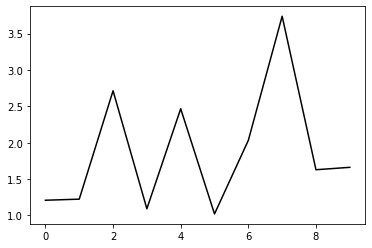

In [4]:
h=tf.zeros(layer)
h_in=[]
for i in range (layer):
    h_inn=np.float64(np.random.normal(2, 1))
    h_in.append(h_inn)
h=tf.Variable(h_in)
m2=tf.Variable(np.float64(np.random.normal(2, 1)))
lam=tf.Variable(np.float64(np.random.normal(1, 1)))
alpha=tf.Variable(np.float64(np.random.uniform(-0.5, 0.5)))
beta=tf.Variable(np.float64(np.random.uniform(-0.5, 0.5)))
#m2=tf.constant(np.float64(5.6))
#lam=tf.constant(np.float64(0.61))
#alpha=tf.constant(np.float64(1.444635))
#beta=tf.constant(np.float64(0.00615))
print("m^2=", m2)
print("lam=", lam)
print("alpha=", alpha)
print("beta=", beta)
print(h)
plt.plot(h.numpy(), 'k-')
plt.show()

In [5]:
def F_func(m, la, a,b):
    return 2*b/n_fin-m*a-la*(a**3)

def t_func(a):
    return 0.5*(tf.math.tanh(100*(a-0.1))-tf.math.tanh(100*(a+0.1))+2)

In [6]:
x=[i*0.1 for i in range (30)]
y=[0.0, 0.018, 0.035, 0.053, 0.0715, 0.0895, 0.107, 0.125, 0.146, 0.1665, 0.1875, 0.2085, 0.229, 0.25, 0.265, 0.281, 0.296, 0.3115, 0.3275, 0.343, 0.3565, 0.385, 0.4375, 0.5, 0.6, 0.675, 0.735, 0.815, 0.865, 0.885]
fp1 = np.polyfit(x, y, 15)
print(fp1)

[ 2.60581612e-01 -5.58472955e+00  5.38266808e+01 -3.08275478e+02
  1.16790041e+03 -3.08347723e+03  5.82285230e+03 -7.94502014e+03
  7.81868298e+03 -5.47798636e+03  2.66286328e+03 -8.59692413e+02
  1.71291955e+02 -1.84108983e+01  9.55260239e-01 -6.54557458e-05]


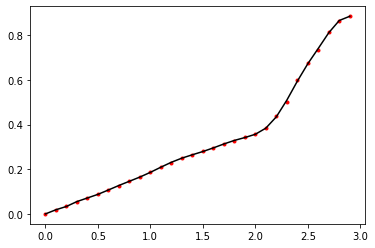

In [7]:
def f(x):
    y=0
    for i in range (16):
        y=y+fp1[i]*x**(15-i)
    return y
yy=[f(i*0.1) for i in range (30)]
plt.plot(x, y, 'r.')
plt.plot(x, yy, 'k-')
plt.show()

In [8]:
def NN_func_p(f):
    Positive=[]
    append=Positive.append
    while len(Positive)<batch:
        H=np.random.uniform(0.0, 3.0)
        M=np.random.uniform(0.0, 1.0)
        noise=np.abs(np.random.normal(0, 0.025))
        if np.abs(M-f(H))<=noise: append([H, M])
        else: continue
    return Positive
def NN_func_n(f):
    Negative=[]
    append=Negative.append
    while len(Negative)<batch:
        H=np.random.uniform(0.0, 3.0)
        M=np.random.uniform(0.0, 1.0)
        noise=np.abs(np.random.normal(0, 0.025))
        if np.abs(M-f(H))>noise: append([H, M])
        else: continue
    return Negative

In [9]:
Positive=[]
Negative=[]
for i in range (set):
    Positive.insert(i, NN_func_p(f))
    Negative.insert(i, NN_func_n(f))

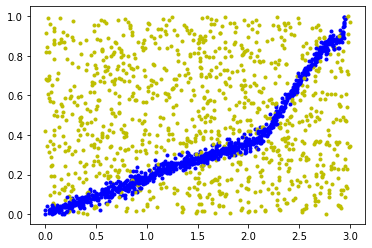

In [10]:
x_data1=[]
y_data1=[]
x_data2=[]
y_data2=[]
for i in range (set):
    x_data1.insert(i, [v[0] for v in Positive[i]])
    y_data1.insert(i, [v[1] for v in Positive[i]])
    x_data2.insert(i, [v[0] for v in Negative[i]])
    y_data2.insert(i, [v[1] for v in Negative[i]])
    plt.plot(x_data2[i], y_data2[i], 'y.')
    plt.plot(x_data1[i], y_data1[i], 'b.')
plt.show()

In [11]:
def Dfunc(hh, m):
    D=tf.math.sqrt(tf.math.abs(1+4*m/(hh[0]**2)))
    return D

In [12]:
def LP2(hh, m, la, alpha, beta, HH, MM):
    D=Dfunc(hh, m)
    phi=alpha*HH+beta*MM
    pi=1.5*(D-1)*alpha*HH+1.5*(-D-1)*beta*MM
    for j in range (layer-1):
        phi1=phi+dn*pi
        pi1 =phi*m*dn+(1-dn*hh[j])*pi+dn*la*(phi1**3)
        phi=phi1
        pi=pi1
    return phi, pi
def NN_func_01(hh, m, la, alpha, beta, list_hr):
    PP=[]
    NN=[]
    H=np.array(list_hr)[:, 0]
    M=np.array(list_hr)[:, 1]
    F=np.array(tf.math.abs(LP2(hh, m, la, alpha, beta, H, M)[1]))
    for i in range (len(H[F<0.1])):
        PP.append([H[F<0.1][i], M[F<0.1][i]])
    for i in range (len(H[F>=0.1])):
        NN.append([H[F>=0.1][i], M[F>=0.1][i]])
    return PP, NN

In [13]:
Positive0=[]
Positive1=[]
Negative0=[]
Negative1=[]
for i in range (set):
    Positive0.insert(i, NN_func_01(h, m2, lam, alpha, beta, Positive[i])[0])
    Positive1.insert(i, NN_func_01(h, m2, lam, alpha, beta, Positive[i])[1])
    Negative0.insert(i, NN_func_01(h, m2, lam, alpha, beta, Negative[i])[0])
    Negative1.insert(i, NN_func_01(h, m2, lam, alpha, beta, Negative[i])[1])

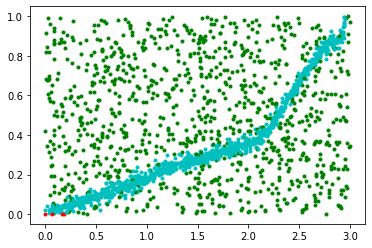

In [14]:
x_data1=[]
y_data1=[]
x_data2=[]
y_data2=[]
x_data3=[]
y_data3=[]
x_data4=[]
y_data4=[]
for i in range (set):
    x_data1.insert(i, [v[0] for v in Positive0[i]])
    y_data1.insert(i, [v[1] for v in Positive0[i]])
    x_data2.insert(i, [v[0] for v in Positive1[i]])
    y_data2.insert(i, [v[1] for v in Positive1[i]])
    x_data3.insert(i, [v[0] for v in Negative0[i]])
    y_data3.insert(i, [v[1] for v in Negative0[i]])
    x_data4.insert(i, [v[0] for v in Negative1[i]])
    y_data4.insert(i, [v[1] for v in Negative1[i]])
    plt.plot(x_data4[i], y_data4[i], 'g.')
    plt.plot(x_data2[i], y_data2[i], 'c.')
    plt.plot(x_data1[i], y_data1[i], 'r.')
    plt.plot(x_data3[i], y_data3[i], 'm.')
plt.show()

# Error function

$E=\sum_{data} \left\vert y(\bar{x}^{(1)}) - \bar{y} \right\vert+E_{reg}(W)$
, $E_{reg}=c_{reg}^{(1)}\sum_{n=1}^{N-1}(\eta^{(n)})^{4}(h(\eta^{(n+1)})-h(\eta^{(n)}))^{2}+c_{reg}^{(2)}(h(\eta^{(N)})-1/\eta^{(N)})^{2}$

In [17]:
def Error_func(hh, m, la, alpha, beta, list1, list2):
    H0=np.array([v[0] for v in list1])
    M0=np.array([v[1] for v in list1])
    H1=np.array([v[0] for v in list2])
    M1=np.array([v[1] for v in list2])
    H_0, M_0=LP2(hh, m, la, alpha, beta, H0, M0)
    H_1, M_1=LP2(hh, m, la, alpha, beta, H1, M1)
    PPlist=t_func(M_0)
    NNlist=t_func(M_1)
    sum_p=sum(PPlist)
    sum_n=(batch-sum(NNlist))

    inside=0
    for k in range (layer-1):
        second=((n_ini+k*dn)**4)*((hh[k+1]-hh[k])**2)
        inside=inside+second
    E_reg1=c_reg1*inside
    E_reg2=c_reg2*((hh[layer-1]-1/n_fin)**2)
    return sum_p+sum_n+E_reg1+E_reg2

In [18]:
for i in range (set):
    print(Error_func(h, m2, lam, alpha, beta, Positive[i], Negative[i]))

tf.Tensor(100.01726452249733, shape=(), dtype=float64)
tf.Tensor(100.01584906393039, shape=(), dtype=float64)
tf.Tensor(100.01726452249733, shape=(), dtype=float64)
tf.Tensor(99.0182972272998, shape=(), dtype=float64)
tf.Tensor(99.02237656310896, shape=(), dtype=float64)
tf.Tensor(100.01726452249733, shape=(), dtype=float64)
tf.Tensor(100.01726452249673, shape=(), dtype=float64)
tf.Tensor(99.01839869153044, shape=(), dtype=float64)
tf.Tensor(99.9103278449549, shape=(), dtype=float64)
tf.Tensor(99.02998645019404, shape=(), dtype=float64)


# Optimize

0 100.01459107737985
2.981034937890655 0.37543094189456727 -0.010291112406252023 0.46353122482119324
[1.30744028 1.32294036 2.61362945 1.19096825 2.36648809 1.11989111
 1.93235455 3.63901149 1.727015   1.76075389]


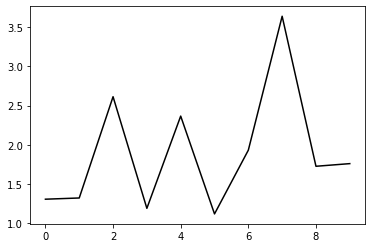

1100 98.06240725923962
2.9104743253350893 0.34061182519061606 0.08974295645256011 0.401259219274851
[1.43238665 1.49076806 2.49163571 1.34858735 2.23436378 1.06007336
 1.80286912 3.48513996 1.5700135  2.82189078]


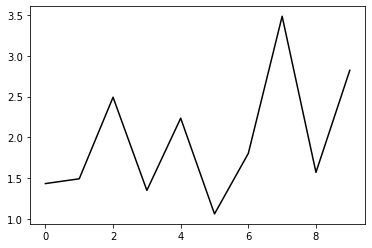

2200 95.29573499502318
2.985302355764527 0.32734879482150897 0.1662931007662457 0.35537212723604583
[1.19904577 1.73784086 2.73427162 1.60898046 2.49425141 1.33863542
 2.09518733 3.79390622 1.89133356 3.82783906]


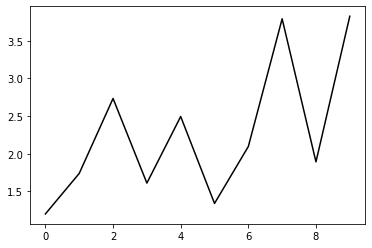

3300 99.40910313100491
2.8373600135694828 0.5339039735449912 0.1333198857869088 0.41805417542083934
[1.37830052 1.48030688 2.40238362 1.18558976 1.91186047 0.57135483
 1.14645407 2.79042448 0.91395928 4.78732634]


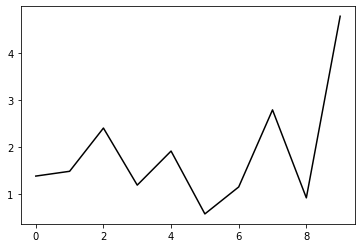

4400 100.71314830517625
2.8105492640242726 0.5788996204171192 0.11488542065274811 0.43429786854904834
[1.46706169 1.37468694 2.29198807 1.08525842 1.81062011 0.48604328
 1.08284033 2.76157738 0.91828762 5.70722064]


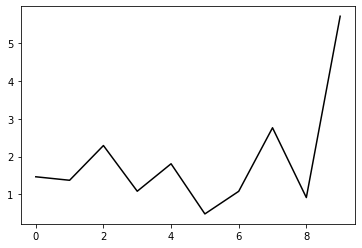

5500 101.00624429308152
2.7960630624158505 0.5894761580999892 0.104044257410853 0.4446992818588061
[1.52382137 1.31170109 2.2196423  1.02199177 1.73891797 0.42307883
 1.02798954 2.73037123 0.91620789 6.58705034]


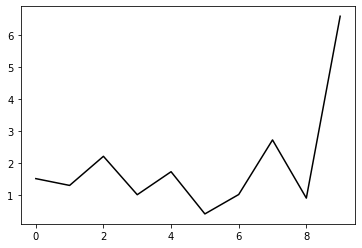

6600 100.99402549675303
2.782242504284762 0.5992596541825846 0.05942544225967806 0.46720769912394067
[1.70501548 1.13678991 2.05768883 0.9154129  1.69251743 0.50217459
 1.28025234 3.13871975 1.39533755 7.41460224]


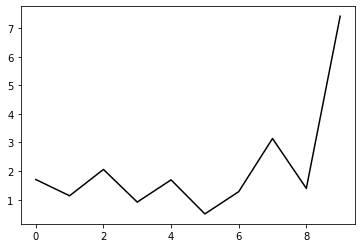

7700 99.23764032851899
2.834895575942229 0.5927485431478503 0.11529458826998205 0.4523231323240591
[1.38671752 1.54428972 2.46107542 1.35061412 2.12885648 0.96054874
 1.72659749 3.53726422 1.73098903 8.17061757]


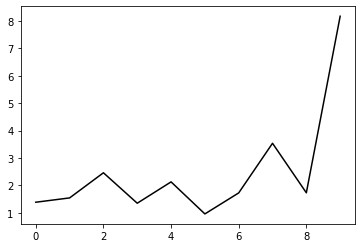

8800 99.03525853744831
2.821336804559907 0.5928295465873086 0.09638049990534533 0.47895752277420733
[1.48678156 1.51198006 2.42499852 1.33474525 2.11232195 0.96789891
 1.75937806 3.61914362 1.87241702 8.81988701]


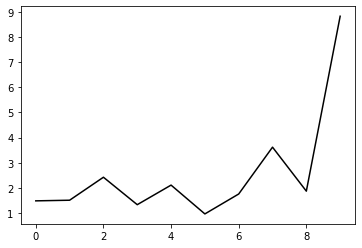

9900 100.66863435746608
2.7970518840301875 0.6342408792154648 0.06790454316478838 0.5162614585927908
[1.73810407 1.33277685 2.25613176 1.20133685 2.00785717 0.92654851
 1.81148827 3.8239427  2.23851871 9.30673978]


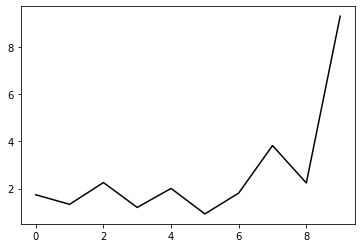

11000 100.95016850712423
2.7822635765806822 0.6695817374880922 0.049711319540887484 0.5415581708717546
[1.73437513 1.38361233 2.3161413  1.29514055 2.13369525 1.11817385
 2.09435267 4.21221698 2.67518339 9.57309925]


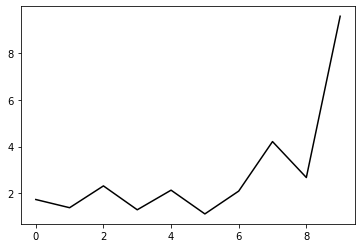

12100 100.00566900345383
2.7850057458203303 0.670583369466779 -0.021609484982043153 0.555427890205969
[1.8523899  1.26928322 2.21448166 1.24853055 2.14353818 1.24249021
 2.36913628 4.63502071 3.16822873 9.67524929]


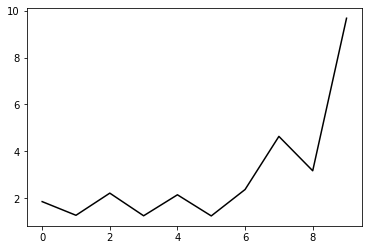

13200 100.0055395646431
2.782251756589301 0.6705821218110052 -0.021162675357879843 0.5549669551407472
[1.85454072 1.26469672 2.18025916 1.22995067 2.09067375 1.18730755
 2.28390886 4.53204293 3.07212169 9.68324258]


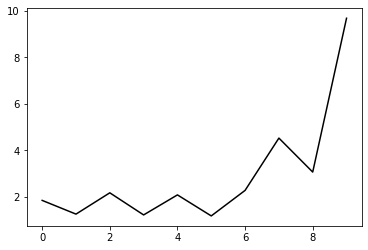

14300 99.00569404263803
2.779831827179202 0.6705806551644645 -0.020814482748067062 0.5545518724584906
[1.85697693 1.26332062 2.13124436 1.21054126 2.01931016 1.11968295
 2.17553767 4.40000813 2.95085958 9.67713837]


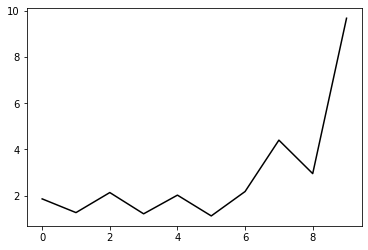

15400 99.00552547853117
2.7767978941804556 0.6705779811491437 -0.02080174563232497 0.5539712367653044
[1.85930056 1.26061535 2.04841856 1.1729356  1.89517764 0.99864947
 1.99176495 4.18227387 2.74759414 9.6679073 ]


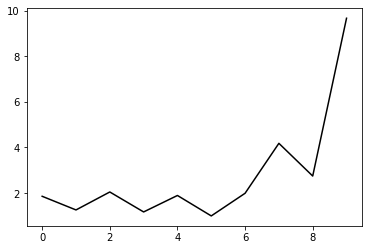

16500 100.0040954176412
2.7711538625496526 0.6705654967175576 -0.02590832886133784 0.55214213489732
[1.82357664 1.26325539 1.9191813  1.06813771 1.66663235 0.75487726
 1.68981248 3.85161103 2.42200811 9.65293297]


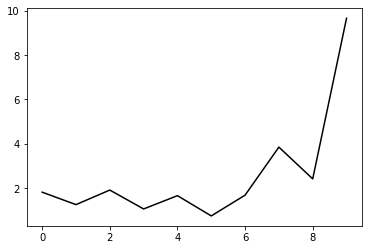

17600 100.00538775922536
2.7420484157247036 0.6705314904885196 -0.027223518251114187 0.5465596028476679
[1.86187561 0.91496381 1.40005568 0.54926704 1.05684174 0.13682707
 1.04046039 3.18578087 1.7521128  9.65173134]


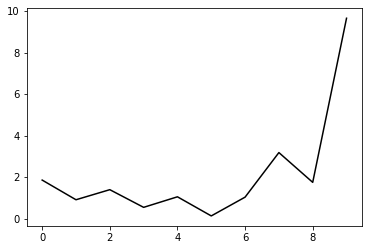

18700 99.00474735508024
2.739518223864523 0.6705283285341376 -0.027406646646580952 0.5460729073306876
[1.86033119 0.95592347 1.30433868 0.53345013 0.98186205 0.09289052
 0.98107421 3.11937034 1.69205211 9.62533241]


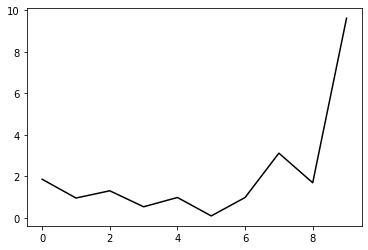

19800 99.00474022177967
2.7375505719120476 0.670525791188578 -0.02751967338680286 0.5457019023026093
[1.85786494 1.02949292 1.18596185 0.52712502 0.88717783 0.04878859
 0.91253503 3.03943612 1.62370114 9.61789998]


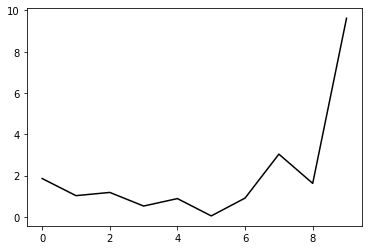

20900 99.00474537616022
2.735838564427548 0.6705232318905566 -0.027630695439497893 0.5453779422340254
[ 1.84785398e+00  1.13310041e+00  1.05363232e+00  5.24298238e-01
  7.60610665e-01 -2.27229273e-03  8.22609734e-01  2.92994684e+00
  1.53384159e+00  9.64957841e+00]


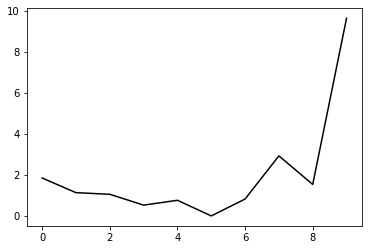

22000 100.00255882811315
2.7341430168303127 0.6705201771842111 -0.027607382180963497 0.5450866266773312
[ 1.85083338  1.22969827  0.92349162  0.50310268  0.59142687 -0.06761459
  0.70282089  2.7800033   1.41712876  9.60743522]


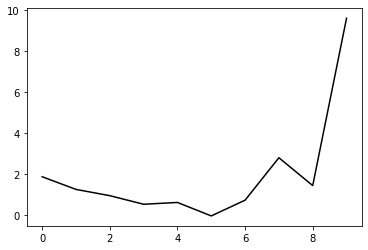

23100 100.0020596010121
2.7696271172279405 0.670553776352882 -0.04372229387907481 0.5478893035405656
[1.14012345 1.83326332 1.47260439 1.0617431  1.09420723 0.46309048
 1.20639812 3.26584245 1.91065934 9.63701058]


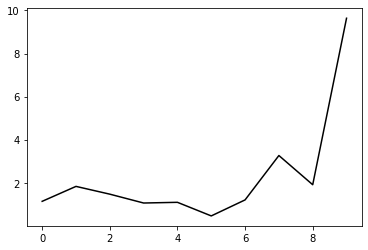

24200 100.00156045671548
2.729047381905225 0.670496118154824 -0.03718505767703325 0.5424694449305595
[ 1.54826567  1.32490855  0.98400168  0.55947609  0.54968676 -0.07850721
  0.64133206  2.68387761  1.33350737  9.4960379 ]


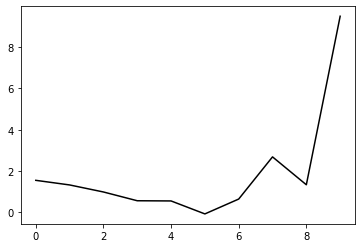

25300 99.00476374468393
2.7385935652123683 0.67049301340486 -0.0460577026783819 0.5419932080104447
[1.35895955 1.46607386 1.12376629 0.69263714 0.65154838 0.02687966
 0.72882976 2.75820418 1.41131963 9.60118852]


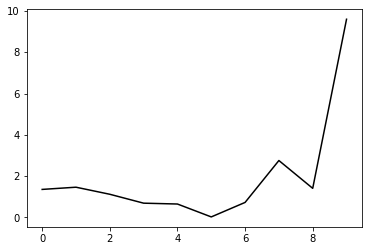

26400 99.0019719755152
2.707471153751216 0.6704560630775723 -0.03984770795092855 0.5382797701720132
[ 1.58905897  1.18522473  0.83963341  0.41007343  0.34411121 -0.27106572
  0.41711124  2.43657278  1.09379846  9.59858598]


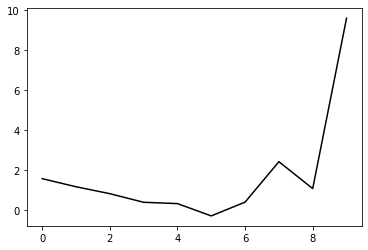

27500 100.00163107154519
2.696487233492153 0.670413203185395 -0.045864048540727655 0.5344768214781439
[ 1.47283484  1.23367506  0.86791613  0.42696132  0.32534945 -0.28927223
  0.37725761  2.38031025  1.04066136  9.543204  ]


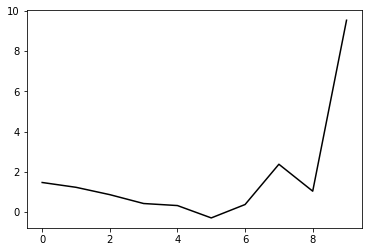

28600 100.00135164668569
2.6995403466688663 0.6704119968783391 -0.05031404447189009 0.5336055423274025
[ 1.36202077  1.28027756  0.92016705  0.47842198  0.35014757 -0.25620395
  0.39468231  2.38594089  1.05172356  9.58916732]


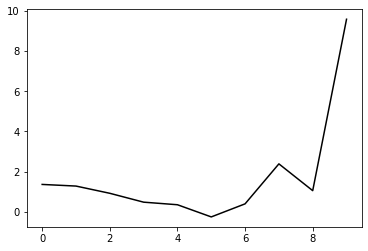

29700 99.00166147094069
2.6905652489321636 0.6703977854315918 -0.04901896070653181 0.532392198393832
[ 1.45221222  1.17033965  0.81581748  0.38516615  0.22767953 -0.35739851
  0.27686381  2.25554025  0.9328771   9.63454886]


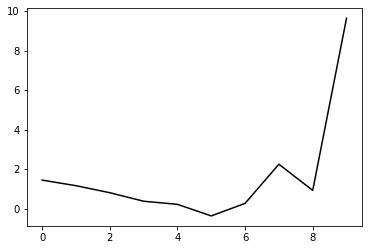

30800 99.00219199481299
2.665029879145381 0.6703325430189643 -0.050158787094185316 0.527148374559622
[ 1.49591917  1.03477974  0.6639458   0.22599083  0.03155761 -0.54792943
  0.06251846  2.0224951   0.70589878  9.56470222]


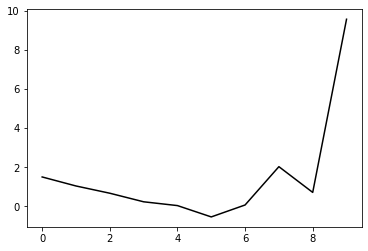

31900 98.01123369112753
2.6599086838311035 0.670248681531155 -0.06086526726763074 0.5221495041175607
[ 1.33909459  1.16604221  0.78657657  0.33269433  0.11099545 -0.4759441
  0.11501533  2.05907201  0.74308666  9.5777312 ]


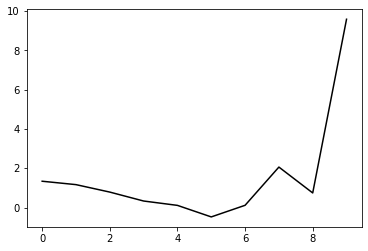

33000 100.00162262694961
2.6554696149456274 0.6702377524150037 -0.060181489115957845 0.521480626121518
[ 1.35796216  1.13594398  0.76471556  0.31653803  0.08024556 -0.49518825
  0.08609411  2.02207875  0.71405947  9.57558106]


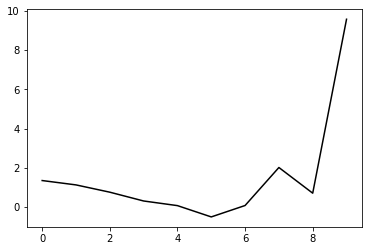

34100 99.00035816758248
2.652947557053953 0.6702227244059217 -0.06053810137748714 0.520773663116768
[ 1.35233296  1.11924589  0.75253104  0.31155996  0.05069001 -0.5078139
  0.05595433  1.97690198  0.68187553  9.56904539]


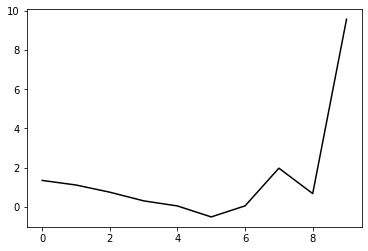

35200 100.00144289129145
2.6539559808841804 0.6702138780986612 -0.062407550090008694 0.5201602198562976
[ 1.25671842  1.1657069   0.81210509  0.37819792  0.08034222 -0.45574225
  0.07892762  1.97366059  0.69955     9.58246179]


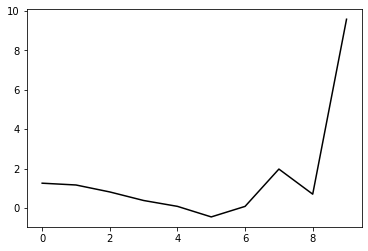

36300 99.00248993886247
2.6509620242293543 0.6702022800384198 -0.06260629330713013 0.5194092724198066
[ 1.25874384  1.11370073  0.7857198   0.36486488  0.02426662 -0.48098969
  0.01422279  1.87078557  0.62988783  9.57101873]


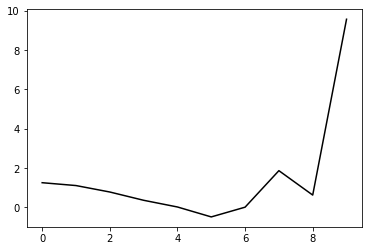

37400 100.00160026713215
2.7096578087067513 0.6701956607426339 -0.09426012477396832 0.5198831851613084
[ 1.03656407  1.31048692  0.96197067  0.53911958  0.16803518 -0.32842023
  0.13582685  1.96277189  0.73836603  9.6245363 ]


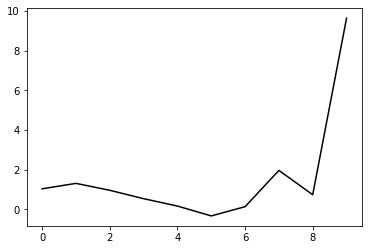

38500 100.00192021784095
2.6237748422497424 0.6698954780604622 -0.07456219751236885 0.5073204312679971
[ 1.3713829   0.97268903  0.61676166  0.18213876 -0.20613128 -0.70907472
 -0.26074637  1.55140766  0.32896835  9.49826154]


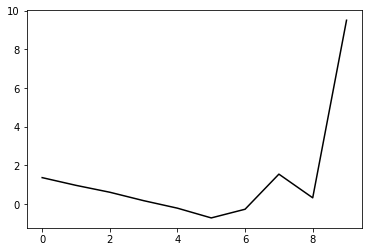

39600 99.01504623526831
2.5408501048906467 0.667672927920804 -0.0951794831072789 0.467370311210342
[ 1.41354485  0.72472001  0.31323179 -0.16154782 -0.59376754 -1.13675521
 -0.73421077  1.03588231 -0.21285975  9.51852322]


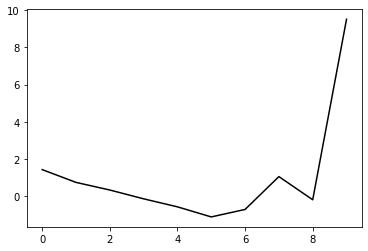

40700 87.36739022208414
2.151328936717648 0.6215513188631424 -0.11027957705789891 0.09730280160708947
[ 1.31537406  0.31158567 -0.23672486 -0.84064374 -1.41136407 -2.09864408
 -1.8478434  -0.2116606  -1.56750256  9.48506518]


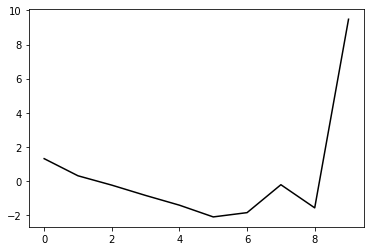

41800 64.67521853231811
1.7543813659706313 0.5188180240018329 0.06805534813353276 -0.0962225671427935
[ 1.86378592 -0.46154809 -1.05653621 -1.70907154 -2.33713601 -3.0949659
 -2.93057017 -1.38624188 -2.83858325  9.46650452]


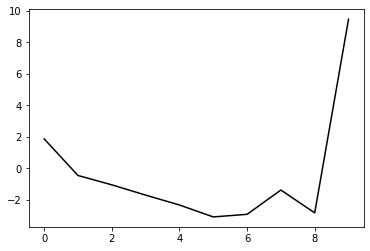

42900 78.91846835170534
1.7950065722914856 0.9166627286628345 0.14872038521684947 -0.17161968917588927
[ 2.02853168 -0.4969114  -1.07120271 -1.69521027 -2.28789303 -2.9988949
 -2.77383275 -1.16150649 -2.54879907  9.40224705]


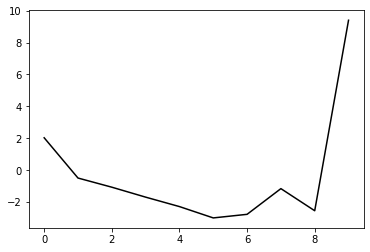

44000 102.57128220341913
1.781610409062563 1.2336525736213024 0.33564877685607275 -0.12638209978629297
[ 2.60348609 -1.02406619 -1.57065339 -2.15773359 -2.70146682 -3.34215702
 -3.01065447 -1.2590243  -2.52128845  9.42704615]


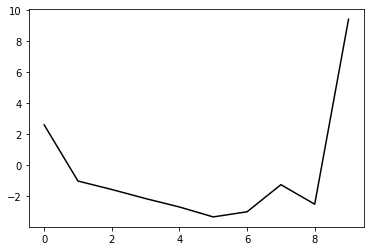

45100 45.40109518609986
1.7090933082568305 1.1445041648007785 0.29678541289950555 -0.18242994573811996
[ 2.56486944 -0.94332202 -1.51023884 -2.12030302 -2.69478926 -3.3810866
 -3.13071994 -1.50316175 -2.85977675  9.44106599]


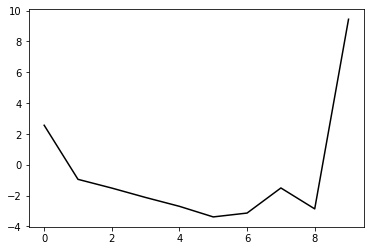

46200 38.17717106120707
1.8114325022630315 1.2061603211713032 0.306254320782211 -0.22572025693133144
[ 2.58859805 -0.84381414 -1.3915486  -1.97355796 -2.50703348 -3.12678901
 -2.76089608 -0.97336711 -2.23824562  9.44198373]


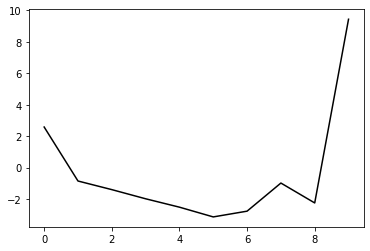

47300 35.07794636684
1.8094697302428504 1.23464292354537 0.3145344865639987 -0.22991167156307526
[ 2.63187731 -0.84452499 -1.39455269 -1.97839183 -2.51430482 -3.13435633
 -2.76496266 -0.97797019 -2.25358147  9.44072361]


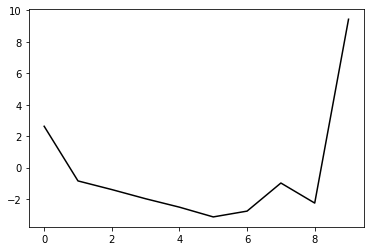

48400 37.69604146632868
1.8020138058224082 1.25074356713707 0.306953510495818 -0.23885157242915214
[ 2.60273835 -0.78046037 -1.33177509 -1.9173194  -2.45788678 -3.08564239
 -2.73458028 -0.98409013 -2.28327872  9.36602089]


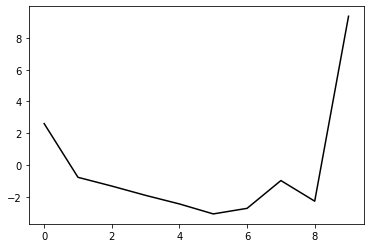

49500 33.59134769359143
1.7345322975056139 1.229215574559983 0.3115308091829351 -0.23387687289919737
[ 2.73384046 -0.87332799 -1.43459924 -2.0286028  -2.57708289 -3.21000374
 -2.86296597 -1.14966173 -2.53367959  9.45741683]


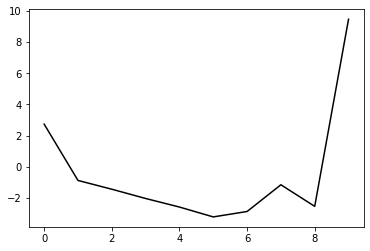

50600 37.25704799023082
1.7289554372906766 1.2301756540160425 0.3124746889014934 -0.24091915929233684
[ 2.71449506 -0.82098061 -1.38774108 -1.98688027 -2.5412181  -3.17871148
 -2.83559211 -1.13320977 -2.5406616   9.40347921]


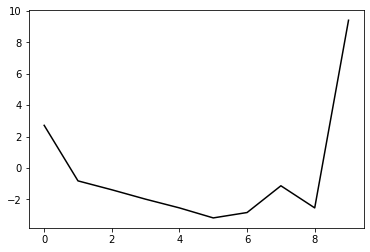

51700 44.07849897787175
1.7459544645156233 1.278215437613232 0.3293257234524279 -0.2389574333219222
[ 2.81385926 -0.87406248 -1.43493962 -2.02570693 -2.56972698 -3.1898207
 -2.81584287 -1.0702948  -2.44413609  9.46158284]


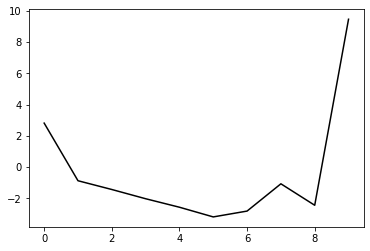

52800 60.21446183660842
1.6483443528678379 1.25062679914688 0.3296007330644631 -0.2185099176477052
[ 2.89000388 -1.02206723 -1.62353683 -2.26651405 -2.88136378 -3.59664701
 -3.3435416  -1.67766438 -3.04102612  9.36554536]


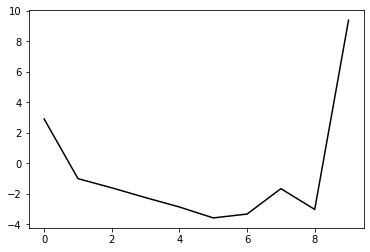

53900 49.6861601564239
1.7239748225615512 1.2739069252580486 0.3162721499500961 -0.26969105045749775
[ 2.83887966 -0.82569636 -1.40939432 -2.0251108  -2.59948433 -3.24708033
 -2.87183447 -1.05185228 -2.41072675  9.49556797]


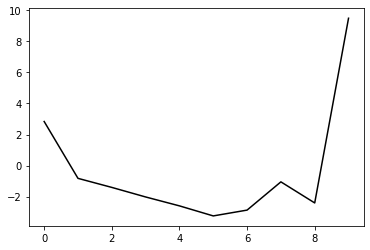

55000 32.22908657526071
1.7014524535201638 1.2926756064251728 0.3179772423822538 -0.2679887388242548
[ 2.82032121 -0.79702974 -1.38949431 -2.01623405 -2.60972047 -3.28926788
 -2.97481563 -1.23015347 -2.60304105  9.40098264]


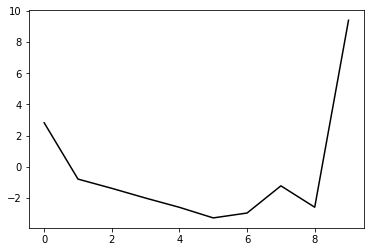

56100 30.051643909888487
1.7643904424746932 1.3262328617508208 0.3267665853194992 -0.28289632575171775
[ 2.94230606 -0.77624147 -1.34751823 -1.93895865 -2.47909561 -3.06906186
 -2.6065661  -0.73178962 -2.10183119  9.46045485]


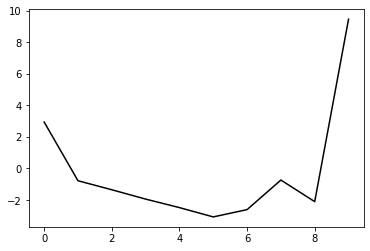

57200 38.392145537798584
1.746300227510692 1.3197517871311075 0.3309119866334664 -0.2864916483154555
[ 3.03799121 -0.75153666 -1.32018557 -1.9008106  -2.42352588 -2.98664758
 -2.49549224 -0.6376033  -2.08270099  9.3794774 ]


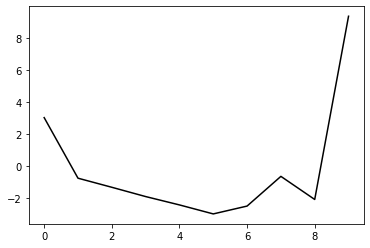

58300 30.148199363275584
1.8255949259886297 1.3649891014976185 0.336255243126893 -0.31810050135545465
[ 3.08321345 -0.66084034 -1.21241009 -1.76786582 -2.25704909 -2.77217142
 -2.21174047 -0.269101   -1.64355104  9.45871942]


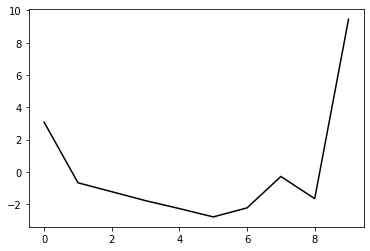

59400 36.36405371989515
1.7396587327965214 1.3337797682628199 0.3291573924687376 -0.32134159986245886
[ 3.08770309 -0.65272245 -1.22357164 -1.80141249 -2.32206131 -2.88602342
 -2.41959032 -0.63505199 -2.11252664  9.49621577]


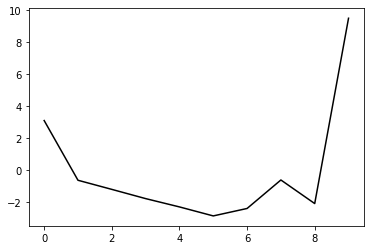

60500 43.038549633586925
1.7680869985050043 1.3908980113107943 0.3561707380175768 -0.3186625893706019
[ 3.28710235 -0.77758303 -1.3414755  -1.90711543 -2.41076928 -2.94789558
 -2.43704442 -0.58803753 -1.99764545  9.4687853 ]


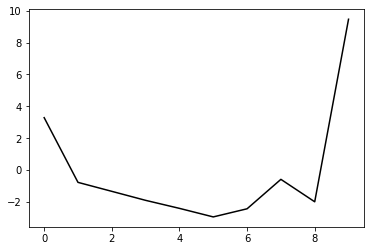

61600 33.97734019233482
1.752746225439183 1.3826109166834613 0.35034357019514445 -0.33629382446312794
[ 3.22871391 -0.67049211 -1.23730357 -1.80333408 -2.30665616 -2.84169432
 -2.32796883 -0.47856964 -1.89960064  9.39014798]


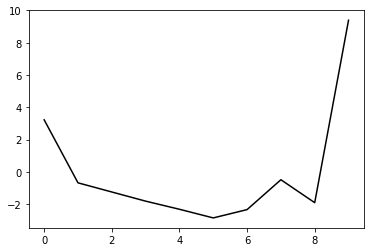

62700 36.777148793034804
1.7397339228209312 1.3841038686719729 0.35555023019437115 -0.34229861560571745
[ 3.30351132 -0.70833341 -1.28225104 -1.8539449  -2.36421114 -2.9081867
 -2.4117298  -0.59112308 -2.01812691  9.50514303]


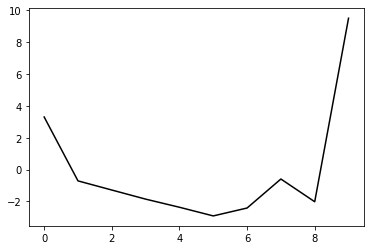

63800 40.64666997787063
1.7769738825383814 1.4255183142816985 0.3711720531374285 -0.34105253344580744
[ 3.38985595 -0.7286563  -1.29146152 -1.84630124 -2.33369427 -2.84094401
 -2.27681732 -0.34041823 -1.67162904  9.44186262]


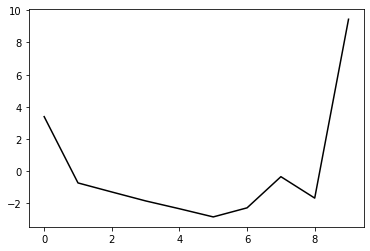

64900 39.88349213790509
1.7148899721181088 1.40364209618337 0.34726880493719503 -0.3596266946299117
[ 3.22791764 -0.54276034 -1.11965523 -1.6913933  -2.20580742 -2.75901679
 -2.28749779 -0.49203389 -1.91357036  9.46291881]


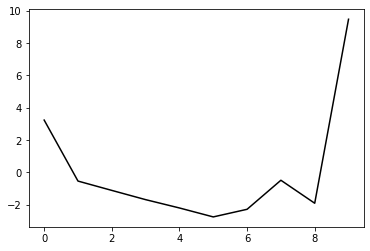

66000 30.136680165471333
1.737033713180315 1.4283155991905023 0.3631675050089294 -0.3584653936129991
[ 3.37981862 -0.62647043 -1.20493834 -1.7726411  -2.27886508 -2.81460473
 -2.30855993 -0.46421448 -1.86362659  9.43700345]


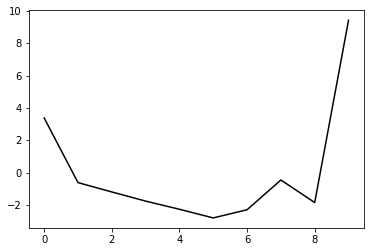

67100 31.141503844535112
1.7709220934140877 1.4662899068129782 0.3728343952500623 -0.36259496411847786
[ 3.38164627 -0.54765619 -1.11321865 -1.66138218 -2.14312877 -2.64353911
 -2.08257148 -0.16949668 -1.5373587   9.50695565]


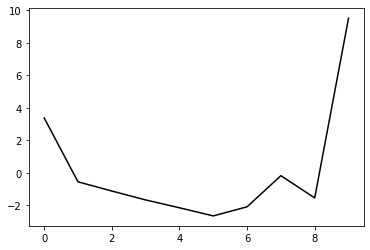

68200 40.738095415662784
1.698237708612622 1.4906454229262398 0.37641488630300524 -0.3540804384643975
[ 3.47129569 -0.62915583 -1.20511876 -1.76471158 -2.26536841 -2.79604587
 -2.28567961 -0.43272321 -1.82889144  9.45276746]


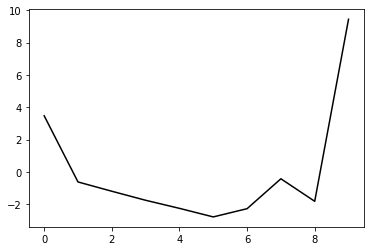

69300 29.03134170650713
1.6531860496843342 1.4873592209801343 0.37070528349207865 -0.3656415522401504
[ 3.42930328 -0.51481129 -1.10021099 -1.66803559 -2.18013065 -2.72886423
 -2.25874296 -0.48244558 -1.95680247  9.34634566]


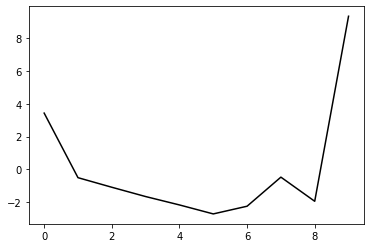

70400 35.66819995512579
1.6332966421775204 1.4301160829578003 0.348637780657624 -0.39120929539033455
[ 3.43024281 -0.47897216 -1.07540905 -1.65084615 -2.16965747 -2.72313894
 -2.25756716 -0.48898769 -1.9755003   9.441636  ]


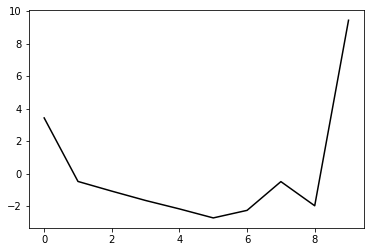

71500 35.27061663823677
1.6314442316977265 1.4244657641659908 0.3588146496047848 -0.3884827039457256
[ 3.55751535 -0.5652544  -1.17026575 -1.74997346 -2.27167978 -2.82573023
 -2.35848728 -0.58379324 -2.05836606  9.46059781]


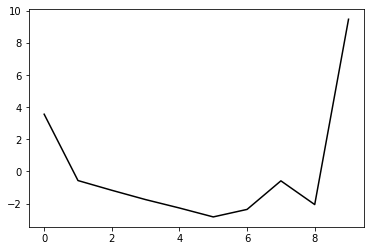

72600 32.398353716090824
1.6622578608113636 1.4407977551291233 0.3718960912683335 -0.38770496342759647
[ 3.62798405 -0.58336444 -1.188816   -1.76395035 -2.27823166 -2.81899295
 -2.32802065 -0.51343897 -1.93908657  9.35851329]


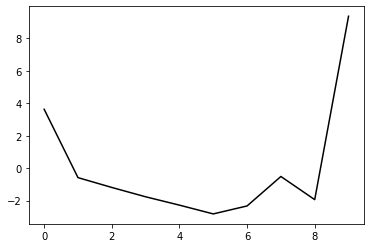

73700 35.68817233272105
1.6719521266592536 1.432731973267274 0.37737332649377137 -0.38600177063748886
[ 3.72074257 -0.63876922 -1.25418764 -1.83498506 -2.35423907 -2.89791797
 -2.4085946  -0.59364147 -2.01318169  9.46588421]


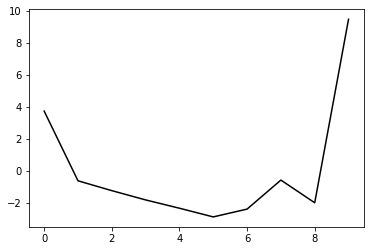

74800 36.219541138825036
1.6325497756516807 1.4558501150765335 0.385452060130318 -0.38757005161596153
[ 3.71713517 -0.59081891 -1.21003479 -1.79438209 -2.32065086 -2.87644112
 -2.41356186 -0.64917144 -2.11804416  9.42625692]


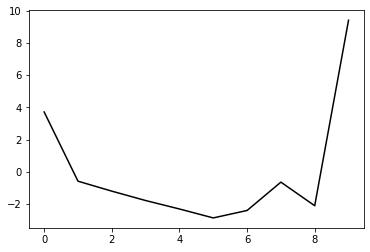

75900 45.22806215497168
1.618905230571046 1.4286036304535528 0.3598918065262596 -0.41991970593254546
[ 3.56269553 -0.38787034 -1.01411311 -1.60243087 -2.13340121 -2.69519548
 -2.24951436 -0.54550414 -2.12155233  9.50099577]


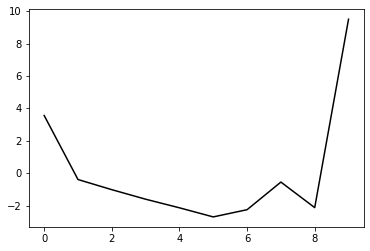

77000 28.99531438743473
1.6103340094261203 1.418667039793809 0.37054622567265433 -0.4185333662921524
[ 3.74335798 -0.5292156  -1.16740579 -1.76472638 -2.30521288 -2.87756287
 -2.44735524 -0.75236558 -2.27228246  9.41153831]


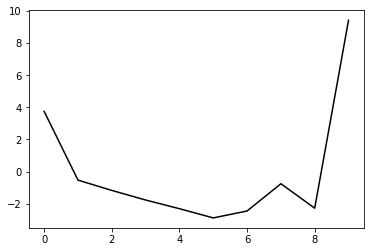

78100 28.72367651195492
1.5845284351295845 1.4145454770395103 0.3769341889815903 -0.40779449217479696
[ 3.76824607 -0.57639248 -1.22883359 -1.84087862 -2.40228012 -3.00498624
 -2.62525963 -0.99715894 -2.54179596  9.44626219]


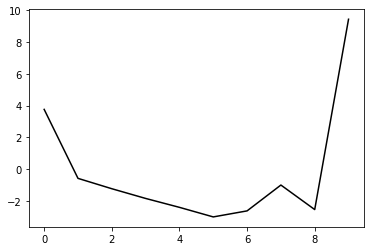

79200 38.87122772330313
1.5675722478994012 1.4135141787982017 0.3748006200167843 -0.4139072410708018
[ 3.84627076 -0.61019242 -1.27067366 -1.88732242 -2.45541369 -3.068136
 -2.71608341 -1.15596372 -2.70358291  9.39190114]


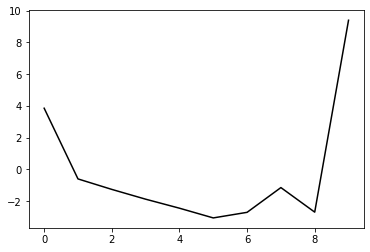

80300 30.924866518765977
1.5833211234095204 1.4124148548145732 0.3721496925889618 -0.42953589144191956
[ 3.79777364 -0.48049876 -1.1443397  -1.75925454 -2.32237595 -2.92180612
 -2.54146264 -0.94292758 -2.51015659  9.40284572]


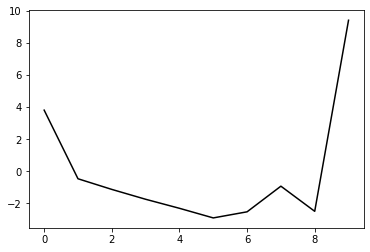

81400 39.110443655971345
1.5745993262128812 1.380033614833375 0.3559275043913691 -0.45184686329361745
[ 3.82358623 -0.45660613 -1.13082346 -1.75196032 -2.32055043 -2.92308959
 -2.54445759 -0.94709038 -2.51790973  9.42521988]


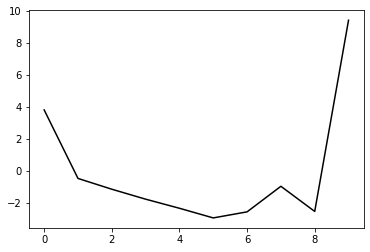

82500 39.25219411475757
1.592122206581989 1.4288914565646733 0.3931929272097435 -0.4273531925483933
[ 4.03238159 -0.61533494 -1.29572839 -1.92030134 -2.49349714 -3.10118592
 -2.73048199 -1.13640337 -2.66353451  9.36589987]


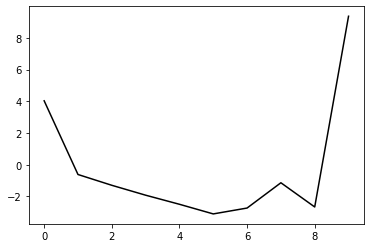

83600 32.644228707934836
1.635740717773253 1.4437310728197723 0.3930506250001407 -0.44140853064813035
[ 4.01635478 -0.51307212 -1.18570976 -1.79490231 -2.34724773 -2.92252843
 -2.4960505  -0.81161371 -2.25247534  9.48576287]


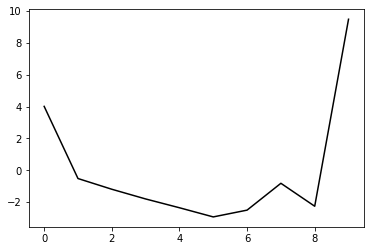

84700 34.785220706372954
1.628502732050298 1.4166853123367966 0.39929647376960586 -0.43749792858078307
[ 4.12564396 -0.57263559 -1.25877279 -1.8775452  -2.43857492 -3.02004959
 -2.59852588 -0.9178899  -2.3673248   9.43898093]


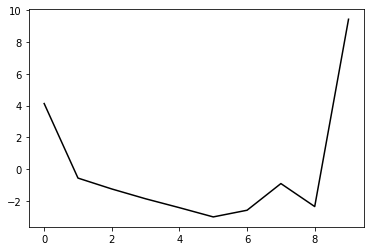

85800 36.17292971175151
1.6169799838673478 1.428425740029426 0.40586522718336226 -0.4379030500235954
[ 4.16788138 -0.57539286 -1.26514457 -1.88475946 -2.44709684 -3.02909269
 -2.60672502 -0.91935046 -2.36089819  9.40859347]


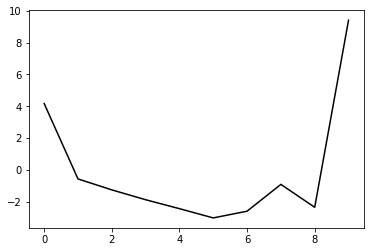

86900 40.0563718050301
1.5608282946666603 1.3931448712596213 0.3945810490129567 -0.45052576088440643
[ 4.09014209 -0.47741384 -1.18787656 -1.82764483 -2.41471619 -3.03034661
 -2.66809532 -1.09575526 -2.6893779   9.50492878]


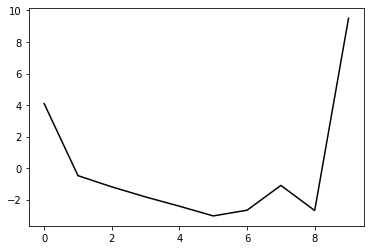

88000 29.76267588796529
1.5439775633318038 1.3770061763366037 0.3966177667854934 -0.4497247755143661
[ 4.12304498 -0.51044009 -1.2340355  -1.8859953  -2.48847752 -3.12412093
 -2.79411352 -1.27167979 -2.89549084  9.41165554]


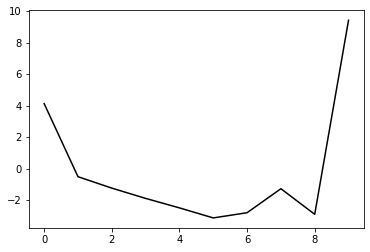

89100 31.16850030169065
1.6055009312305826 1.3967802780601275 0.4011979535031053 -0.4626564698504149
[ 4.25231434 -0.49900034 -1.20895899 -1.83635544 -2.40398083 -2.98427888
 -2.56009877 -0.90666575 -2.44089894  9.43779653]


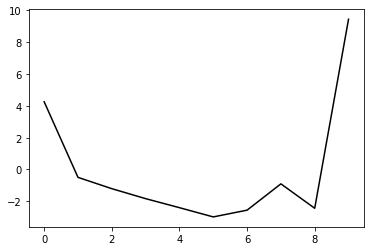

90200 42.14052424642068
1.586966409419415 1.4452970051037393 0.42307963243557056 -0.44465877419254835
[ 4.34312731 -0.56980384 -1.28176818 -1.91093081 -2.48690507 -3.08574159
 -2.70145394 -1.09291881 -2.6091758   9.3950847 ]


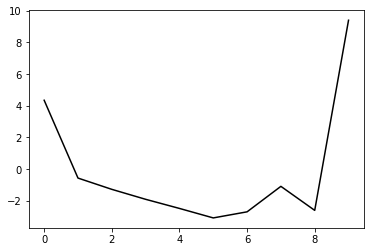

91300 28.673270830969507
1.5542933813642328 1.4178495951496974 0.40980552908842843 -0.45995732393327887
[ 4.30214003 -0.49897617 -1.22667425 -1.86955904 -2.46223084 -3.08236386
 -2.73575732 -1.20185929 -2.79740082  9.41579084]


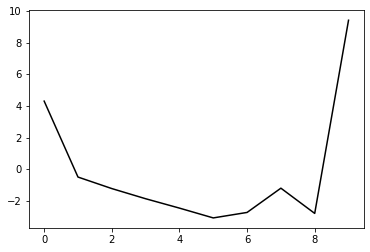

92400 33.26049417992224
1.5685680699167774 1.415156569601242 0.40985715373334364 -0.4670080580196861
[ 4.31689166 -0.44783301 -1.17963323 -1.82070249 -2.4094249  -3.02033448
 -2.65708544 -1.10592454 -2.70862025  9.52277196]


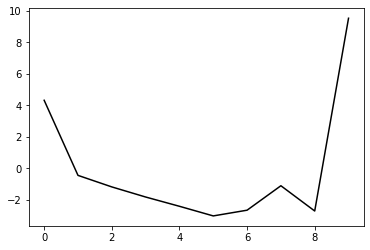

93500 35.122461212346124
1.5833739178059414 1.4262737270890715 0.40889992593713737 -0.47709964728361837
[ 4.30338525 -0.34844418 -1.07932803 -1.71236977 -2.29065406 -2.88533108
 -2.49615153 -0.9089562  -2.48698621  9.4333807 ]


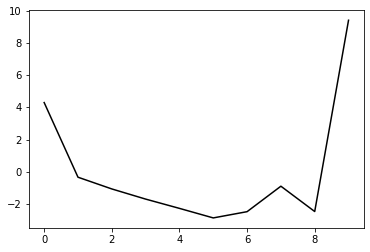

94600 31.89393019198452
1.6040968266720448 1.4324752770819364 0.4144445706491815 -0.4776488888571373
[ 4.42557914 -0.39771067 -1.13211006 -1.75840098 -2.32499339 -2.89747894
 -2.46404964 -0.79070161 -2.27911716  9.40787271]


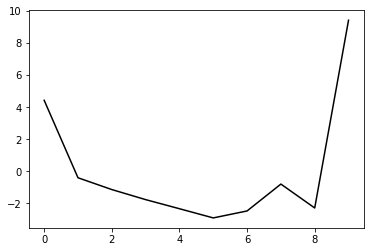

95700 38.66288570668124
1.5663119678776123 1.393272123968052 0.41722188390408416 -0.46809647241151875
[ 4.55192383 -0.5684676  -1.3396883  -2.00162076 -2.61093095 -3.23940098
 -2.89792029 -1.3821171  -3.05782166  9.3583208 ]


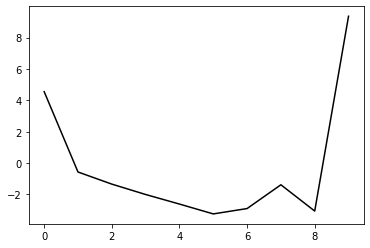

96800 37.28785762588145
1.6183853262783285 1.4326951015548295 0.4321038113806169 -0.4781834306609665
[ 4.66644857 -0.52277827 -1.28449427 -1.92855365 -2.51297924 -3.10266185
 -2.69671909 -1.0811633  -2.65603072  9.39998894]


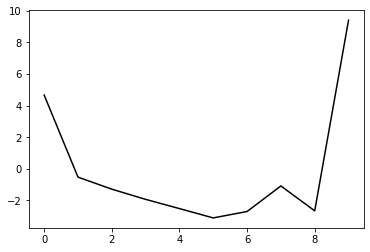

97900 39.315669414981095
1.58704308253203 1.4186218322498643 0.42737519000504276 -0.49214980051118223
[ 4.65755016 -0.46290893 -1.23526633 -1.88762612 -2.4814415  -3.08252991
 -2.69772586 -1.12738493 -2.76963209  9.42064832]


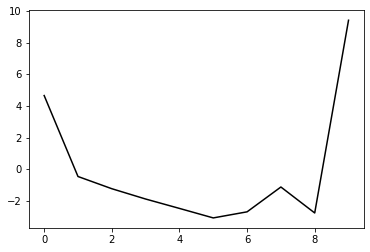

99000 29.180028789608414
1.5581463192532576 1.386899176885628 0.4072800240886154 -0.5130009664307629
[ 4.57371246 -0.39352436 -1.18262959 -1.8504342  -2.46301929 -3.08737575
 -2.73640128 -1.21133443 -2.8908249   9.39835022]


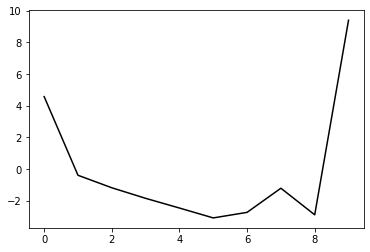

100100 31.108091744198493
1.5513605657919185 1.3968688952175905 0.41523428823702496 -0.5123952650781168
[ 4.71054157 -0.46428673 -1.26246421 -1.93574721 -2.55505657 -3.18860708
 -2.85853495 -1.38349301 -3.12508508  9.40918306]


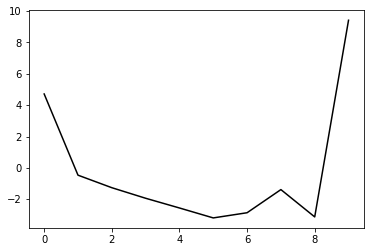

101200 40.21105334995803
1.5115146049959076 1.3788411876318831 0.41473062346157813 -0.509829632413453
[ 4.69053705 -0.46802022 -1.28195191 -1.97075976 -2.61098615 -3.27533265
 -3.00259674 -1.63356103 -3.46998347  9.29366428]


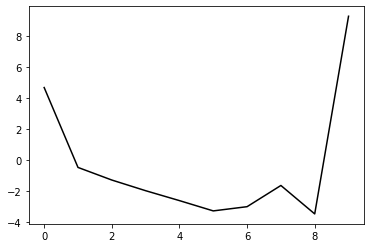

102300 32.18502731191753
1.5646297308100576 1.404586189428956 0.438590296094817 -0.4991880814016115
[ 4.83470096 -0.52019822 -1.33226999 -2.01141607 -2.63614075 -3.27253173
 -2.94554489 -1.48255465 -3.22994677  9.37121589]


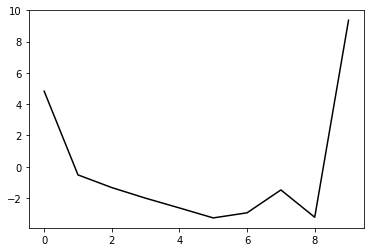

103400 33.80559064282982
1.5266659116475547 1.36342945173801 0.42767403396546616 -0.5007054108601461
[ 4.74251938 -0.49308642 -1.32995203 -2.03427591 -2.69002927 -3.36495673
 -3.09300411 -1.70614586 -3.52455148  9.39585692]


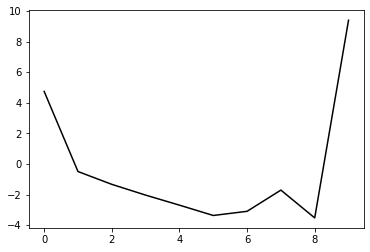

104500 35.51442618455912
1.554698325653017 1.373408741464715 0.41724402233449437 -0.5298527309001878
[ 4.83630254 -0.3658195  -1.19123911 -1.87471137 -2.50305814 -3.13823621
 -2.81081232 -1.37192189 -3.17938826  9.38536091]


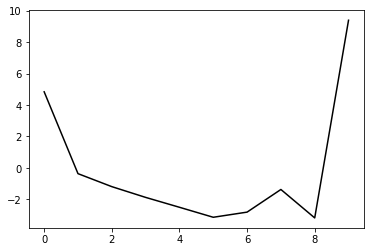

105600 33.11177936872362
1.575881995998167 1.374240782656073 0.42772362501362876 -0.5249426086596318
[ 4.90971123 -0.39831654 -1.23281144 -1.91941842 -2.5491398  -3.18110034
 -2.84276435 -1.38000936 -3.15371653  9.489023  ]


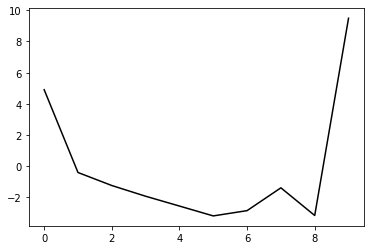

106700 38.18023652852083
1.5750269313865253 1.366917481826951 0.4236375625816816 -0.5360089237865113
[ 4.92555499 -0.34562292 -1.19110516 -1.88353395 -2.51872251 -3.15478164
 -2.82153743 -1.36888792 -3.16192305  9.4120355 ]


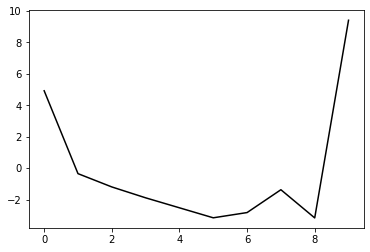

107800 40.74219111367364
1.6089486003837459 1.392678453245501 0.4511188979880948 -0.5129280214554067
[ 5.14783955 -0.54501234 -1.39411545 -2.08301835 -2.71262957 -3.33657625
 -2.97554567 -1.45880813 -3.14406496  9.39039959]


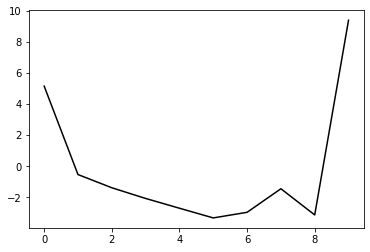

108900 39.05796669986015
1.566820888989987 1.3640706852427997 0.41925244690345237 -0.5491241504016103
[ 4.90671934 -0.23468528 -1.09693691 -1.79571422 -2.43844922 -3.0811012
 -2.76045969 -1.34456286 -3.20556339  9.42833435]


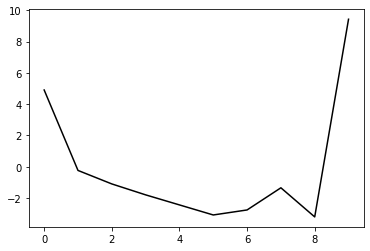

110000 29.09200468218306
1.5358142180931995 1.338995823106741 0.42342037468755456 -0.5401438215250428
[ 4.980813   -0.35791969 -1.24647082 -1.97150918 -2.6470911  -3.33336805
 -3.08670236 -1.80438113 -3.78081968  9.29832188]


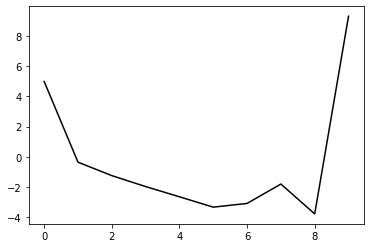

111100 28.671940560707515
1.5526416362082611 1.349791402638282 0.4358339265232255 -0.5316476734484427
[ 5.08815859 -0.43864386 -1.33704192 -2.06775181 -2.75002744 -3.44116765
 -3.19550777 -1.90177273 -3.8332298   9.42974699]


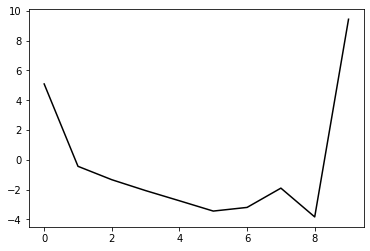

112200 43.37462549076967
1.6150268773883603 1.3855437281076872 0.4645500624143974 -0.5166205053439188
[ 5.33644852 -0.43242533 -1.31486142 -2.01550045 -2.65811311 -3.29314693
 -2.96380669 -1.57035028 -3.45150554  9.36328734]


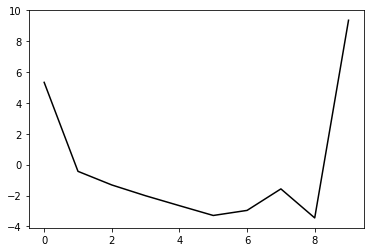

113300 28.65707459300281
1.6055226154898559 1.3864221974136088 0.44686803088665455 -0.5470064522594613
[ 5.2853539  -0.2749389  -1.15946957 -1.85736585 -2.49688012 -3.12682867
 -2.7915243  -1.39565964 -3.28473862  9.39617862]


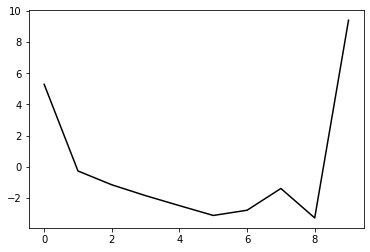

114400 32.45664932181435
1.6135177107873129 1.37977234730401 0.44192741447099404 -0.5584620874796579
[ 5.27271818 -0.17219453 -1.06436425 -1.76412741 -2.40496959 -3.03452053
 -2.69869575 -1.30496867 -3.19951786  9.37519655]


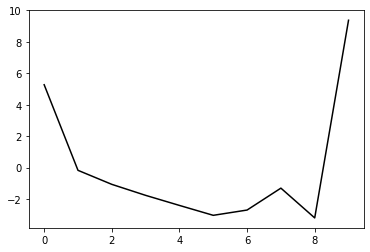

115500 36.440843731920296
1.5602558871028624 1.3283562182227227 0.4343620130937741 -0.5609497835186603
[ 5.29639571 -0.2124328  -1.12749243 -1.8472429  -2.51084484 -3.16863519
 -2.87978771 -1.57565898 -3.61346097  9.44661511]


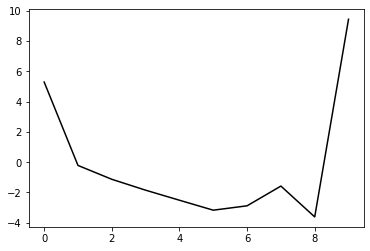

116600 32.068236156164005
1.6027868051277576 1.3525850452657278 0.45559729955228284 -0.5476558244464905
[ 5.43229328 -0.29823105 -1.21499467 -1.92951969 -2.58534683 -3.23051002
 -2.91894814 -1.57304348 -3.54804127  9.35079999]


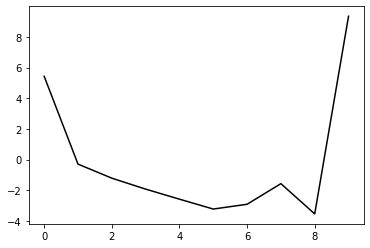

117700 38.06617257450332
1.589986914975917 1.3372855057878217 0.45939106090611637 -0.5405640122080466
[ 5.44807018 -0.37352432 -1.31031067 -2.03999167 -2.71328333 -3.379592
 -3.09998462 -1.80414348 -3.83886425  9.36411012]


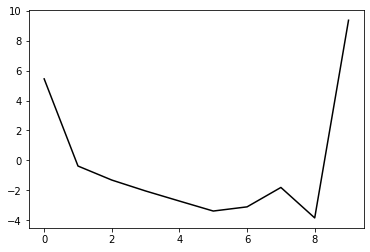

118800 38.39668892042369
1.5932844855954666 1.325146013801172 0.4576951553282426 -0.549278136260173
[ 5.44019808 -0.27288845 -1.22207977 -1.95954151 -2.64025845 -3.31150092
 -3.03494571 -1.73986813 -3.76800115  9.48814302]


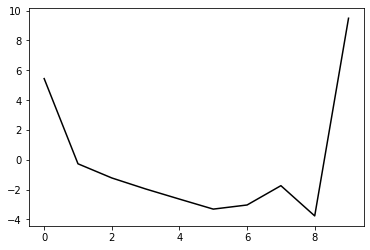

119900 38.59682123750043
1.5915611018769813 1.3165735776592742 0.4415402952363298 -0.5733248289389006
[ 5.44564483 -0.17995891 -1.13648137 -1.875331   -2.55619491 -3.22332839
 -2.93557733 -1.61621129 -3.60388845  9.38641022]


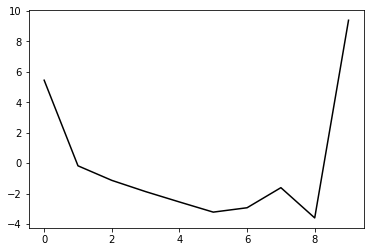

121000 28.63671986785244
1.6138937138867813 1.3132508020645564 0.4461196547894711 -0.575080191346506
[ 5.51914433 -0.19187557 -1.1583752  -1.89958618 -2.58117108 -3.24585897
 -2.95224082 -1.62363728 -3.59800453  9.31232136]


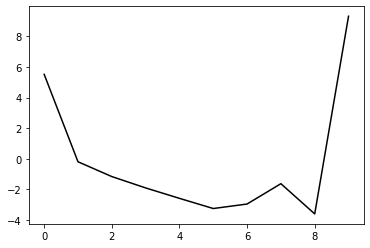

122100 30.69602328146349
1.636688722172571 1.3187164788736396 0.4584337498847506 -0.5693653767196815
[ 5.67552206 -0.25396004 -1.22894543 -1.97047203 -2.64998629 -3.30838113
 -3.00396828 -1.66131993 -3.62225041  9.41921033]


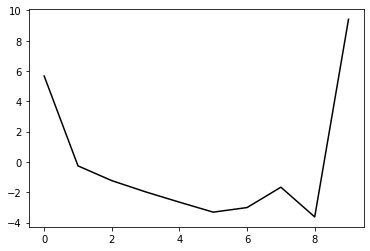

123200 42.04717895362591
1.6513949933873167 1.3337134726604192 0.475041933351709 -0.5582716078650367
[ 5.71795318 -0.29678575 -1.28177965 -2.02690237 -2.70937489 -3.36901214
 -3.0642723  -1.71869202 -3.67337811  9.37173284]


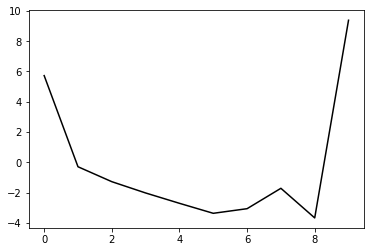

124300 29.015842543351454
1.612217864225579 1.3214823241873577 0.4545727519188975 -0.5796806770440531
[ 5.55273985 -0.13412422 -1.13249442 -1.88760423 -2.5838683  -3.26248355
 -2.98976527 -1.69658422 -3.71164413  9.38532229]


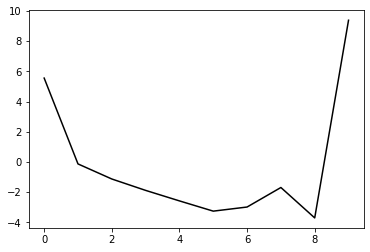

125400 33.00582226979978
1.6140718486051584 1.3274637007250183 0.4613766365164843 -0.5752780887998774
[ 5.6057959  -0.18673012 -1.1970909  -1.95580035 -2.65588258 -3.33869065
 -3.07584833 -1.79666651 -3.79789077  9.29944515]


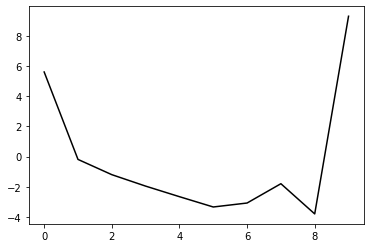

126500 34.93611069223846
1.6078071226453274 1.3103227806072992 0.45083585318686475 -0.5891982726324836
[ 5.5793006  -0.13687693 -1.16236016 -1.93030298 -2.64012776 -3.33141704
 -3.07695732 -1.80765063 -3.82897807  9.36736867]


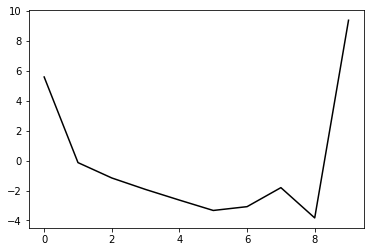

127600 32.151197018531384
1.616238816115386 1.3161493825155668 0.46438283481746734 -0.584903247843207
[ 5.73973095 -0.19568107 -1.23086514 -2.0010042  -2.70969054 -3.39216592
 -3.11435623 -1.79477643 -3.76120038  9.34080252]


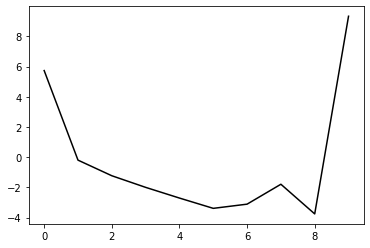

128700 34.7639873674024
1.6302142662618706 1.3240067707831467 0.46852388964446007 -0.5876264144166166
[ 5.75051248 -0.14570171 -1.18765146 -1.95852651 -2.66731861 -3.34775008
 -3.06547172 -1.73974293 -3.69926961  9.3601909 ]


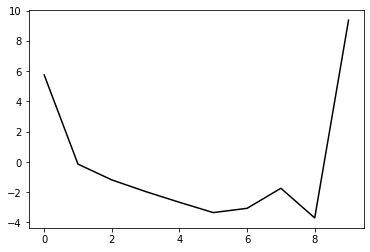

129800 38.416055781630405
1.6406197177136945 1.3405077085028005 0.472705364195862 -0.5909104111876828
[ 5.86329671 -0.16522894 -1.20968387 -1.97563464 -2.67762281 -3.34716612
 -3.04801469 -1.69897459 -3.6355663   9.38498468]


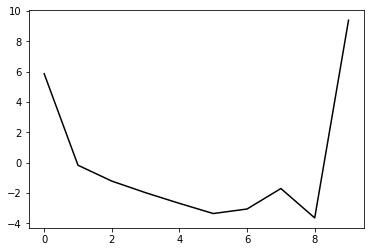

130900 37.84930496576988
1.6307055402022947 1.3417794049494292 0.4644102586103595 -0.6028805656400235
[ 5.68920323e+00 -5.24027807e-03 -1.05855722e+00 -1.82746022e+00
 -2.53468735e+00 -3.21161129e+00 -2.92674586e+00 -1.60790927e+00
 -3.58795264e+00  9.30700670e+00]


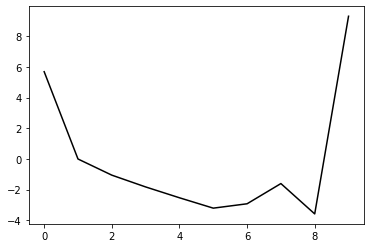

132000 28.64548691141268
1.6122284534298823 1.337103971057384 0.465786957691402 -0.6031275433823112
[ 5.67688122 -0.09168055 -1.16977588 -1.96052911 -2.69371589 -3.40105328
 -3.15724004 -1.87935247 -3.86010817  9.32744049]


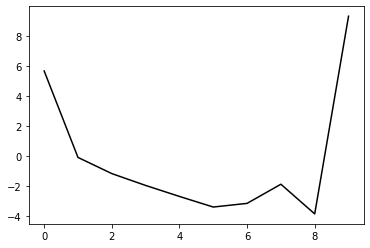

133100 28.52413099697919
1.556038984500891 1.3070513025373205 0.46590155596561483 -0.593783286604676
[ 5.52890658 -0.18145437 -1.29466407 -2.12319286 -2.90605329 -3.68357365
 -3.55842478 -2.46087898 -4.54140382  9.35796504]


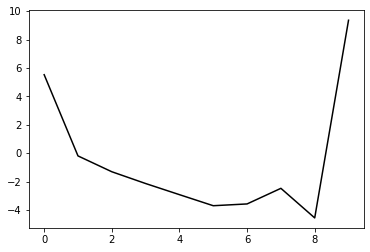

134200 41.259062248379664
1.5794372515248516 1.352868122046079 0.4861595462398916 -0.5842635415250381
[ 5.64981194 -0.1810338  -1.29336401 -2.11627872 -2.89383288 -3.66324823
 -3.52392486 -2.38544326 -4.39167666  9.30810218]


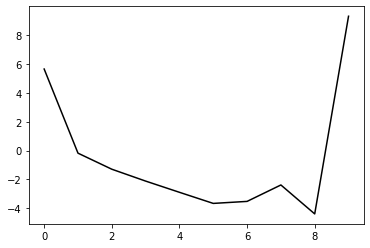

135300 28.82447390635657
1.5854940841707044 1.3507859188742342 0.4833301373500205 -0.5969286501938044
[ 5.67616732 -0.14646514 -1.26904396 -2.09743756 -2.87979343 -3.64905024
 -3.5039263  -2.37122296 -4.38877462  9.38817224]


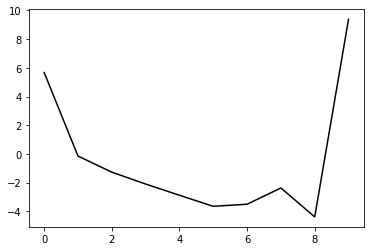

136400 32.430382776191664
1.6291577041517953 1.3590918772563823 0.47431731723853854 -0.6239921949404077
[ 5.8866808   0.03373952 -1.08264014 -1.89499541 -2.65589304 -3.39298548
 -3.19700651 -1.99413836 -3.95495723  9.31247945]


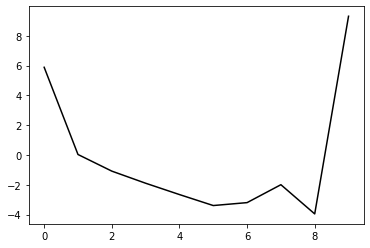

137500 39.97234307232129
1.655207684282304 1.3822288970798449 0.47107726351419243 -0.642574688684303
[ 6.00058956  0.1597609  -0.95860096 -1.76393152 -2.51601249 -3.24101719
 -3.02894738 -1.80734624 -3.75543654  9.41485077]


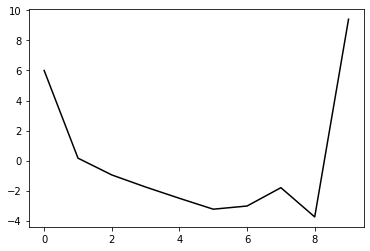

138600 32.407159472448626
1.6010290842892654 1.376724363742461 0.4878566710119611 -0.6165876105763011
[ 5.78321637 -0.03371103 -1.18093262 -2.0159343  -2.80548863 -3.5804072
 -3.44981428 -2.35905181 -4.42239367  9.30646639]


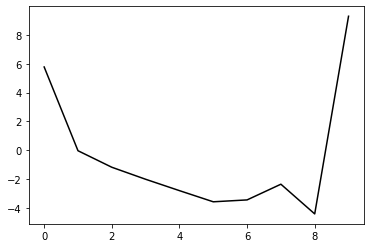

139700 37.23788439194789
1.6462135608676174 1.399937302618384 0.48959530003431506 -0.6334344944192067
[ 5.97265756  0.04137887 -1.09659409 -1.91133592 -2.67360143 -3.40899937
 -3.21708265 -2.04300291 -4.04507554  9.4115698 ]


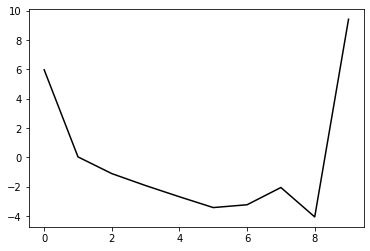

140800 40.8940610260292
1.6310719885654748 1.3572224319680737 0.4823617256329392 -0.6384926057975469
[ 5.67115563  0.12634393 -1.03054605 -1.86057535 -2.63867045 -3.38959749
 -3.21557549 -2.06582727 -4.09810372  9.30680843]


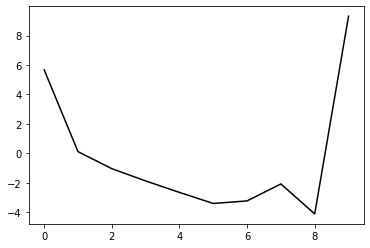

141900 38.1200903378877
1.6276480455083484 1.3316460870299631 0.4757155219854306 -0.6474778493521106
[ 5.67013014  0.13923322 -1.03520457 -1.87764239 -2.66793479 -3.42935851
 -3.26387837 -2.11853475 -4.14873206  9.36353081]


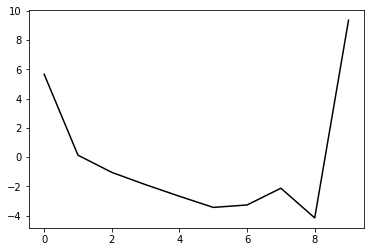

143000 29.027108345431778
1.5699737096128714 1.2991319541122481 0.4701338649662909 -0.6440990247315468
[ 5.50567491  0.06960007 -1.12987728 -1.99795637 -2.82112179 -3.62652364
 -3.53314269 -2.51093157 -4.67288664  9.3171266 ]


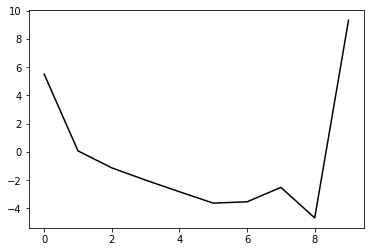

144100 31.184694722034596
1.6345255825561342 1.3413663128033366 0.4902187911611766 -0.6439029505834464
[ 5.84500497  0.03929703 -1.15094239 -1.99891148 -2.7931816  -3.55229538
 -3.37672493 -2.22986839 -4.30259365  9.29849229]


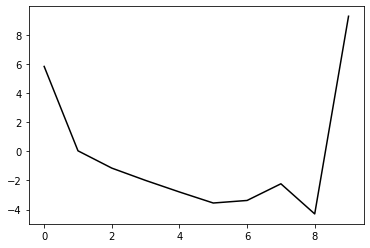

145200 41.530893672377296
1.6108135010894553 1.3705669296913758 0.5132616619708699 -0.6193598061219617
[ 5.80236431 -0.04352743 -1.24484556 -2.10364787 -2.91462076 -3.6989746
 -3.56761182 -2.48137399 -4.5733582   9.33183948]


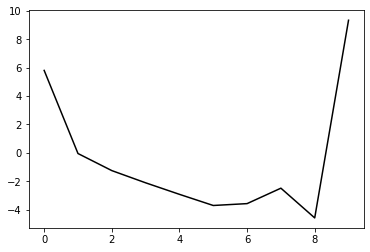

146300 29.519799548690123
1.5919632036401847 1.3365050696254253 0.4861119243513521 -0.6520706933331909
[ 5.61684297  0.16800291 -1.04926924 -1.92231827 -2.75041314 -3.5536032
 -3.44777395 -2.4074507  -4.56896067  9.35654808]


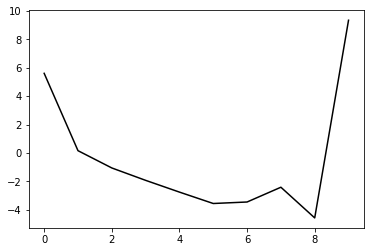

147400 34.09695225465452
1.6047516498935557 1.3423164401925038 0.48175633107533566 -0.668834354992597
[ 5.73509804  0.21057192 -1.00558179 -1.87115439 -2.68774999 -3.46919141
 -3.32092337 -2.2152475  -4.34080446  9.36792227]


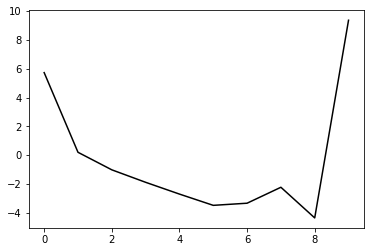

148500 36.10776852238223
1.6406716145634102 1.3597096552962713 0.4964721112381233 -0.6635886117889852
[ 5.83236066  0.15605458 -1.06803351 -1.9349993  -2.75024064 -3.52341857
 -3.35412505 -2.20695867 -4.27787383  9.35167248]


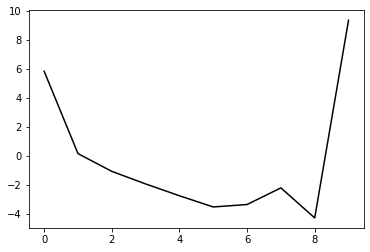

149600 33.14374694438544
1.6501718442281468 1.3551878223688323 0.5028766982726142 -0.6590794466557331
[ 5.81033137  0.11576345 -1.12184758 -1.99615717 -2.81767831 -3.59321474
 -3.4207677  -2.2645152  -4.32328867  9.22579542]


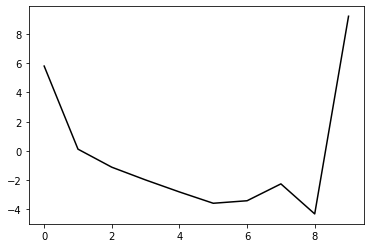

150700 41.5226964891876
1.6643914682305938 1.3949795661766557 0.5341182717924156 -0.6383451801630806
[ 5.91558292 -0.03719036 -1.28450235 -2.16619997 -2.9953781  -3.77526978
 -3.60181306 -2.43348848 -4.4651041   9.35439798]


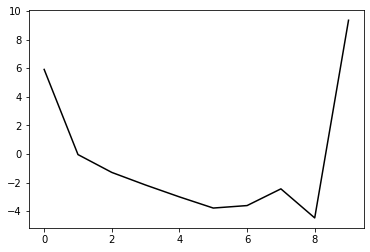

151800 36.05352960260676
1.6486574892209425 1.4017593715762942 0.530324716666083 -0.6528907683513316
[ 5.83820309  0.07627927 -1.18214827 -2.07346259 -2.91421355 -3.70749204
 -3.55546868 -2.42664328 -4.50992701  9.32163231]


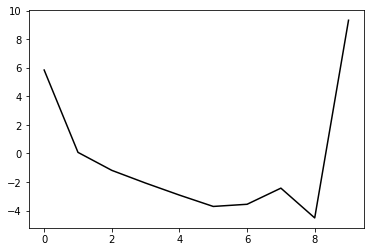

152900 45.10778662759175
1.6352088788186134 1.411129621843868 0.5342773668661378 -0.6496557375199622
[ 5.72762942  0.06262851 -1.20960563 -2.11602025 -2.97807836 -3.80033551
 -3.69111173 -2.61069075 -4.70485688  9.41154237]


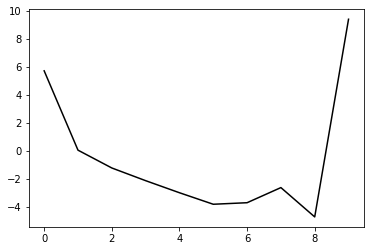

154000 30.40462301917425
1.6031872451192855 1.3891276999616913 0.514349319824962 -0.6685740723647285
[ 5.6600118   0.15119138 -1.13459065 -2.05303104 -2.9306808  -3.77117834
 -3.68480428 -2.62497338 -4.72524011  9.32720656]


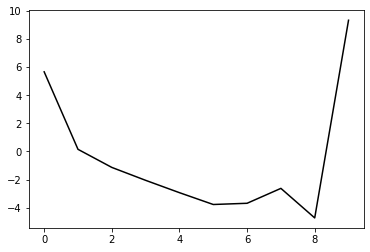

155100 32.5995387167956
1.6058171292926726 1.3775484370504971 0.5035984825769417 -0.6855624888628471
[ 5.76984388  0.17519187 -1.12250541 -2.04789097 -2.93217737 -3.77545372
 -3.68774558 -2.63151213 -4.74114421  9.35064659]


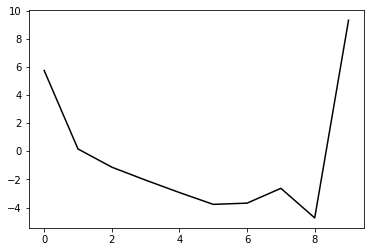

156200 41.06251791379718
1.5768974149933106 1.3803253833243583 0.5072625500046964 -0.6836641308896253
[ 5.67554523  0.16987163 -1.14308213 -2.08502539 -2.99240314 -3.86786336
 -3.83848629 -2.90190585 -5.10566362  9.24516062]


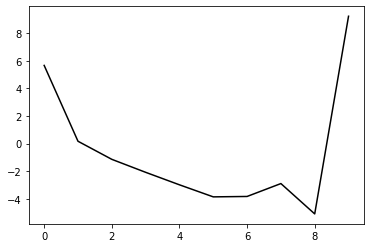

157300 29.226908742278365
1.611396899779362 1.4129254681978567 0.5151416546575656 -0.6903290015518192
[ 5.74910279  0.31045823 -0.9973348  -1.92814486 -2.82067717 -3.67032894
 -3.58761236 -2.55714398 -4.74805402  9.3375989 ]


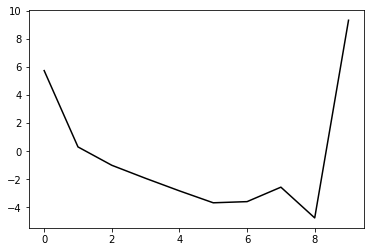

158400 33.46231941201124
1.6127783373449882 1.4155475148738537 0.5236501420579391 -0.6827508494236607
[ 5.74875722  0.24019075 -1.08332873 -2.02564908 -2.93087673 -3.79277272
 -3.71975497 -2.6797007  -4.82733124  9.31886282]


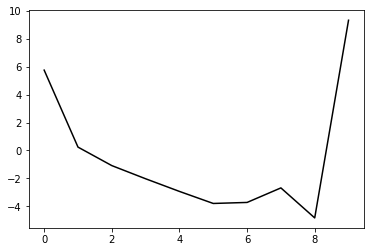

159500 34.9047771471033
1.617123410903629 1.4062805145051849 0.5164271112041819 -0.6939716635846193
[ 5.69131153  0.27665301 -1.06091844 -2.01348776 -2.92875968 -3.79561016
 -3.71632167 -2.64659465 -4.74563458  9.37845633]


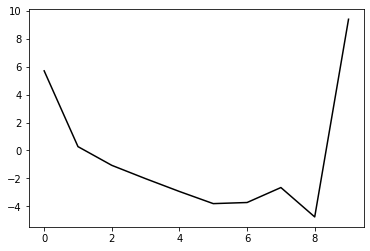

160600 33.11662383483146
1.6316738000489606 1.4173619030528106 0.5236090822109823 -0.6942709476979492
[ 5.82549913  0.23318602 -1.11207322 -2.06765958 -2.98474167 -3.84838015
 -3.75627151 -2.65682305 -4.70810636  9.32170118]


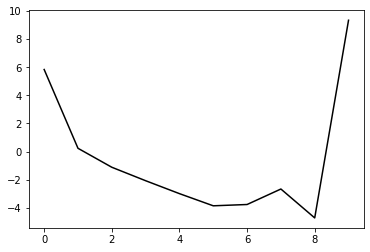

161700 35.9549363938175
1.6392617528966424 1.4150444132591493 0.535186471716429 -0.6835215190783008
[ 5.80341996  0.12127335 -1.24180238 -2.21199505 -3.14448078 -4.02135348
 -3.93810638 -2.83832462 -4.87354901  9.32299468]


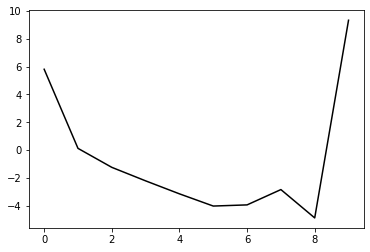

162800 41.193447261091066
1.646701730171169 1.4488964598496281 0.5524229939735764 -0.6715723300187252
[ 5.89581878  0.08172789 -1.27949783 -2.24504117 -3.17311847 -4.04098049
 -3.93845237 -2.81186023 -4.82835617  9.24170866]


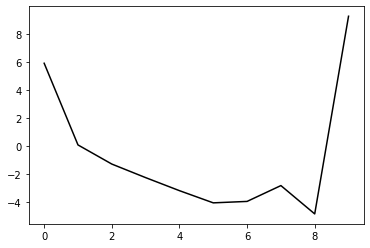

163900 39.93471421563741
1.5982108264272914 1.4353032794331628 0.5264310298860381 -0.6968066772039117
[ 5.62468342  0.36290695 -1.01545802 -2.00277208 -2.9651786  -3.88390535
 -3.87009512 -2.89130079 -5.02620217  9.32513135]


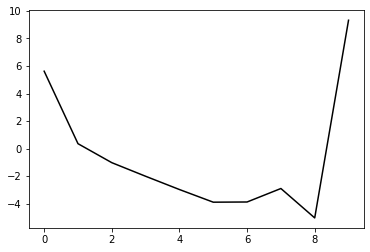

165000 30.941460133608977
1.6626299170263552 1.4781539369319843 0.5434584455447338 -0.7041903036187743
[ 6.04503154  0.36792047 -0.99234234 -1.94899425 -2.87076931 -3.73192688
 -3.6304124  -2.54137622 -4.59513079  9.33424991]


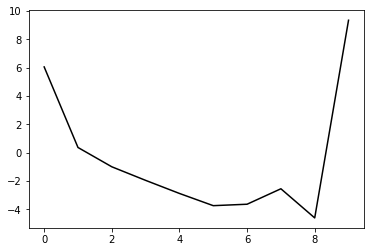

166100 31.028176568801143
1.637730605138145 1.4613812415117564 0.5355419639608053 -0.7091592220911886
[ 5.86428908  0.30375753 -1.08458114 -2.06683102 -3.01792841 -3.91095969
 -3.8466433  -2.79118417 -4.84435602  9.22025961]


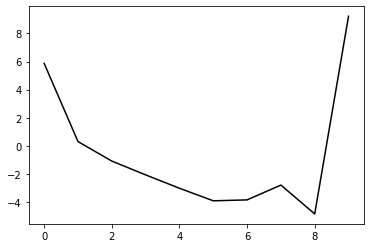

167200 40.48668874682737
1.632266294648173 1.4382523237933114 0.5319254173918172 -0.7096230160040445
[ 5.77706893  0.28701062 -1.12600506 -2.12944823 -3.10375869 -4.01947083
 -3.97665535 -2.93903803 -4.99549097  9.31467784]


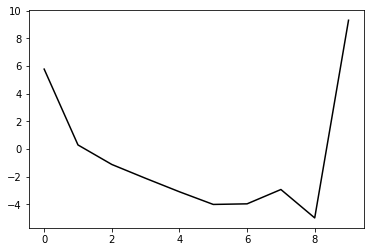

168300 28.859726609814604
1.662948586650929 1.435004064035174 0.5330869071877236 -0.7157508894869665
[ 5.90133579  0.36109621 -1.05887105 -2.06058024 -3.02987919 -3.93259686
 -3.86170984 -2.77666804 -4.77894031  9.31628792]


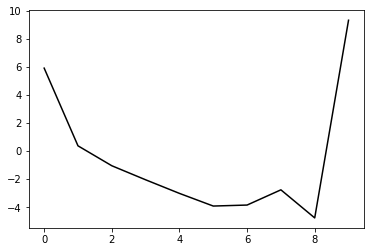

169400 33.59214113903258
1.628615223753514 1.4117183869049548 0.5373846598642524 -0.7116987637509243
[ 5.78863425  0.35978089 -1.07945159 -2.09715201 -3.08491705 -4.01040671
 -3.97631116 -2.94906645 -5.00096519  9.2663506 ]


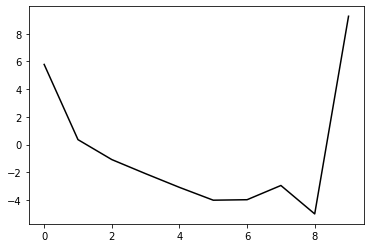

170500 38.99601550816232
1.583150471790674 1.391125123122714 0.5403637324733032 -0.6960330604603279
[ 5.51503902  0.30181896 -1.16665341 -2.21627317 -3.2434344  -4.21756678
 -4.24767621 -3.29203357 -5.38624897  9.31345361]


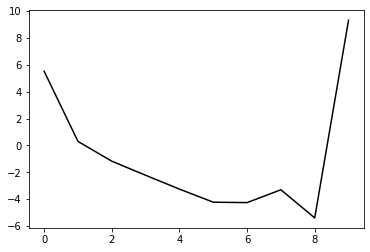

171600 33.453425372278545
1.643136109076922 1.4224489069634116 0.5359519110284443 -0.7215673673724526
[ 5.73418215  0.47882465 -0.9764756  -2.00736745 -3.01288535 -3.95429079
 -3.93194901 -2.91795289 -4.97528672  9.29528336]


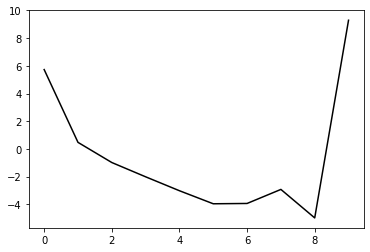

172700 38.0419385543977
1.650413376833208 1.4580906309827353 0.5630966600313564 -0.7028129356211894
[ 5.909794    0.30958118 -1.15330253 -2.19118642 -3.20592124 -4.15432446
 -4.13095575 -3.08912499 -5.08244526  9.36820155]


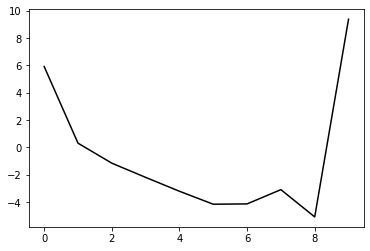

173800 41.06396965525647
1.6452049120410126 1.4251988887103344 0.5328594733756721 -0.7420402523038433
[ 5.85435255  0.55776479 -0.91586251 -1.95955675 -2.97953171 -3.92979712
 -3.90785895 -2.89524633 -4.9652565   9.30392483]


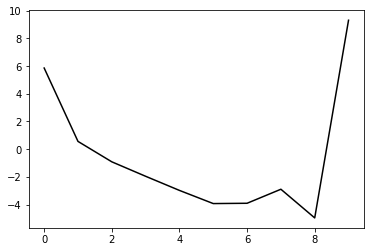

174900 38.94856375375314
1.6859380506460935 1.45220409379417 0.5517228026351381 -0.7337047076474638
[ 6.02254858  0.55089922 -0.92482608 -1.965153   -2.97954567 -3.91688965
 -3.86639103 -2.80157262 -4.80691313  9.31340669]


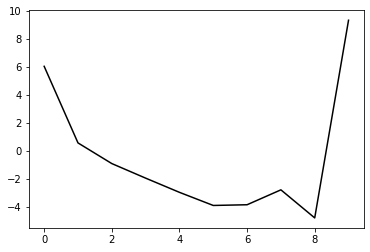

176000 30.04996477811507
1.685892679369153 1.4312435652338857 0.5356131230301912 -0.7541598636786818
[ 5.93854747  0.59552454 -0.90131325 -1.95934895 -2.99281167 -3.94807467
 -3.91412802 -2.8636899  -4.87064285  9.40556223]


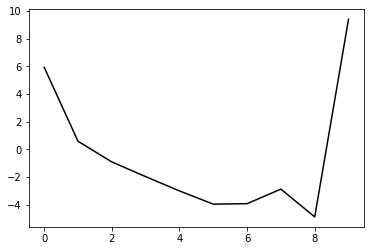

177100 34.12325422953572
1.6862643200458156 1.458710187174921 0.5438534620907001 -0.7525948619460624
[ 5.99273375  0.61065779 -0.89251181 -1.95495882 -2.99495167 -3.95714893
 -3.93111412 -2.88859463 -4.89129083  9.32275584]


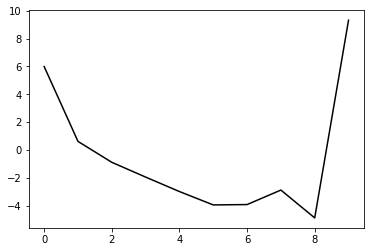

178200 41.038548262780736
1.6810882477442106 1.4603555296366226 0.5696566162516198 -0.7237424715701771
[ 5.85278043  0.41022998 -1.11488148 -2.19394775 -3.25037356 -4.22670534
 -4.21009174 -3.16686159 -5.15392578  9.30877436]


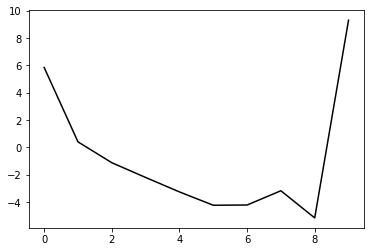

179300 28.730134670633706
1.6442894012230842 1.465473556777251 0.569143228053445 -0.7298739539298865
[ 5.8407683   0.45636115 -1.08408165 -2.18070682 -3.26079226 -4.26878837
 -4.30719076 -3.35535319 -5.38329573  9.31760665]


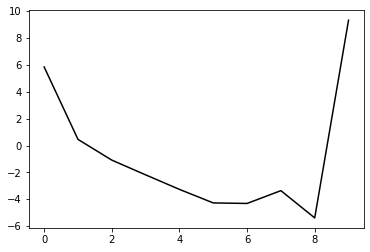

180400 33.34032417884304
1.6609036979538865 1.4809696439687823 0.570610390972941 -0.7358788428466837
[ 5.87755809  0.49781846 -1.0432049  -2.13723129 -3.21374052 -4.21209953
 -4.22631289 -3.23426106 -5.2372885   9.29460872]


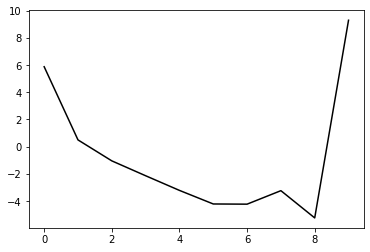

181500 37.51616865881413
1.5962851337202655 1.4614813395557988 0.5525602459871857 -0.7444054856570079
[ 5.52267646  0.60659251 -0.96203824 -2.09049786 -3.21320446 -4.27089005
 -4.36679162 -3.47241112 -5.53636896  9.30241369]


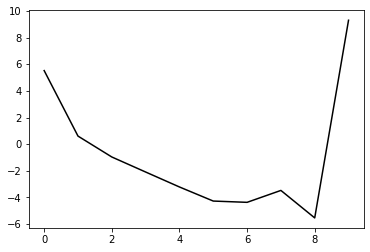

182600 33.43352612437778
1.6075490433056092 1.4836474027223885 0.5567702987226101 -0.7495528412060475
[ 5.65006403  0.64460226 -0.92906426 -2.06273599 -3.19295745 -4.25548382
 -4.3467398  -3.43183362 -5.46509966  9.20510874]


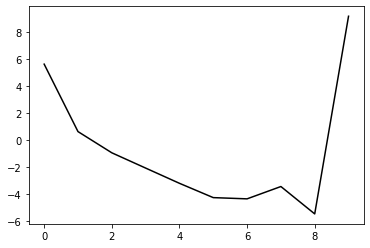

183700 33.8405733339669
1.63197740703508 1.5022985536992373 0.5677116827289246 -0.7488115901350569
[ 5.85960178  0.62981881 -0.9477606  -2.08359883 -3.21586086 -4.27316978
 -4.34007173 -3.38061232 -5.3608244   9.29768589]


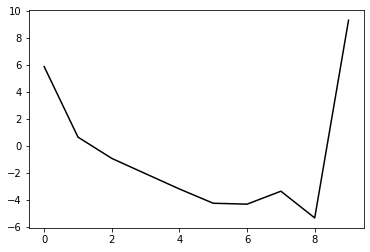

184800 40.07091926333991
1.683878921413353 1.5281138351414871 0.5661951128575252 -0.7731125476731818
[ 6.00880147  0.74257706 -0.82736082 -1.94891101 -3.06171266 -4.08899531
 -4.10987665 -3.10158541 -5.07740329  9.3112105 ]


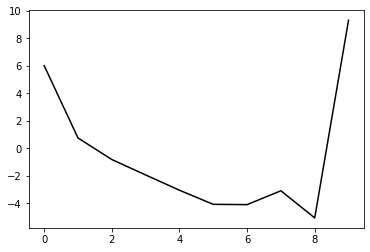

185900 38.2222144975901
1.671624365787744 1.5530886428344828 0.5708195608568246 -0.7779476973178239
[ 5.9644395   0.8438514  -0.72938985 -1.85478515 -2.97382048 -4.00772466
 -4.03845404 -3.05873823 -5.09856889  9.35004579]


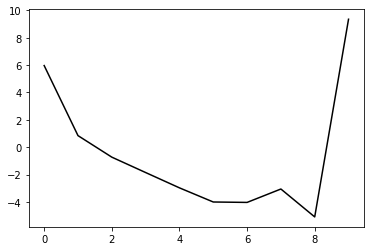

187000 31.72785012925564
1.6842921498610555 1.5706835103316126 0.5862296504125813 -0.7685392172572775
[ 6.06683193  0.7433001  -0.83687937 -1.96738314 -3.09240647 -4.13087787
 -4.16193293 -3.16914594 -5.15311368  9.30412361]


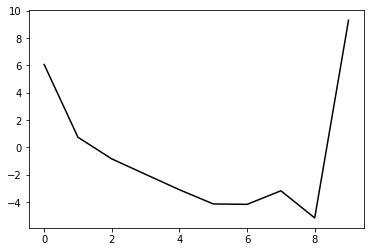

188100 29.65054957442756
1.6821133981407148 1.5649226196006063 0.5888013917320098 -0.7667997585387668
[ 5.94473716  0.69129924 -0.90919532 -2.05941022 -3.20739838 -4.26876383
 -4.32128266 -3.3452687  -5.32046024  9.44076565]


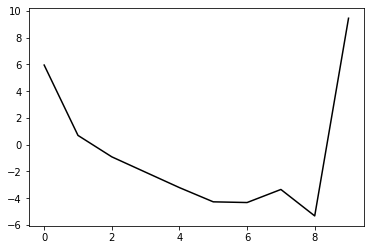

189200 41.28861967482785
1.6787930378669087 1.5417934049556143 0.5747254092688288 -0.7849595804278567
[ 5.78296785  0.80212926 -0.80888069 -1.96217178 -3.11053738 -4.17010412
 -4.22151414 -3.25218672 -5.25209339  9.29540715]


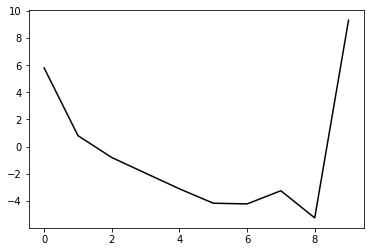

190300 29.149570231505404
1.699113723002954 1.5613802386503977 0.5895362977873108 -0.7769712698127338
[ 5.90263878  0.74940156 -0.86666779 -2.01951612 -3.16554475 -4.21862565
 -4.25573253 -3.2571552  -5.21711837  9.32562944]


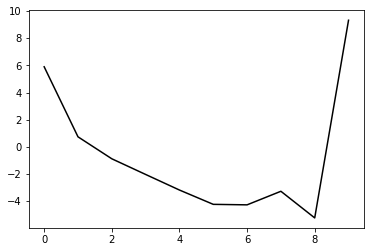

191400 33.57808733965688
1.6701898670154476 1.552964531813998 0.5974817228973879 -0.7691326460808856
[ 5.7460794   0.71782871 -0.91820807 -2.08891591 -3.25491663 -4.33086719
 -4.40211406 -3.4649126  -5.51031561  9.25574179]


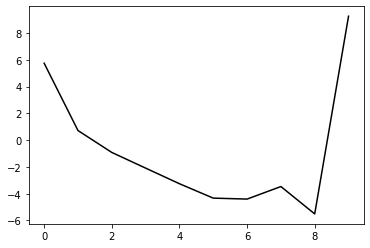

192500 36.977053954892966
1.6453177936755858 1.5365393940348502 0.5680359969021288 -0.8048463135609603
[ 5.72142428  0.84291926 -0.79804008 -1.97611944 -3.15324559 -4.2412627
 -4.32505251 -3.40712368 -5.47873974  9.30272137]


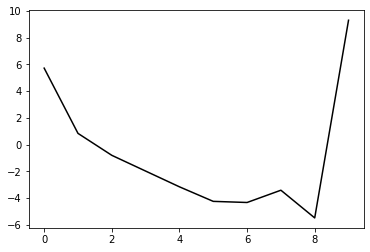

193600 31.686933574970674
1.70192216891831 1.5684341986637453 0.5945748882525608 -0.7878455142409757
[ 5.98005553  0.78018041 -0.8605208  -2.03292096 -3.20088739 -4.27117406
 -4.31684127 -3.3244625  -5.30222523  9.28617147]


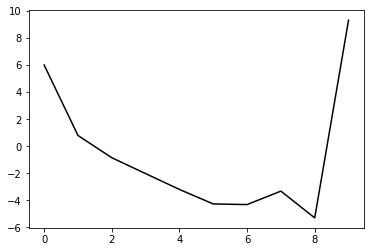

194700 37.16310951438281
1.6344965122122193 1.5729234388087099 0.599288246383611 -0.77545946785105
[ 5.81484279  0.67391456 -0.9926123  -2.19934382 -3.4149986  -4.5500734
 -4.68797161 -3.78125117 -5.74944641  9.35241177]


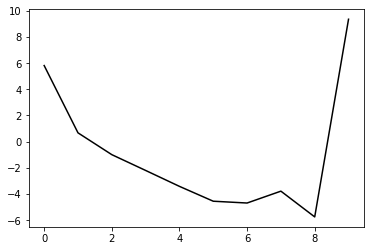

195800 37.81374799328304
1.6692922516534718 1.6166592410117786 0.616771471515384 -0.7733543607466858
[ 6.00179044  0.68059384 -0.9760792  -2.17313027 -3.37807584 -4.49154587
 -4.57673375 -3.58259572 -5.51424453  9.28143063]


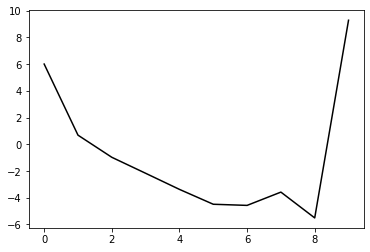

196900 39.31073583155441
1.6893197247467373 1.615126915971622 0.6022980441773013 -0.8011655368452177
[ 6.21901662  0.91504046 -0.73935044 -1.93189423 -3.13177559 -4.2352262
 -4.30212555 -3.30113638 -5.25674437  9.29263991]


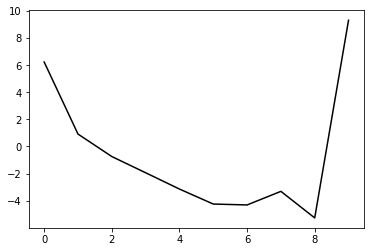

198000 28.59410748243996
1.63929618646902 1.6046693677621615 0.5908077493139761 -0.8111623507000378
[ 5.84815491  0.93096943 -0.73972585 -1.95364816 -3.18452851 -4.33107063
 -4.46844515 -3.5836599  -5.61910044  9.2881016 ]


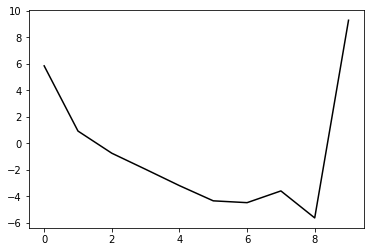

199100 35.7762485502604
1.6933432341951675 1.646106339012293 0.5960265254496534 -0.8268649654010087
[ 6.20608803  1.01243573 -0.63719025 -1.82242039 -3.01651269 -4.11056228
 -4.16561113 -3.18809222 -5.2108639   9.30464987]


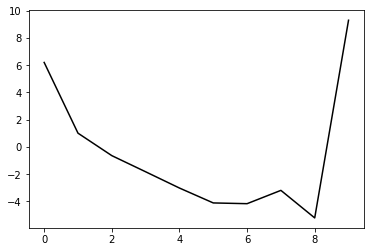

200200 40.35760857301572
1.6625794814408854 1.6244310219584823 0.6111479104790456 -0.7981008498983495
[ 5.80724914  0.78764872 -0.90293513 -2.12338214 -3.35523392 -4.4916748
 -4.59874747 -3.67309289 -5.70232543  9.23893433]


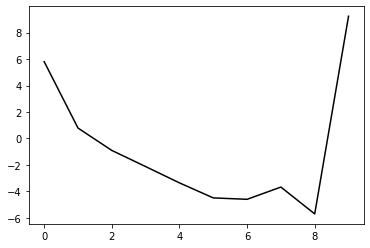

201300 29.295637228389364
1.672044246521616 1.5992178202099252 0.5860159548598922 -0.8268666639414699
[ 5.72515025  0.96486505 -0.74181872 -1.97429929 -3.21921231 -4.3668811
 -4.48066695 -3.55936338 -5.59090726  9.29414859]


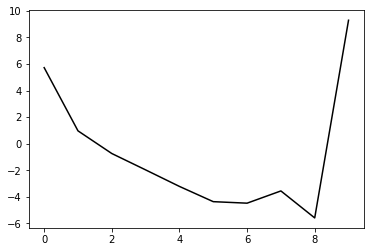

202400 33.20452499682765
1.6678458161656189 1.59825887726381 0.6073950736106487 -0.8003232226590501
[ 5.77135286  0.79404207 -0.93252431 -2.17587442 -3.42920715 -4.58201922
 -4.69442094 -3.75734885 -5.75401068  9.25638337]


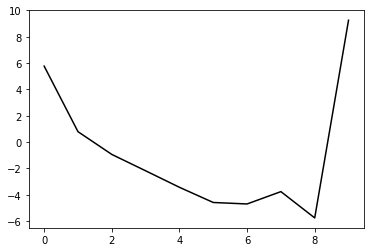

203500 37.54280237661987
1.6555576212005272 1.6014135671245462 0.6047145613956676 -0.8129586633815754
[ 5.92701738  0.87975208 -0.85466303 -2.1082811  -3.37664095 -4.54749908
 -4.68768101 -3.80270301 -5.81948666  9.32117004]


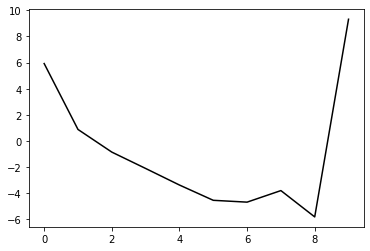

204600 33.408382731516454
1.6368551313799375 1.5990915933654875 0.5958718850457078 -0.8276820666079785
[ 5.87761853  0.92144614 -0.82108179 -2.0843734  -3.36640275 -4.55415029
 -4.71931063 -3.88633832 -5.93955146  9.26357649]


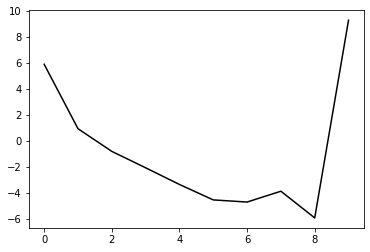

205700 36.187879339691165
1.6628750485880304 1.6262122772186143 0.617784780685201 -0.8121301680303923
[ 5.98993772  0.82436766 -0.92725236 -2.20267818 -3.50126491 -4.70458645
 -4.87317676 -4.01874675 -5.99611796  9.28807318]


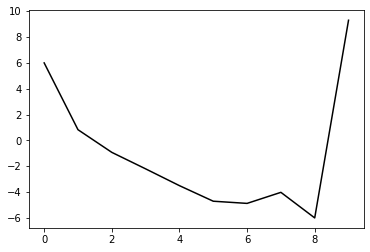

206800 36.61566554310284
1.6993774518272193 1.6864123408378715 0.6380826079610199 -0.8112525527586616
[ 6.205589    0.86458332 -0.86754271 -2.1253549  -3.40480876 -4.57626091
 -4.67979216 -3.73617906 -5.71120851  9.24088741]


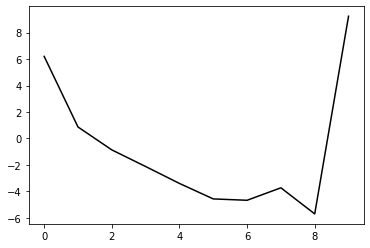

207900 39.28136777897881
1.7119796395303166 1.6750333138666582 0.6207191141641197 -0.8389493886264417
[ 6.31238861  1.05824449 -0.67935964 -1.94213025 -3.22820837 -4.40434031
 -4.50751993 -3.56747188 -5.56308432  9.36077949]


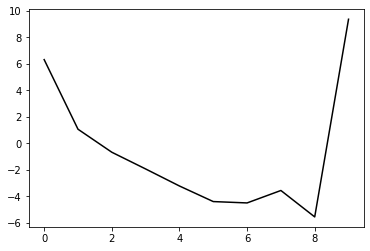

209000 31.67189103926694
1.7304308301993685 1.701734793877523 0.6408997038010159 -0.8247732058931543
[ 6.16055657  0.94180279 -0.80227805 -2.07017443 -3.36282523 -4.54481634
 -4.65020234 -3.70349282 -5.66977551  9.28018079]


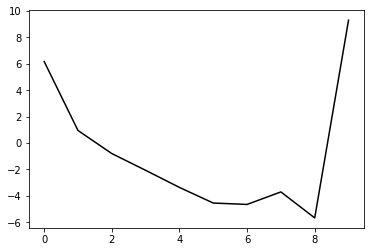

210100 27.904107125584517
1.7069649258677768 1.7021625788482022 0.6432305142085137 -0.8257455958537846
[ 6.15342427  0.94926477 -0.81189893 -2.09776831 -3.41249087 -4.62002907
 -4.75581251 -3.83949841 -5.80878041  9.27567614]


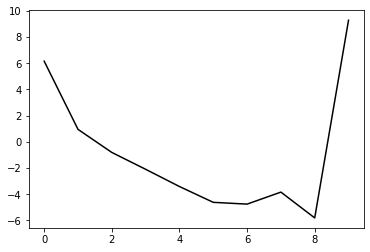

211200 40.964824541605715
1.6803156324958681 1.6692951141531862 0.6246917778042641 -0.8443520108027174
[ 5.94547164  0.97730731 -0.80028679 -2.09740638 -3.42299539 -4.64194557
 -4.79730322 -3.93027122 -5.96427447  9.21170665]


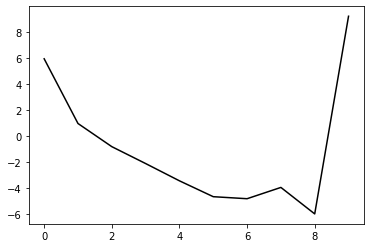

212300 28.753914279806306
1.6532428302994722 1.6540873055834027 0.6304750394043811 -0.8358439925518802
[ 5.93878265  0.93064279 -0.86778867 -2.18526907 -3.53364159 -4.77665606
 -4.9568472  -4.11512616 -6.16620458  9.28092694]


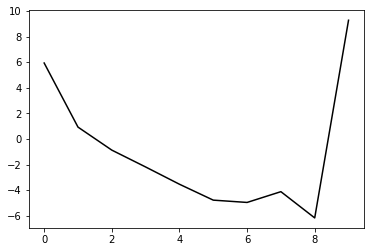

213400 32.80379225391442
1.636630296433151 1.6620336245209673 0.6284000253478618 -0.8432736166887581
[ 5.92820771  1.00131606 -0.80413381 -2.13096753 -3.49321681 -4.75418295
 -4.96140354 -4.17118698 -6.26667666  9.25408889]


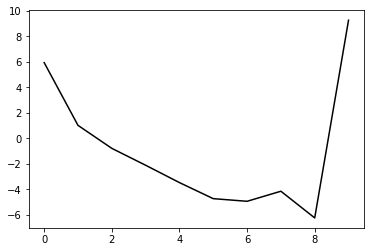

214500 37.56876265320837
1.643434900929129 1.650513595260079 0.6247827076157003 -0.8521505613913689
[ 5.94866012  1.03776774 -0.77904769 -2.1150305  -3.48695369 -4.75462246
 -4.95873289 -4.1516354  -6.24600232  9.32650361]


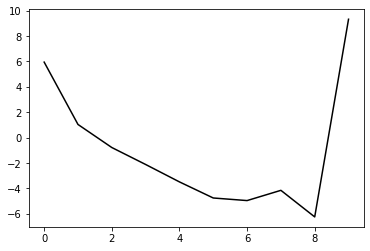

215600 33.16877269099882
1.6538785110302232 1.6795750326034076 0.6224116249870671 -0.8669064551115078
[ 6.06245096  1.12200326 -0.68598877 -2.01467769 -3.3810788  -4.64161361
 -4.832655   -4.01134323 -6.1014969   9.23851739]


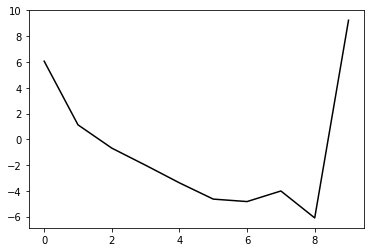

216700 35.4603018187123
1.6567290909083598 1.6903501051299936 0.6393786352659445 -0.8509742186629743
[ 5.966981    0.99170706 -0.83318228 -2.18065997 -3.57043269 -4.8564029
 -5.07021068 -4.26300618 -6.3170897   9.26416094]


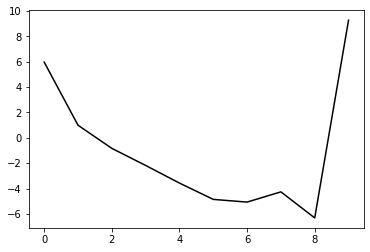

217800 36.294122994191085
1.6674450134612928 1.7216213981526598 0.6526382920937647 -0.8461774329538589
[ 6.0964107   0.99384301 -0.82716634 -2.17423112 -3.56690303 -4.85388267
 -5.05599826 -4.2157172  -6.23455672  9.22606271]


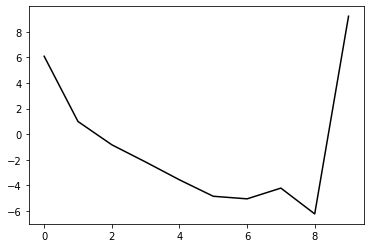

218900 41.251931219915654
1.6559596548646018 1.7429976266584382 0.6525949988502372 -0.8544060528091584
[ 5.97497135  1.17780071 -0.64894781 -2.00878543 -3.42269541 -4.73761749
 -4.97927738 -4.21642896 -6.31462164  9.35690027]


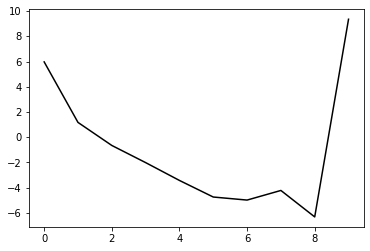

220000 30.344623228500698
1.6213415514714957 1.7453013486536895 0.6407872069288542 -0.8688855591630401
[ 5.81230062  1.28764177 -0.54715842 -1.92535655 -3.37098464 -4.73238651
 -5.04158784 -4.34394651 -6.42342882  9.21444177]


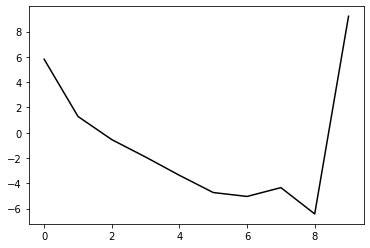

221100 28.85530606209977
1.611488938254743 1.7527473799360354 0.6481619828502186 -0.8620685812199114
[ 5.83509779  1.22370072 -0.62619787 -2.02233568 -3.49027005 -4.87654184
 -5.20405637 -4.48389531 -6.505201    9.26448275]


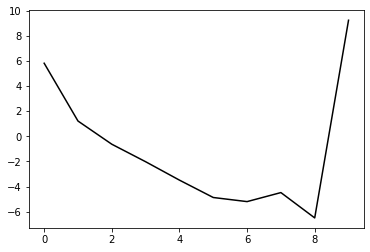

222200 40.397060543607594
1.6309188540610449 1.7869928014616798 0.6717856676455661 -0.8438850525629069
[ 5.92282241  1.17283415 -0.67676386 -2.07591668 -3.54996505 -4.93801108
 -5.24735596 -4.48935843 -6.48027261  9.2314723 ]


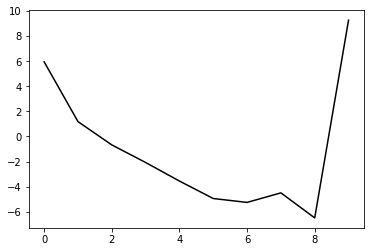

223300 28.464878332668608
1.5773037942498327 1.762622765761073 0.6510936693750151 -0.8633008609126683
[ 5.78001609  1.26717341 -0.60421595 -2.03241176 -3.54628343 -4.98900088
 -5.37880695 -4.72149525 -6.73719039  9.25936695]


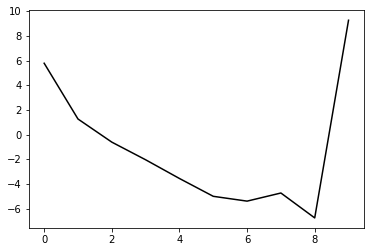

224400 33.20862400905202
1.6551182199933547 1.793067969767861 0.6635660942264137 -0.8695916411699135
[ 6.09029658  1.33859522 -0.51523224 -1.92214158 -3.41078767 -4.81467719
 -5.13075422 -4.37458244 -6.3392072   9.19377176]


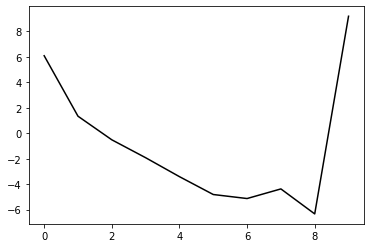

225500 35.720442093919644
1.6155285103817993 1.7599364072572252 0.6400654942382609 -0.8965534840125978
[ 5.69237362  1.49351373 -0.38177843 -1.81442566 -3.33584603 -4.77851293
 -5.14329647 -4.46854335 -6.5496658   9.22739562]


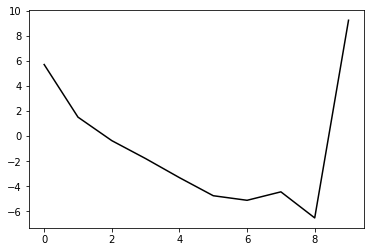

226600 32.190908774215366
1.6378381034098155 1.8019778482988889 0.6600369353146491 -0.890705867153996
[ 6.00432914  1.47944858 -0.3864052  -1.81250606 -3.32847858 -4.76230307
 -5.10528734 -4.38039728 -6.39421179  9.27591818]


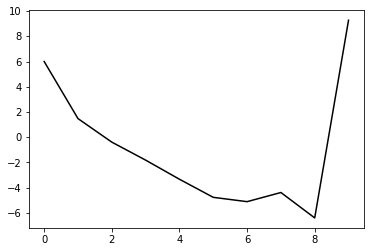

227700 36.139139008571846
1.692143476916426 1.8461534294774335 0.6887837143369183 -0.8734164744192046
[ 6.14044572  1.40368998 -0.4584849  -1.8804676  -3.39304727 -4.81883953
 -5.13442949 -4.33923535 -6.24652858  9.24980158]


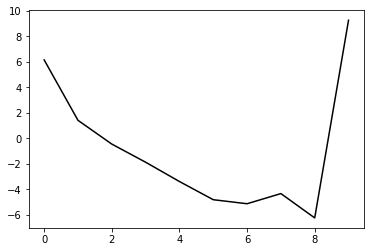

228800 36.58755731570222
1.6664082329589145 1.8268885011189304 0.6867235600925004 -0.8711792711859427
[ 5.98497958  1.39248212 -0.49886286 -1.95152795 -3.50012829 -4.96750052
 -5.32683044 -4.56507826 -6.47168242  9.24140974]


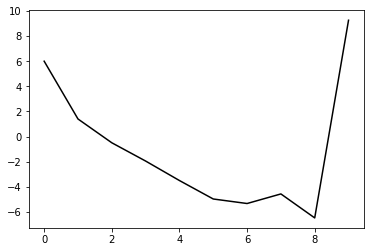

229900 38.22118147651189
1.7087271850540897 1.7939990167508735 0.6508381238717572 -0.9190051014970427
[ 6.16492583  1.61947174 -0.27641338 -1.72857031 -3.27544184 -4.73705193
 -5.07903686 -4.2894449  -6.18042771  9.20430779]


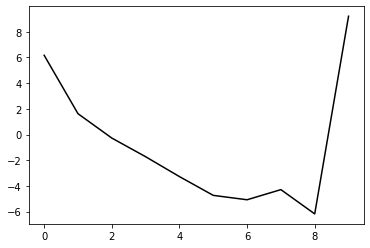

231000 31.154298511165987
1.677010065536086 1.8170428620667833 0.6676714953897863 -0.9029785868382838
[ 5.99861351  1.4924238  -0.4117254  -1.87770603 -3.44570861 -4.93626515
 -5.32239296 -4.60713311 -6.51153943  9.23041537]


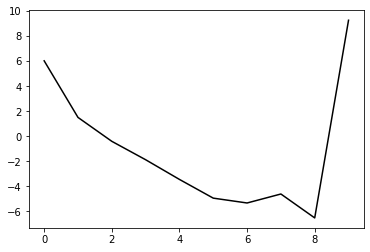

232100 30.75492807207567
1.6718050437590717 1.7879487720220244 0.6542400636442371 -0.9132882159339428
[ 5.84524968  1.50710503 -0.41832646 -1.90296873 -3.49137739 -5.00405391
 -5.40840197 -4.70314777 -6.60719162  9.26272529]


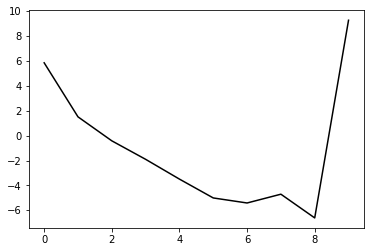

233200 40.12162078048338
1.6965364522268642 1.7930288563961205 0.657754714260976 -0.9191158965654688
[ 6.04400152  1.54619323 -0.38625741 -1.87891921 -3.47807665 -4.99947505
 -5.39832078 -4.6587534  -6.49825525  9.18799274]


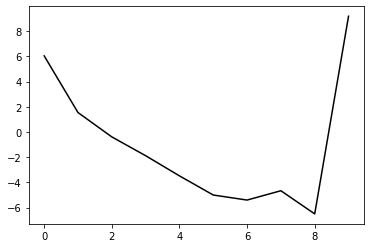

234300 28.59665169847838
1.6706855877369697 1.813152833804932 0.6804399794808575 -0.9033549815791728
[ 5.92047519  1.51074808 -0.42490489 -1.9248858  -3.535973   -5.07144345
 -5.48555422 -4.77506991 -6.66376681  9.29641399]


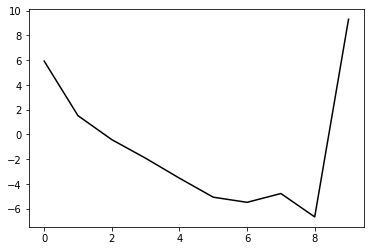

235400 33.589436382281534
1.5710083997624473 1.7965946672468935 0.681165069415854 -0.8915240158023915
[ 5.70772925  1.47730466 -0.48274998 -2.0132632  -3.66082891 -5.24246023
 -5.72356696 -5.10530933 -7.05481093  9.20354955]


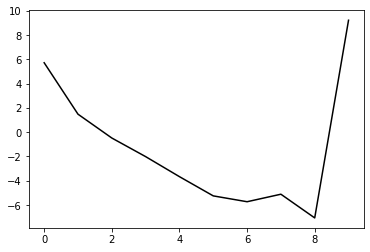

236500 35.300676089786634
1.704219398381506 1.84588369155587 0.6718942340313355 -0.931905801857118
[ 6.11872892  1.79185015 -0.13454996 -1.6343039  -3.25260802 -4.79844037
 -5.21850163 -4.52489617 -6.44716133  9.26026418]


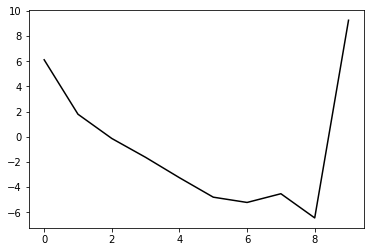

237600 32.97054259980308
1.680583137646786 1.8279709704381422 0.6699286882373885 -0.9281502183789153
[ 5.97170146  1.70699088 -0.2436738  -1.76335484 -3.40293865 -4.97306035
 -5.41825573 -4.74051721 -6.64811019  9.15428726]


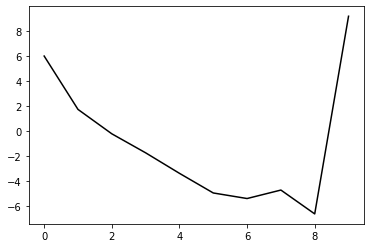

238700 34.32039523268244
1.7167712646698834 1.8451287308205124 0.6885318476235862 -0.9204241917894674
[ 6.12429644  1.65308527 -0.30610888 -1.83416127 -3.48373666 -5.06059117
 -5.494818   -4.76795233 -6.5871723   9.22061993]


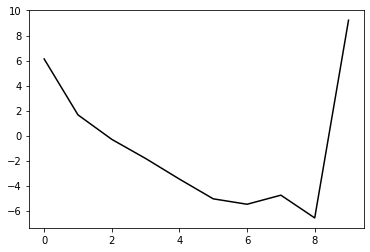

239800 38.45399407676869
1.7558646518108034 1.8524691897250178 0.684024676932623 -0.9364324706915257
[ 6.30781415  1.76454738 -0.19469231 -1.72396483 -3.37695835 -4.95617904
 -5.38316303 -4.62962574 -6.40325093  9.24609218]


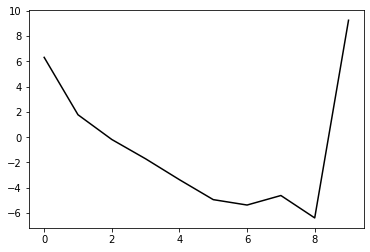

240900 38.7158449784808
1.7600759821758496 1.8174111888044961 0.6712070776223629 -0.9468460597287139
[ 6.16922569  1.76758908 -0.21226343 -1.75130814 -3.41080889 -4.99525195
 -5.42610464 -4.67410362 -6.4393802   9.27206488]


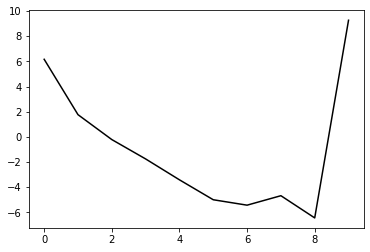

242000 30.411500298655906
1.6820553495630006 1.7986287383124606 0.6749351117421263 -0.9377990584867983
[ 5.87834415  1.66543096 -0.33898853 -1.90345871 -3.59239389 -5.2150946
 -5.70684523 -5.05851925 -6.9104631   9.16148324]


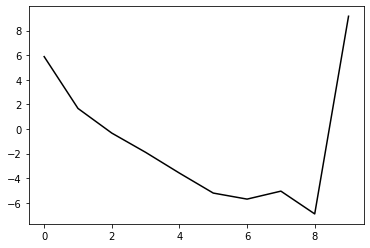

243100 29.195348767114787
1.7222123574156072 1.844366976718174 0.7129060309380714 -0.9082794896887033
[ 6.08403191  1.55574806 -0.44504289 -2.00634963 -3.69155153 -5.30486508
 -5.7641049  -5.03512374 -6.78820055  9.23759033]


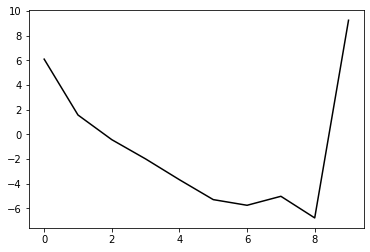

244200 40.65473762139789
1.7619210511240562 1.862737908681366 0.7108028630090765 -0.92135765783966
[ 6.14320295  1.63135263 -0.36774906 -1.92950159 -3.61716559 -5.23046861
 -5.67355858 -4.90460923 -6.63081507  9.24404592]


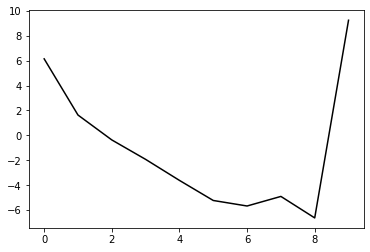

245300 29.26737640179881
1.6864156407486064 1.789171076991354 0.6770988426121025 -0.9428554735737231
[ 5.65321426  1.85794106 -0.1737575  -1.76486354 -3.48522816 -5.14179095
 -5.65406076 -5.01401061 -6.88273629  9.28930377]


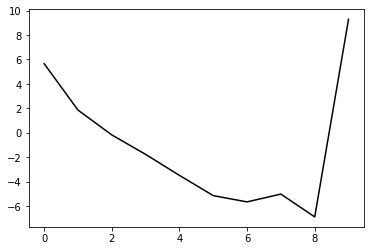

246400 30.91238240225509
1.744750814147844 1.829223454791471 0.6887080162675178 -0.9487175748906487
[ 5.99006893  1.89121535 -0.12921038 -1.71234191 -3.42622863 -5.0722084
 -5.55497013 -4.84912366 -6.62569279  9.22859458]


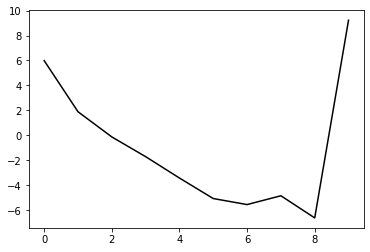

247500 35.40324632790575
1.679394419375424 1.7839936878821019 0.6749086966073428 -0.9563019461400148
[ 5.68436671  1.89439192 -0.14916867 -1.75311747 -3.49000841 -5.16432414
 -5.68647984 -5.04291884 -6.8924501   9.23457415]


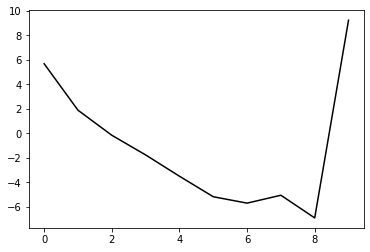

248600 31.101659279043936
1.7784722874213483 1.8350386065025122 0.7075633989138882 -0.9462272776522571
[ 6.20299844  1.84189859 -0.18901088 -1.77776881 -3.49650897 -5.14367803
 -5.61220801 -4.86412904 -6.57766499  9.14455759]


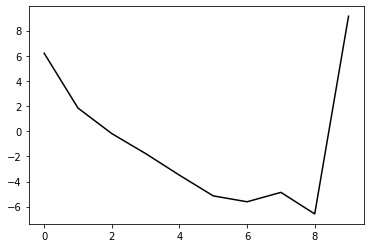

249700 34.63660283095373
1.7367391828461196 1.8508855977705636 0.7164737723880525 -0.9362105513217855
[ 5.98510938  1.85501562 -0.19002792 -1.79872143 -3.54402027 -5.22721196
 -5.7464716  -5.06110926 -6.8007536   9.24813402]


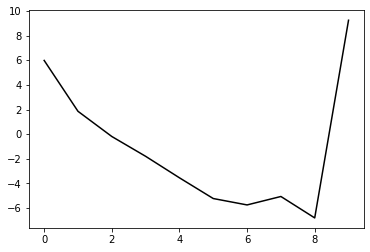

250800 34.902520824453504
1.7527495295707232 1.8895156375200475 0.7326489737279598 -0.9330158735849253
[ 6.09629929  1.90982985 -0.1318182  -1.74609397 -3.5033109  -5.20004294
 -5.71954408 -5.00561825 -6.70254092  9.2181418 ]


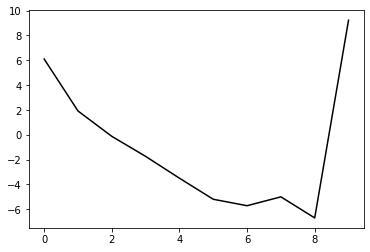

251900 50.437241433573774
1.721475958496122 1.896209185861469 0.7454482340782188 -0.9207885319107375
[ 5.97609174  1.8480885  -0.21187284 -1.84919624 -3.63506134 -5.37015981
 -5.9463593  -5.30697912 -7.02266024  9.23236632]


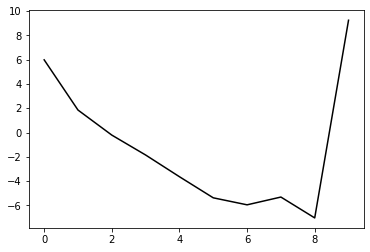

253000 30.93046733024448
1.612568719117354 1.8549435190654149 0.7216361988793726 -0.9288658978118575
[ 5.64234058  1.92949953 -0.16153262 -1.84292442 -3.68381504 -5.49208905
 -6.17435717 -5.64816522 -7.40987841  9.20077157]


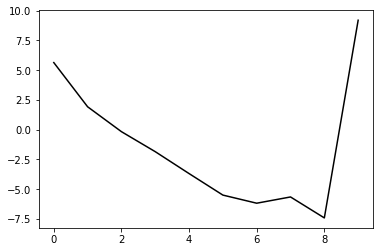

254100 30.33817569034908
1.6833638054983142 1.8883946126870896 0.720226497493551 -0.9534255744476714
[ 5.97170334  2.03245801 -0.03200548 -1.6922959  -3.51388221 -5.29479578
 -5.9143389  -5.29942242 -7.01332052  9.15386863]


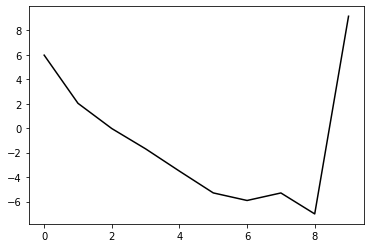

255200 40.45920505532353
1.6403104527291419 1.8656482380352035 0.7108359491934954 -0.9620972916558753
[ 5.86756653  2.06770361 -0.01673578 -1.70179894 -3.55367297 -5.37469
 -6.05305854 -5.53196135 -7.29602901  9.20696489]


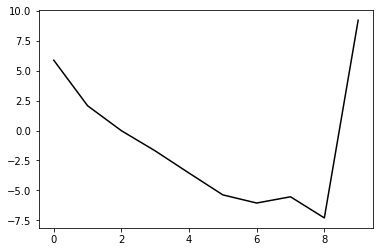

256300 29.02031401981374
1.641610534185188 1.8738586624260527 0.715204026673321 -0.9645210057667508
[ 5.87284995  2.18038862  0.09264562 -1.59891414 -3.45941081 -5.29021826
 -5.97526878 -5.45671453 -7.23165915  9.19193495]


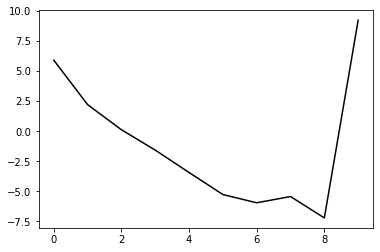

257400 30.898349945602323
1.6968299341675872 1.8950541539671193 0.7222063278087629 -0.9698311950463246
[ 6.17453855  2.21323255  0.13626945 -1.5462601  -3.39788714 -5.21384576
 -5.85539964 -5.22865241 -6.88660923  9.22541399]


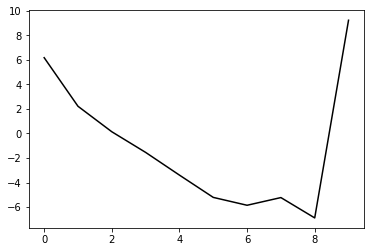

258500 35.475370457762985
1.671785449573791 1.8937424122461153 0.7103060049215804 -0.9855873574333802
[ 5.98384489  2.28537983  0.20855301 -1.47962819 -3.34185401 -5.17416056
 -5.8441232  -5.29084033 -7.04256916  9.21737493]


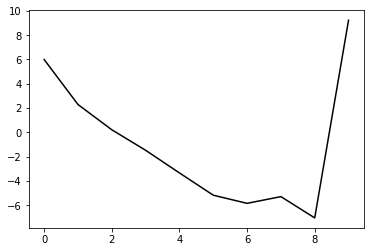

259600 31.878666096793275
1.6899938879449052 1.912212705943814 0.7226651977462456 -0.9808417391191792
[ 6.0944875   2.24392609  0.1640437  -1.53254651 -3.40798739 -5.25557516
 -5.92541925 -5.31114693 -6.94551809  9.26405048]


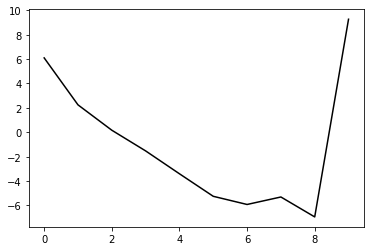

260700 34.159009657747134
1.6254760294019839 1.897725636081336 0.7357412006368074 -0.964849713049359
[ 5.92894074  2.12349341  0.02225265 -1.6976281  -3.59956179 -5.47880208
 -6.18581568 -5.61839303 -7.30492465  9.19607298]


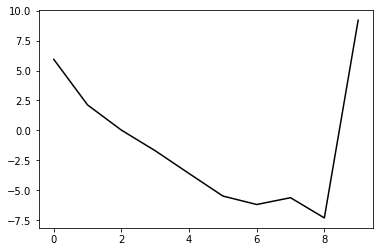

261800 38.75573003400863
1.6676627768986012 1.942366506526388 0.7614462002135556 -0.9521109961990454
[ 6.18533464  2.12037584  0.02926781 -1.68636286 -3.58585313 -5.45964484
 -6.14446705 -5.5066958  -7.0852465   9.23424589]


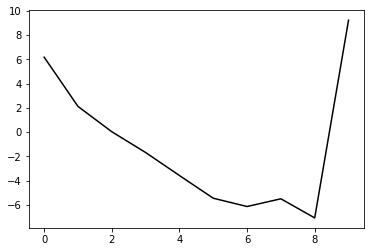

262900 44.490147473323326
1.647004951222125 1.9405593243976458 0.7605280190618718 -0.9605092746848367
[ 6.05714654  2.20341204  0.10172407 -1.63026423 -3.55192567 -5.45563145
 -6.18131246 -5.61993517 -7.29835182  9.20768546]


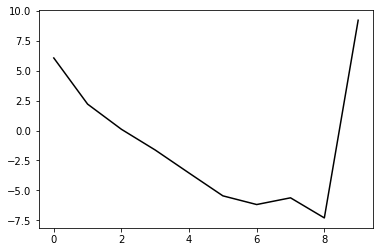

264000 30.01359858517591
1.6732698613828103 1.921080410080408 0.7311059573855614 -0.9976596971946913
[ 6.22358872  2.3916516   0.29867302 -1.42610846 -3.33999684 -5.23257129
 -5.93676125 -5.34618975 -7.03697273  9.22006388]


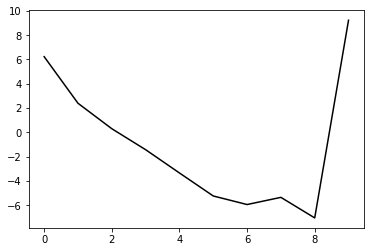

265100 30.226258950003682
1.6218971279247951 1.9130876703320894 0.7368742263443961 -0.987250649101343
[ 5.96512069  2.28284815  0.16818159 -1.58311663 -3.52860502 -5.461794
 -6.22054273 -5.69771672 -7.38637112  9.21795103]


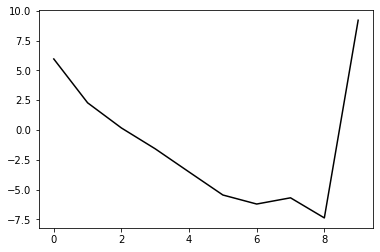

266200 39.60379853238726
1.647433600900954 1.939156603901563 0.7577102439971636 -0.971143596345924
[ 5.99776069  2.25859484  0.14500972 -1.60699591 -3.55329867 -5.48506365
 -6.22892933 -5.65704842 -7.28862627  9.20702534]


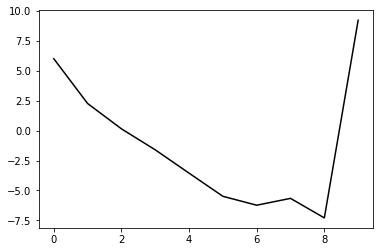

267300 28.68850074720836
1.5679604615258544 1.908994495065633 0.7439696038350531 -0.9784801269042909
[ 5.72510782  2.28451215  0.15139505 -1.6285491  -3.60868621 -5.58497413
 -6.39846915 -5.95982334 -7.68954707  9.25094668]


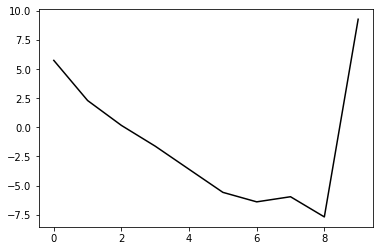

268400 32.90770438774748
1.5628561395948217 1.9080992465816837 0.7409127112967792 -0.9838594173884576
[ 5.78174781  2.363348    0.22723194 -1.56609502 -3.56632439 -5.57376709
 -6.43239204 -6.01030621 -7.64677505  9.15927416]


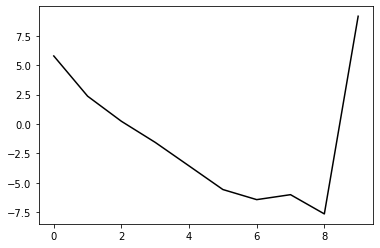

269500 35.93670088114973
1.628270332897122 1.9110674719505476 0.7278682425279412 -1.0145612651794558
[ 5.94367681  2.52325695  0.40360319 -1.37682464 -3.3668297  -5.36132285
 -6.18828868 -5.74659791 -7.39882113  9.21928019]


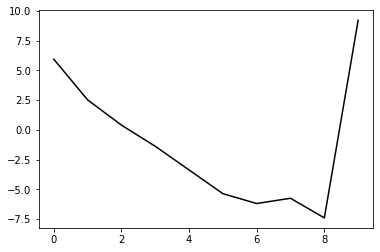

270600 32.61513786972347
1.5972246938955355 1.9020262135270698 0.7413904097080296 -1.0052199043910333
[ 5.93532325  2.44712353  0.318234   -1.47274417 -3.47429708 -5.47979246
 -6.3100889  -5.86510932 -7.53208567  9.18578147]


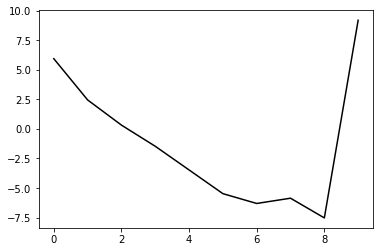

271700 34.30577104520657
1.6455748357807922 1.9230846890497844 0.754918969409532 -1.0035120943460618
[ 6.09459863  2.42862647  0.3002199  -1.49222277 -3.49647198 -5.50434158
 -6.32629371 -5.83880393 -7.4281753   9.26619173]


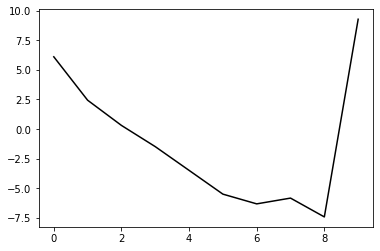

272800 36.312183008171765
1.668886894380545 1.9330291447095485 0.7543752401787346 -1.012676448921291
[ 6.20685295  2.55493406  0.4306549  -1.36366375 -3.3742043  -5.392354
 -6.2195655  -5.71659777 -7.27073855  9.16557099]


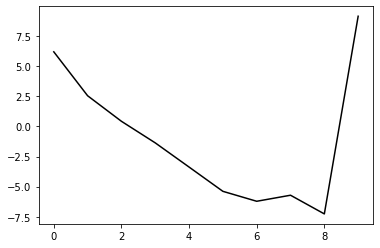

273900 36.71728132335574
1.691143994275506 1.9636902632924889 0.7711604209822286 -1.0037222179105454
[ 6.25112901  2.58528148  0.47114295 -1.31962206 -3.32935701 -5.34665935
 -6.16081127 -5.61485846 -7.13269434  9.21953713]


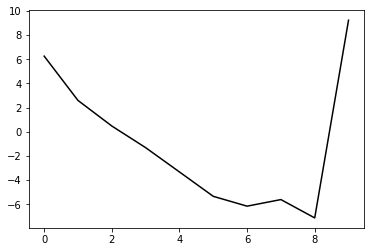

275000 31.271935203375907
1.7127969995313497 1.9715344703706934 0.7701223938861869 -1.010995071138244
[ 6.29346575  2.64435229  0.52813996 -1.26705618 -3.28390526 -5.31189709
 -6.13677895 -5.59102274 -7.08413516  9.36137819]


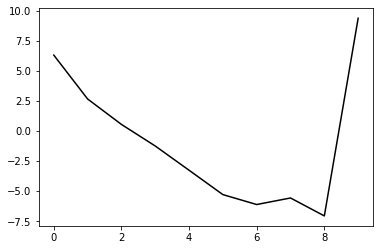

276100 31.365820025849306
1.7082540096778143 1.9426674840464055 0.7543543652048942 -1.0254380389060738
[ 6.1801769   2.63852513  0.50377667 -1.30820863 -3.34237494 -5.39008562
 -6.23299895 -5.69399297 -7.17029086  9.21978669]


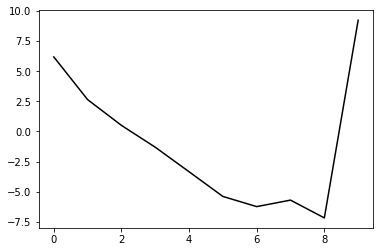

277200 40.42876814299239
1.6900162088950734 1.9634312358456998 0.7867149592041657 -0.9924594092741978
[ 6.11705531  2.53814342  0.40005229 -1.41590239 -3.45444784 -5.50689396
 -6.35094731 -5.80073399 -7.25093968  9.18744198]


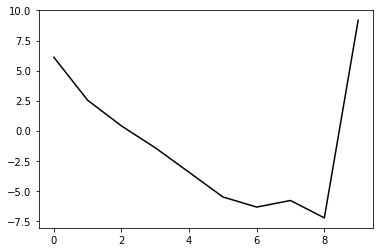

278300 28.880723717751973
1.6755824700929207 1.9277049584530888 0.7592268690339293 -1.0170103630083174
[ 6.00680991  2.67726454  0.51848196 -1.31823533 -3.37905373 -5.45955415
 -6.33703516 -5.82038706 -7.29061576  9.17665369]


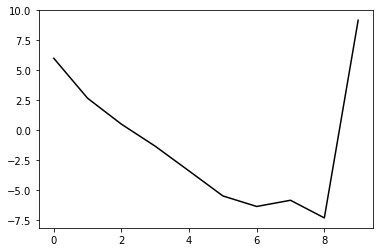

279400 30.794720654200123
1.6534699576486418 1.923381491124793 0.7563856679355346 -1.0189846068674886
[ 5.89415615  2.67537831  0.50767585 -1.3420254  -3.41819451 -5.51902158
 -6.4244452  -5.9357562  -7.40440701  9.1997094 ]


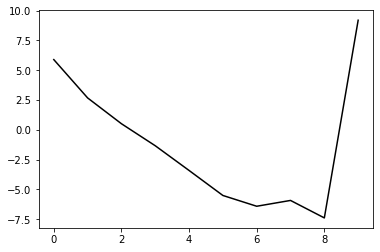

280500 36.05715942307136
1.603517432892237 1.8937099558253239 0.7526773160304775 -1.018575137376139
[ 5.71361342  2.68400958  0.50303358 -1.36113916 -3.45355209 -5.57359211
 -6.49696241 -6.03011912 -7.54136563  9.2150001 ]


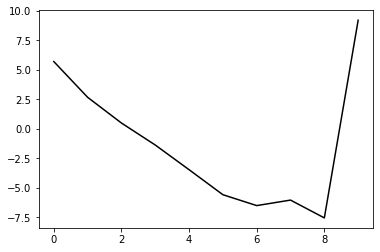

281600 32.03710093581999
1.647279456702252 1.922504112432352 0.760088398955139 -1.0230762298896194
[ 5.98343796  2.73254539  0.56083542 -1.301103   -3.39361272 -5.51382455
 -6.4299532  -5.93081801 -7.37810341  9.19881284]


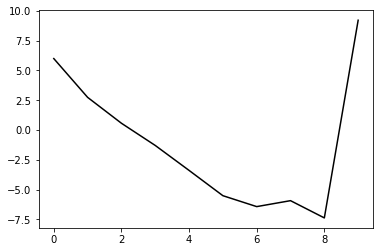

282700 34.30566118863959
1.641681476484869 1.9313258947443688 0.7781876947211455 -1.0101596303687481
[ 6.0622697   2.65032277  0.47061136 -1.40222536 -3.50651336 -5.63891878
 -6.55978798 -6.03731878 -7.43928109  9.19849584]


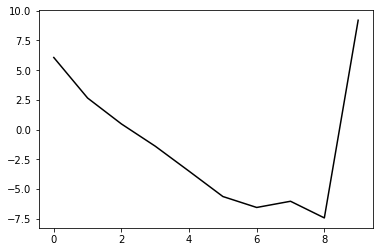

283800 35.51174603171309
1.6714858548940628 1.9562461756571325 0.7963274056910853 -1.0003809679580373
[ 6.11960003  2.60091347  0.4218538  -1.45626846 -3.56821821 -5.70959629
 -6.63066407 -6.07119597 -7.40098189  9.26722013]


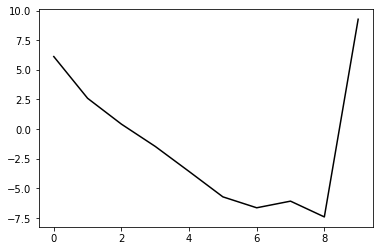

284900 38.55680163790397
1.6841853413582113 1.932464555381949 0.7840828341397572 -1.0171041052706975
[ 6.21342923  2.6057749   0.41887051 -1.4642622  -3.58195393 -5.73205255
 -6.65825119 -6.08277296 -7.36686833  9.21277962]


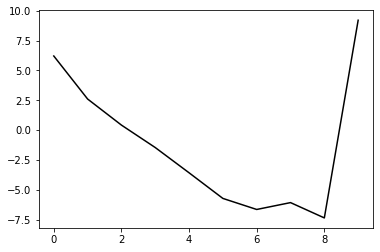

286000 31.58414542039963
1.7158008012988153 1.9269255594036594 0.7770210845640881 -1.033399987792317
[ 6.28220318  2.70214622  0.51091386 -1.37826189 -3.50190877 -5.65657671
 -6.57364953 -5.94628815 -7.20591868  9.21488526]


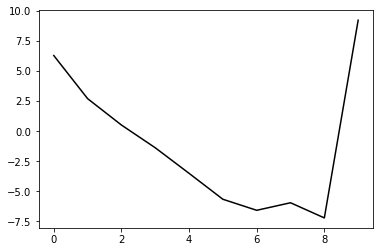

287100 34.13325585717572
1.6652991426837642 1.876965843463085 0.7445644524463498 -1.0628806989093644
[ 5.98398914  2.72649407  0.50906563 -1.40485165 -3.55597977 -5.74915192
 -6.72373432 -6.18833222 -7.56221523  9.27376925]


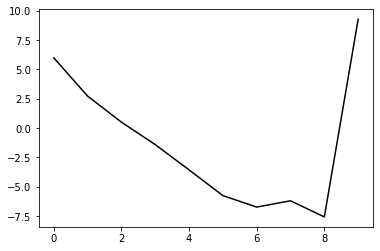

288200 40.12587231836688
1.6517776940053284 1.9353455028216522 0.8047330964178903 -1.008854660477299
[ 6.07414626  2.54379967  0.33373127 -1.57704237 -3.72585374 -5.91462371
 -6.87533408 -6.29422295 -7.59607786  9.20344203]


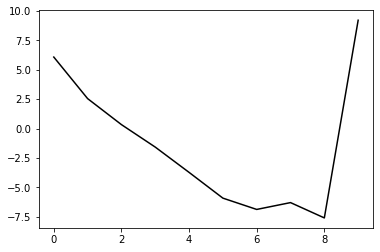

289300 29.139331241991854
1.6272336971777481 1.8828086241385225 0.7667132655199811 -1.0435294111027071
[ 5.97335885  2.68575491  0.45736356 -1.46929563 -3.63428538 -5.84590043
 -6.84406367 -6.32658967 -7.68329649  9.18440302]


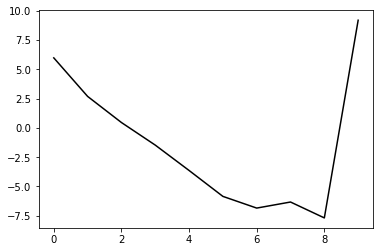

290400 31.85291992444083
1.6593905170678576 1.872326857345548 0.7549940910653421 -1.0597397042688925
[ 5.87071481  2.82003802  0.58694118 -1.34664256 -3.52049755 -5.74629453
 -6.75798529 -6.23057017 -7.55348     9.16849655]


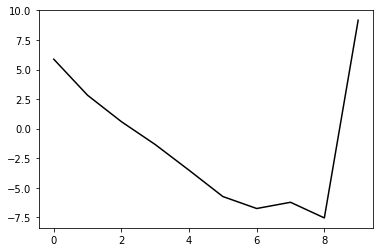

291500 36.07751739888038
1.6102522139757165 1.844324619716622 0.7563321474663075 -1.0601006583430173
[ 5.75963888  2.73350153  0.4854207  -1.46302836 -3.65321434 -5.89823986
 -6.92147687 -6.38819642 -7.749813    9.19006003]


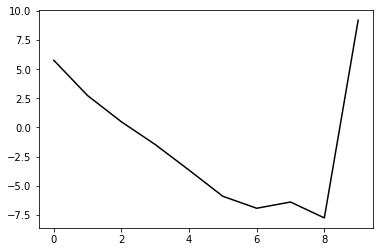

292600 32.21227304031937
1.6627170455511004 1.8904379636884479 0.7874588586523762 -1.0424035666004963
[ 6.15632252  2.66271541  0.4264911  -1.51422401 -3.6952351  -5.92351281
 -6.90889771 -6.28108296 -7.50881654  9.15013118]


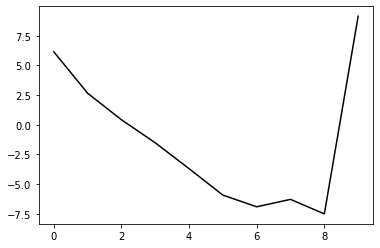

293700 34.46287986816963
1.6745477257906696 1.8883514119804712 0.7868785065087635 -1.0458993353677484
[ 6.12595191  2.66948013  0.42488088 -1.52666791 -3.7185547  -5.95912377
 -6.95245306 -6.30320456 -7.49400089  9.21758746]


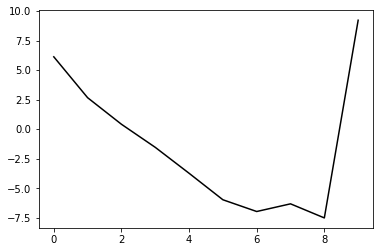

294800 36.37711683028424
1.689988929383596 1.9258632967359215 0.8129530404288925 -1.029611881973681
[ 6.25705369  2.61491964  0.3759886  -1.577395   -3.77424042 -6.02019349
 -7.00757261 -6.29454701 -7.4092192   9.19658239]


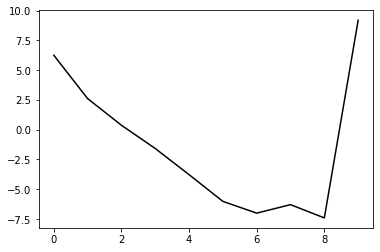

295900 37.3195035729613
1.699651213491651 1.8965784781893327 0.793063878056079 -1.0550127498949333
[ 6.4005691   2.75801137  0.51042935 -1.45040412 -3.65497477 -5.91001311
 -6.90047428 -6.18483268 -7.33801076  9.27044126]


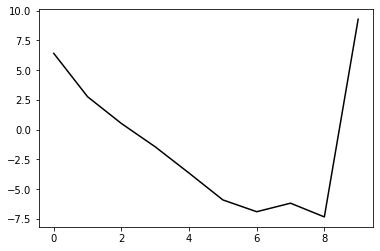

297000 30.9320165871237
1.6935936532922957 1.9109884537808328 0.8076734552811415 -1.041035243096126
[ 6.15880913  2.62065852  0.3652786  -1.60369274 -3.8169375  -6.08467218
 -7.09600955 -6.39598951 -7.51656637  9.19763938]


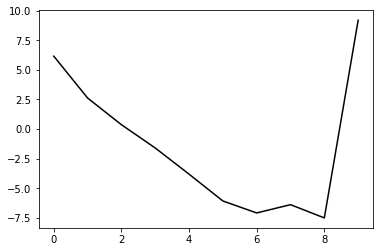

298100 30.611487003737373
1.6613156944263574 1.880784300086728 0.7855162987603157 -1.0604908485325637
[ 5.94744064  2.6781321   0.40911038 -1.57504031 -3.80430012 -6.09490647
 -7.14468745 -6.50792304 -7.68758761  9.18988277]


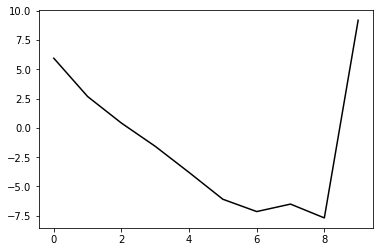

299200 41.416273471982365
1.7292482426090479 1.908848379455004 0.7974981494122002 -1.060723310126496
[ 6.22482713  2.76342699  0.51035559 -1.4665195  -3.69172587 -5.97654357
 -6.98696376 -6.21326346 -7.2941709   9.19980185]


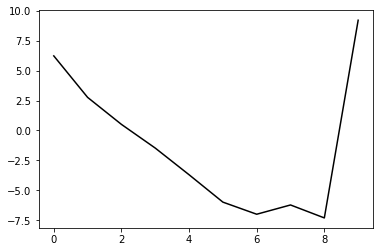

300300 28.98592517109922
1.6300003357971296 1.8717318104919771 0.7862489425168877 -1.0612867329486857
[ 5.67598076  2.78994448  0.50780928 -1.49568759 -3.74903874 -6.07568855
 -7.17709359 -6.61922426 -7.86265916  9.18718247]


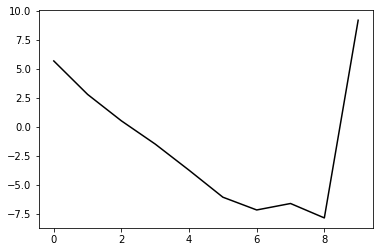

301400 32.40600820407477
1.6394770700995542 1.8651383964213315 0.7898147842057095 -1.0604102433800804
[ 5.89628224  2.67785712  0.38831666 -1.62057502 -3.8766753  -6.20325102
 -7.2904801  -6.65299592 -7.79982265  9.09609665]


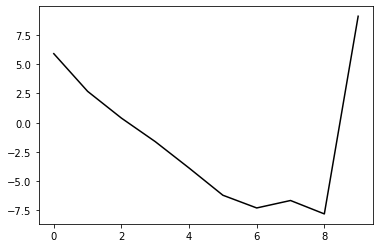

302500 36.923268126607674
1.6113519574811235 1.8483316858972396 0.782611554271604 -1.0653619828707501
[ 5.74130268  2.71383246  0.40811018 -1.61811082 -3.89130124 -6.2397007
 -7.36660291 -6.79472024 -7.94954343  9.17761339]


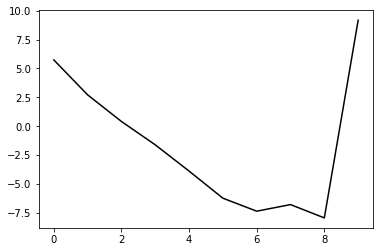

303600 32.270017059957596
1.6712801446876695 1.8516586934440724 0.7762266935931823 -1.0832167067498049
[ 6.06080164  2.76395829  0.4637283  -1.56155371 -3.83439397 -6.18016059
 -7.27893376 -6.59262683 -7.64247042  9.1827081 ]


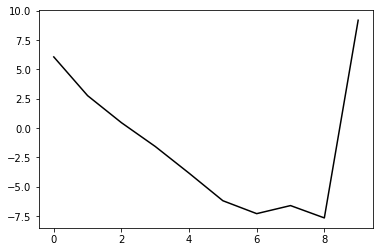

304700 38.16610410864243
1.6991080751656633 1.8431282532993776 0.7718093355655007 -1.0932622274122834
[ 6.10432698  2.83700858  0.52811582 -1.50780574 -3.79053064 -6.14712753
 -7.24918726 -6.52917642 -7.55609255  9.1447253 ]


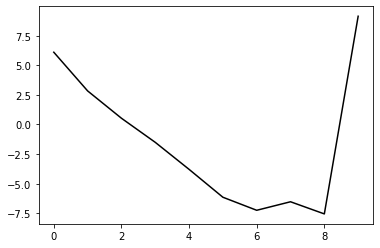

305800 40.08499340298203
1.7045648613524194 1.8343155660338812 0.7711562670710057 -1.0936030781993977
[ 6.06558435  2.79923015  0.47720279 -1.56864947 -3.859771   -6.22781405
 -7.34404267 -6.60688385 -7.59313252  9.18564911]


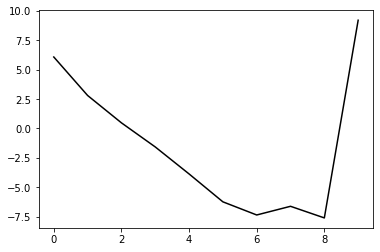

306900 38.969333368644996
1.7594731798512868 1.8657941463290753 0.7911299635857227 -1.086025576843491
[ 6.50730903  2.83943996  0.5271995  -1.5104903  -3.79080446 -6.13583379
 -7.17925119 -6.26035947 -7.20345547  9.25090896]


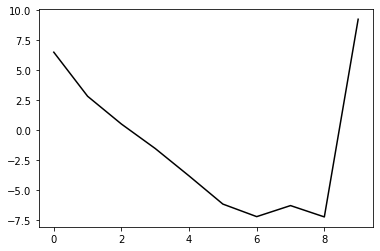

308000 31.304736835776428
1.7522321672362564 1.878464066295464 0.8071854559165239 -1.0736840648249606
[ 6.35533443  2.73826539  0.42002974 -1.62419836 -3.91236919 -6.2691717
 -7.32894992 -6.43324016 -7.34358893  9.18794886]


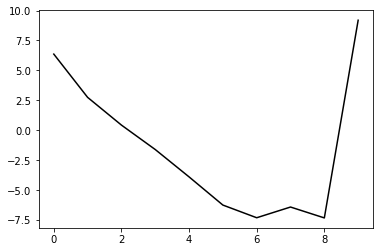

309100 31.19504853607281
1.7213416266061867 1.8594127896454977 0.799150282670526 -1.0799073996869546
[ 6.20288236  2.76279513  0.4247687  -1.64007832 -3.94904713 -6.33341644
 -7.43975236 -6.60098932 -7.50931825  9.1925772 ]


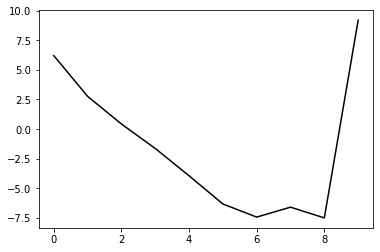

310200 40.13481109059632
1.642100504915899 1.8416042273186846 0.8086903084606275 -1.0692125335613532
[ 5.94448457  2.6265487   0.27671623 -1.80155585 -4.12356721 -6.52178288
 -7.64601858 -6.88339351 -7.90348804  9.07023836]


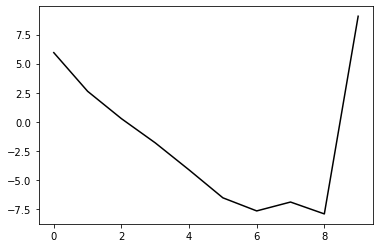

311300 30.81625394997834
1.6309763871063458 1.8587234135793176 0.820119182137532 -1.0640454815993408
[ 5.93386861  2.64767057  0.29924406 -1.78303902 -4.11183715 -6.52206293
 -7.66211704 -6.90322292 -7.90818604  9.17244291]


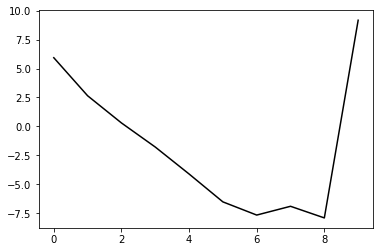

312400 32.734986238790675
1.6065442112822443 1.8235221294037587 0.7993321426581802 -1.0840041817190413
[ 5.86033267  2.73986029  0.37815382 -1.71864981 -4.0617261  -6.49000452
 -7.66026691 -6.94969927 -7.97661482  9.18200905]


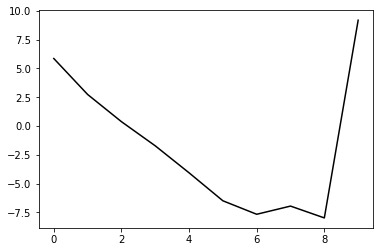

313500 35.88666291914207
1.5868669070858423 1.834405024614948 0.7885381388355764 -1.1008926441741478
[ 5.66835128  2.92320305  0.56301746 -1.54439863 -3.90359549 -6.36008009
 -7.59333603 -6.99352194 -8.04249356  9.23929437]


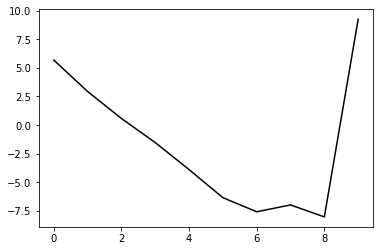

314600 32.33659024701244
1.6309674960576013 1.8614993380212943 0.8011562710697918 -1.0994276980640079
[ 5.94697425  2.94425406  0.59642351 -1.50449055 -3.85776068 -6.30362831
 -7.49653365 -6.78560144 -7.7766645   9.17280026]


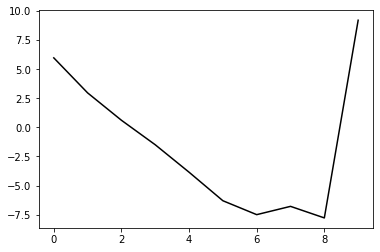

315700 33.391890783473706
1.690671813001942 1.8983017776360716 0.8161919492087837 -1.1006697980440607
[ 6.25793429  2.94394717  0.60856177 -1.48764019 -3.83790232 -6.27628517
 -7.42872673 -6.59714905 -7.52518076  9.19961774]


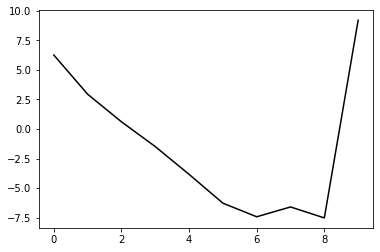

316800 33.777869861531265
1.7156155654085923 1.9374470854851904 0.8355623817601994 -1.0897533198516216
[ 6.35793444  2.92465603  0.60970028 -1.47550267 -3.81761198 -6.2447548
 -7.36669856 -6.46809292 -7.35832225  9.22275106]


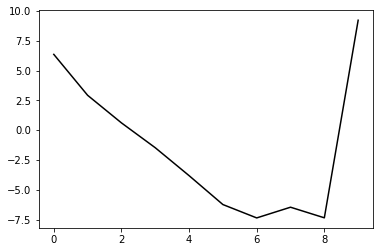

317900 49.466910353319776
1.7349297544466173 1.9635500502323338 0.8560568977085189 -1.0748439233704745
[ 6.30897208  2.80020875  0.4818525  -1.60596165 -3.95166947 -6.38595037
 -7.50323436 -6.53016137 -7.33316937  9.21185544]


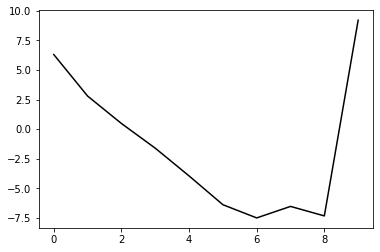

319000 30.96673590072823
1.6649104214482657 1.8957276624649844 0.810376413107606 -1.1148474366617733
[ 6.12973317  3.02882392  0.67269023 -1.45334454 -3.83636495 -6.31710204
 -7.53355278 -6.75090182 -7.62548844  9.09838226]


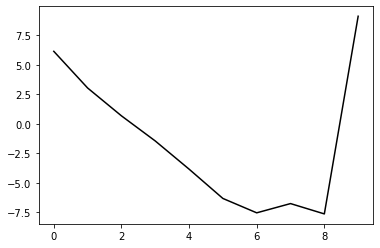

320100 31.90539081576807
1.7037335648595315 1.9197579655775887 0.8233825189718523 -1.1110279216961085
[ 6.26602233  3.00936138  0.65933497 -1.46450008 -3.84623814 -6.32445011
 -7.5223958  -6.67358939 -7.48265643  9.20385774]


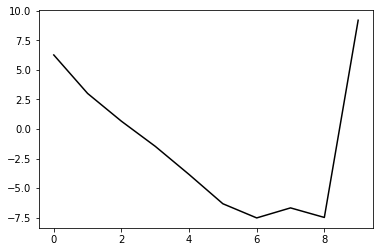

321200 40.59459240739067
1.611927470071977 1.8664722166832555 0.8080957414349524 -1.112148385249194
[ 5.8981319   2.94033973  0.55784786 -1.59362284 -4.00167468 -6.51492062
 -7.78248979 -7.07977055 -7.98127564  9.18527294]


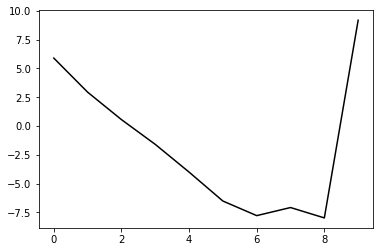

322300 28.6643744263654
1.5868800542033852 1.8800899103380821 0.8279169712441321 -1.0955598889967286
[ 5.84021502  2.90578886  0.51886023 -1.64160539 -4.05893524 -6.58185494
 -7.86318374 -7.1972943  -8.09410276  9.2480972 ]


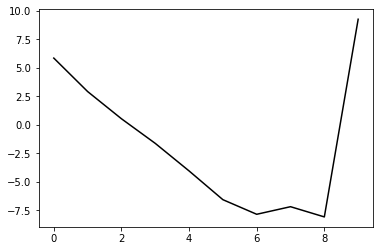

323400 33.75956491868662
1.6223810809026173 1.8568705268739225 0.7908002450417292 -1.1393123728981152
[ 5.76097696  3.22092915  0.83920331 -1.3223851  -3.74495103 -6.28433872
 -7.60217073 -6.97683039 -7.86331373  9.1774465 ]


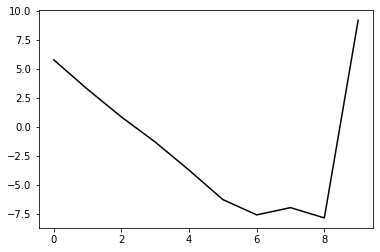

324500 36.18425776318806
1.6526106190093168 1.881212339186597 0.810467040136283 -1.1272354133579234
[ 6.13535715  3.08932371  0.70823402 -1.45443659 -3.87899096 -6.42202712
 -7.73176028 -7.0131755  -7.77275505  9.19016234]


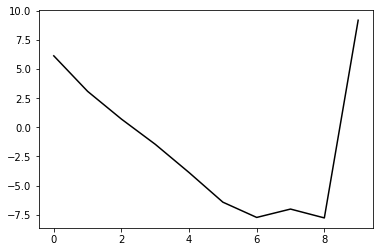

325600 31.974042463855426
1.6886996527375933 1.9048481916779785 0.8174512062768257 -1.1311274032156506
[ 6.27408908  3.13305997  0.76005089 -1.40231963 -3.8286546  -6.37425695
 -7.67681146 -6.89955611 -7.60429466  9.25592332]


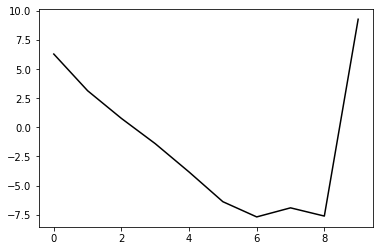

326700 37.904342994415664
1.6934281783012168 1.8752897659197645 0.809072281773357 -1.1405125163751066
[ 6.17170534  3.06900661  0.67696404 -1.49844972 -3.93730622 -6.50229928
 -7.828402   -7.0395563  -7.69152537  9.16143394]


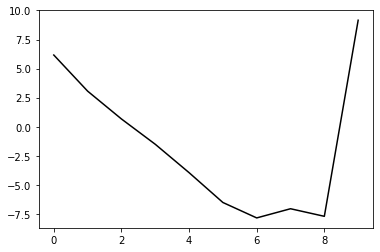

327800 34.7130164871139
1.6678136202538836 1.906793354342395 0.837803199298145 -1.1175875727288
[ 6.04684224  3.02376297  0.63704115 -1.54013835 -3.98221551 -6.55046185
 -7.88200849 -7.1055185  -7.76243427  9.1777021 ]


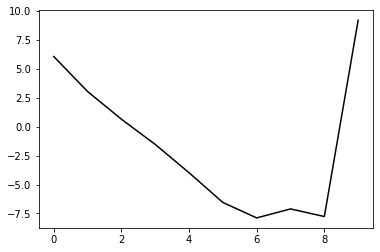

328900 37.89054697337229
1.6797978470172716 1.9320369467652359 0.8486685298696144 -1.1166602173310238
[ 6.17682665  3.0488208   0.67132959 -1.50221877 -3.94393445 -6.51586059
 -7.85183981 -7.07259611 -7.68538558  9.21293018]


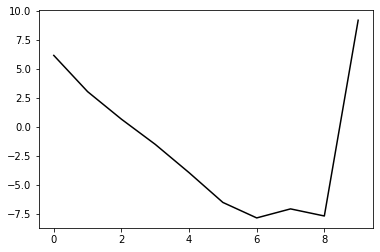

330000 28.760744549460064
1.656292835664006 1.9002952602409129 0.8149441405700696 -1.1534295548482927
[ 5.986853    3.2789748   0.89118193 -1.29824115 -3.75889598 -6.36235772
 -7.77394537 -7.17196165 -7.86136227  9.14932283]


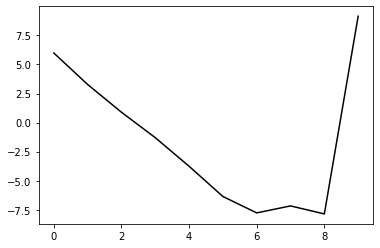

331100 29.119834079557858
1.6943439991915965 1.9475624454485951 0.8609349436432268 -1.1165787576541204
[ 6.22889827  3.04928478  0.66599876 -1.52007872 -3.97806469 -6.57832624
 -7.96085348 -7.17697234 -7.70143063  9.18205493]


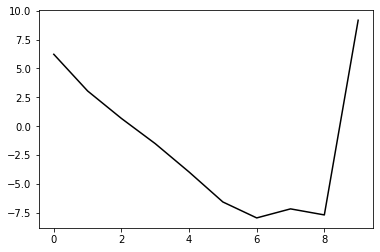

332200 41.32450187645244
1.6980975898391961 1.932958206370222 0.8392522810469306 -1.1422933447665335
[ 6.17449886  3.18000158  0.79170341 -1.40383997 -3.87344344 -6.49232494
 -7.91192835 -7.19074543 -7.73256798  9.22829395]


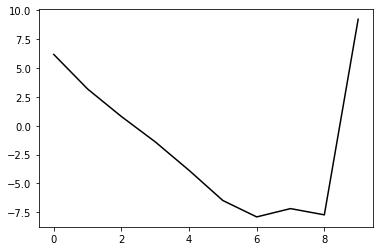

333300 28.914338287301565
1.6293989975693257 1.8983798101429614 0.8328583840012671 -1.1349132696632231
[ 5.89206944  3.12279009  0.7066701  -1.51040685 -3.99690285 -6.63547033
 -8.1011407  -7.46741749 -8.04301933  9.17923393]


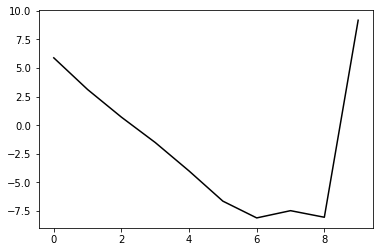

334400 31.075127317096793
1.6864196584198652 1.9156347407023198 0.8311558109213657 -1.1497318943115877
[ 6.20034069  3.30905316  0.90448089 -1.30942414 -3.79706126 -6.44173043
 -7.90682402 -7.22067295 -7.73895559  9.18836769]


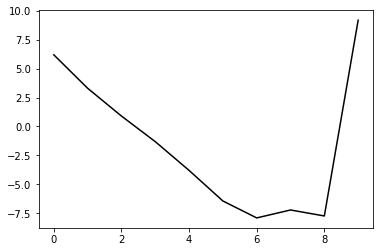

335500 36.04433876927746
1.6254186898257268 1.8678893176980997 0.8136020142430107 -1.1587659175721519
[ 5.68161294  3.19147661  0.76477255 -1.46526062 -3.96613741 -6.62912152
 -8.14573958 -7.58718595 -8.17084813  9.270302  ]


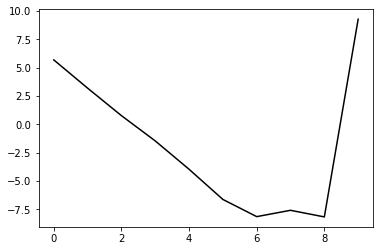

336600 31.894059665440672
1.6669422632652648 1.901511492268616 0.8346761049574078 -1.151018274093416
[ 5.97819967  3.15295324  0.73355273 -1.49504397 -3.99527325 -6.65562065
 -8.14926301 -7.45234743 -7.92444183  9.17363477]


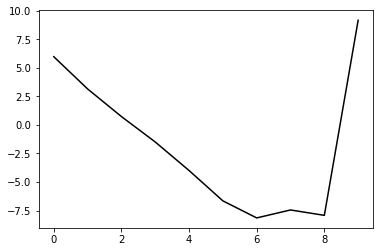

337700 35.18489757589677
1.7016278433692313 1.91053428686583 0.8374315507296121 -1.1561721606756306
[ 6.20319006  3.21960549  0.80360951 -1.4247424  -3.9241949  -6.58132339
 -8.05616344 -7.26496375 -7.68369204  9.17085295]


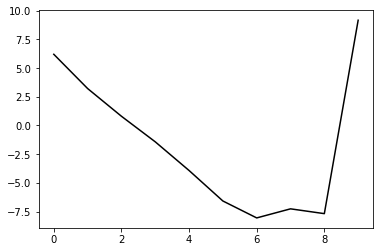

338800 38.5599575945319
1.6709173775873691 1.888326957755621 0.8295576906433156 -1.1595908653328042
[ 5.82141879  3.19152515  0.75796663 -1.48936489 -4.00760487 -6.69356984
 -8.23691578 -7.53416485 -7.93847605  9.14976828]


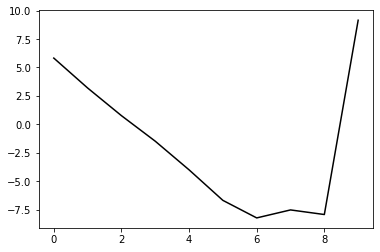

339900 37.922230522692416
1.6847065246791302 1.915683302535703 0.8572733581800278 -1.136986339567439
[ 6.01266507  3.10741052  0.67169361 -1.57921089 -4.09675007 -6.77120792
 -8.26561996 -7.42292145 -7.78684131  9.18232422]


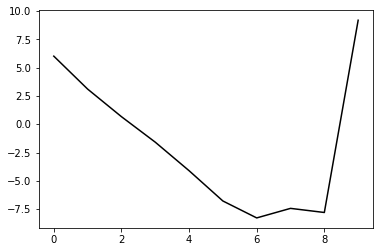

341000 31.7330664840882
1.7097369598297052 1.9050932474536117 0.8438662538313281 -1.1579544811106652
[ 6.09354507  3.15864093  0.71532658 -1.54716814 -4.07704667 -6.77063825
 -8.29773777 -7.43873945 -7.74979435  9.23082151]


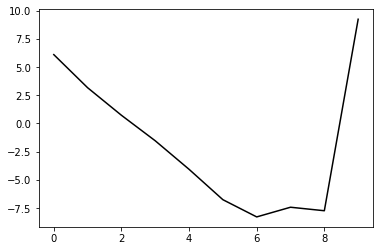

342100 31.53514625496383
1.693372743809937 1.9138356650977217 0.8504132300856957 -1.1545879115996758
[ 6.06848609  3.13454098  0.69029903 -1.57737363 -4.11408655 -6.81887515
 -8.37315671 -7.56430033 -7.81539123  9.16709346]


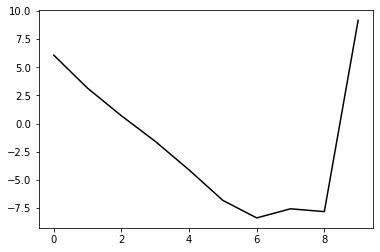

343200 41.53573759684968
1.702407749230969 1.9235061567771141 0.8533060004669859 -1.1551343809201475
[ 6.0194493   3.14192544  0.70145196 -1.56498321 -4.10122341 -6.80625902
 -8.34955047 -7.53417343 -7.79750621  9.18270118]


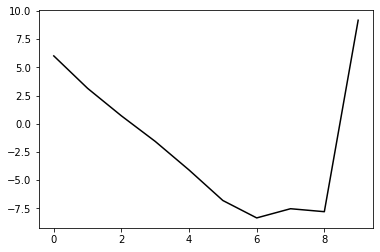

344300 28.456130214278584
1.6198255910649384 1.890903793255378 0.8486184100040416 -1.1490927701893523
[ 5.56351901  3.15893117  0.69119732 -1.6013702  -4.16306115 -6.90559833
 -8.54484428 -7.93726701 -8.2618256   9.19604789]


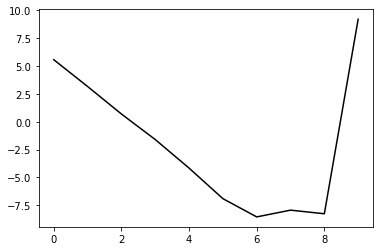

345400 30.805485075527987
1.6758329830248324 1.9067758892148494 0.8412754411437581 -1.1709585186265017
[ 5.81420169  3.23069628  0.7817461  -1.50103019 -4.05471607 -6.78457436
 -8.38140274 -7.65723764 -7.93537125  9.14373245]


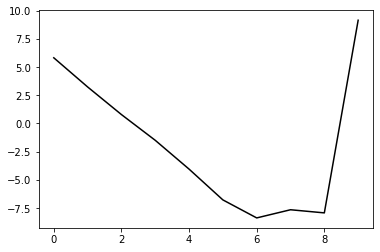

346500 35.65268342829588
1.6449656737684744 1.8736829005444655 0.8269537304721116 -1.1799233134308456
[ 5.69779569  3.22500875  0.75315778 -1.54725431 -4.11507102 -6.86231871
 -8.5027369  -7.87182393 -8.15795305  9.165156  ]


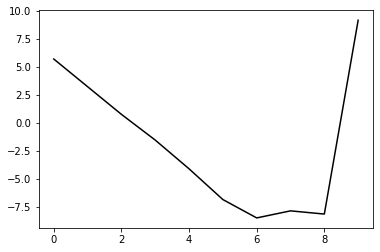

347600 31.209762531701752
1.6722484483074678 1.9185615972308165 0.857590886778233 -1.1638005040387263
[ 6.01118389  3.12610855  0.6719069  -1.61995582 -4.17975287 -6.90792247
 -8.47846073 -7.73772378 -7.95200278  9.12658176]


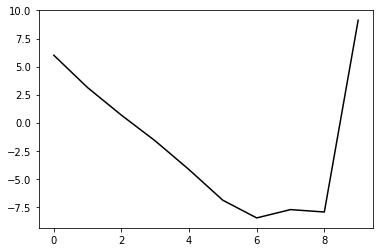

348700 34.25149451717051
1.6585622642565245 1.916700311189609 0.8499929667311233 -1.176271885049251
[ 5.93521431  3.23164622  0.77795726 -1.52092665 -4.09150835 -6.84084333
 -8.4660659  -7.80491601 -8.00126512  9.19625187]


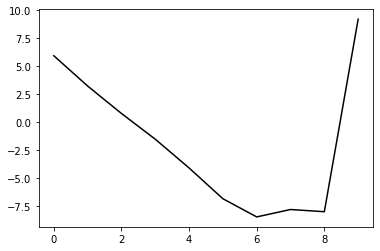

349800 39.23927565613067
1.634561526359372 1.893134778393178 0.8372870808939202 -1.1854862808610143
[ 5.76155109  3.24969923  0.77829553 -1.53952073 -4.12697333 -6.89788878
 -8.58225377 -7.99402733 -8.17928329  9.15873063]


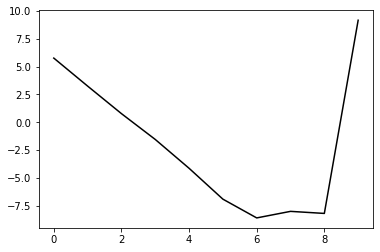

350900 38.62677021109835
1.7098449868320078 1.9277573327314843 0.8602320090319058 -1.177832927569415
[ 6.27560737  3.27693773  0.82009072 -1.48678845 -4.0643346  -6.82150274
 -8.45119023 -7.65746221 -7.74807143  9.20335607]


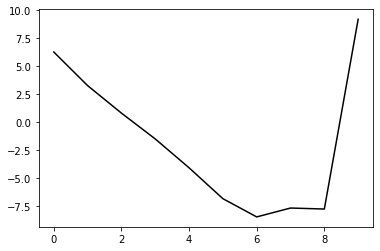

352000 30.126717077564056
1.6843345993289498 1.9073014637734496 0.8451957379747269 -1.193774127570221
[ 6.22083786  3.26022642  0.79211708 -1.5282932  -4.12003935 -6.89678179
 -8.5659336  -7.84308003 -7.9231595   9.17556242]


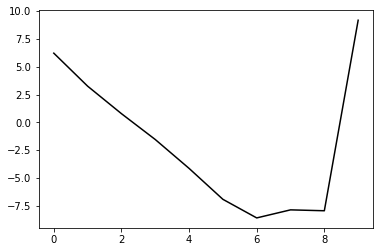

353100 31.351469951851996
1.6704547183181744 1.898873769710101 0.8556052896675328 -1.1837639482580862
[ 6.13430835  3.11289034  0.6296533  -1.70336838 -4.30595717 -7.09552478
 -8.78406851 -8.0292644  -8.03679371  9.17343623]


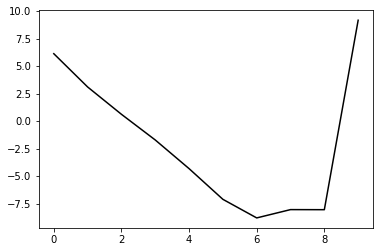

354200 40.89881624412593
1.6028377370667062 1.865386402862059 0.8565167717445117 -1.17430665342411
[ 5.87430537  3.01045496  0.50548928 -1.84401656 -4.4601755  -7.26642493
 -8.99775696 -8.39303345 -8.44725972  9.09754013]


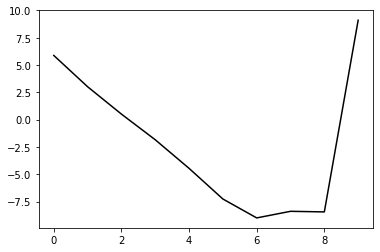

355300 28.86802504549822
1.6024276174909742 1.8741177508036024 0.8710179354882661 -1.1616037246766655
[ 5.95793333  3.02859388  0.51993096 -1.8363007  -4.45779422 -7.26855491
 -9.01048158 -8.37985886 -8.37230512  9.15569518]


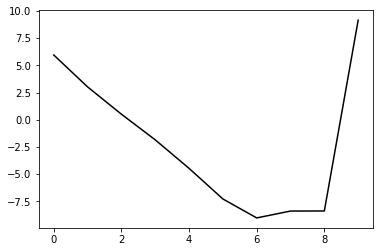

356400 31.388144078442696
1.5927658378002028 1.8445437369383866 0.8361004111523873 -1.1996993005258065
[ 5.83568445  3.28472603  0.78003568 -1.58321657 -4.21318988 -7.03649737
 -8.83401758 -8.38987365 -8.38737474  9.16193349]


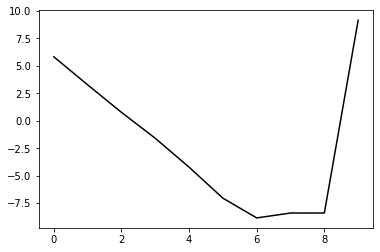

357500 35.613744916582654
1.629338429806278 1.8621173044621258 0.8411828442740734 -1.205612681640878
[ 5.993701    3.29036475  0.78811822 -1.57481308 -4.20343079 -7.02000001
 -8.78422861 -8.33234107 -8.32334631  9.1502311 ]


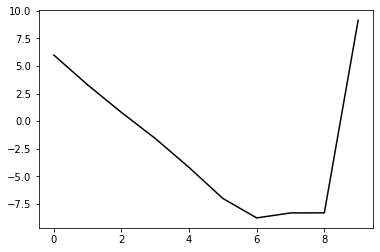

358600 31.2166981973993
1.670853132157217 1.8894362785328966 0.8653818853841445 -1.193065478585808
[ 6.22485731  3.20142699  0.70481706 -1.65723091 -4.2845791  -7.09341949
 -8.79729991 -8.12927703 -8.06371092  9.1649414 ]


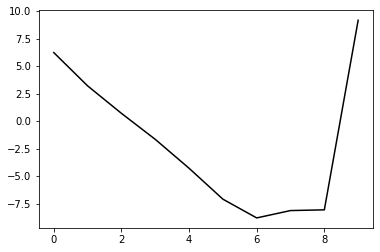

359700 34.519015772015095
1.651202624840843 1.8846884805590158 0.8709210096637507 -1.1849294990206332
[ 6.10087213  3.16463489  0.65751256 -1.71437292 -4.3490488  -7.16466897
 -8.88622983 -8.27435132 -8.19801658  9.25448005]


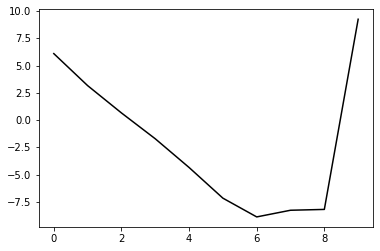

360800 37.25961897388965
1.6878993142558723 1.92015019926147 0.8984555261914194 -1.1672263306036212
[ 6.26708674  3.02156579  0.52258238 -1.84554377 -4.47570623 -7.2793232
 -8.95109072 -8.14682278 -7.999129    9.16882331]


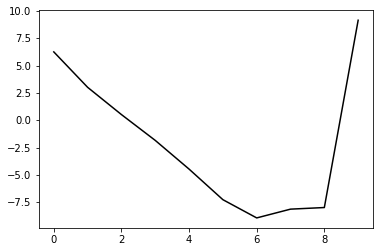

361900 37.16421699544385
1.6926030358037276 1.9038870873673108 0.8759907018451726 -1.1956914774856493
[ 6.38598595  3.25059856  0.75098602 -1.62413157 -4.26236333 -7.07352025
 -8.74987434 -8.08591066 -7.98221887  9.17537684]


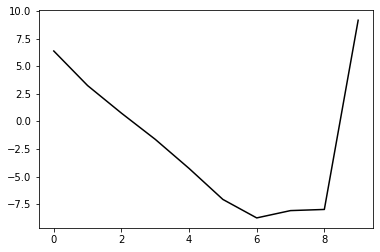

363000 30.47000232190969
1.682101578697497 1.892786767147429 0.8615243572370013 -1.215177018984312
[ 6.43690379  3.27474774  0.77379008 -1.60761214 -4.25206483 -7.0663847
 -8.73721323 -8.20355435 -8.09001764  9.12882158]


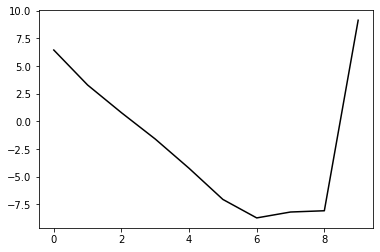

364100 31.31415062289039
1.6922733931298188 1.8957541906331745 0.8671322250906308 -1.213493230724629
[ 6.4086392   3.22815059  0.71926094 -1.67081986 -4.3233421  -7.14601593
 -8.82274381 -8.25703058 -8.08969231  9.16910993]


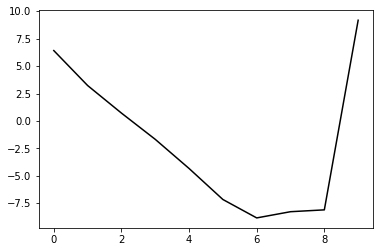

365200 40.78598635185225
1.7198729325472075 1.9348052149690147 0.89799471179042 -1.188531088613104
[ 6.38388497  3.12902475  0.62743662 -1.75937809 -4.40913968 -7.22635116
 -8.87571111 -8.13564544 -7.91640473  9.30853516]


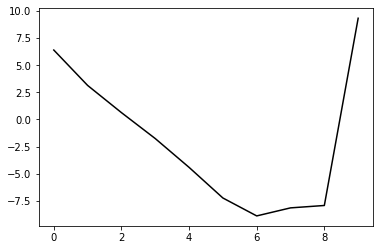

366300 28.88609266074364
1.6464286779641009 1.9193424477656602 0.8897670623072877 -1.1894337238631916
[ 6.03351481  3.19820647  0.67733596 -1.73386244 -4.40757504 -7.25668038
 -9.00262018 -8.46844637 -8.27304445  9.16819932]


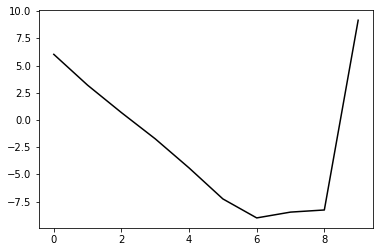

367400 30.951142769921976
1.6546467507594702 1.9104547763471436 0.8699412679132696 -1.217121280736317
[ 6.24943781  3.42270085  0.90662125 -1.50782304 -4.18872284 -7.05293155
 -8.84467538 -8.36712039 -8.13739233  9.14241098]


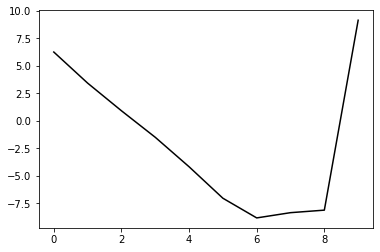

368500 37.12507538800861
1.6166586617475402 1.9127749440579997 0.8811855165247946 -1.2059090396618641
[ 5.78320619  3.35283079  0.82585736 -1.60374955 -4.29998704 -7.18504751
 -9.04285008 -8.69516696 -8.40913358  9.23407274]


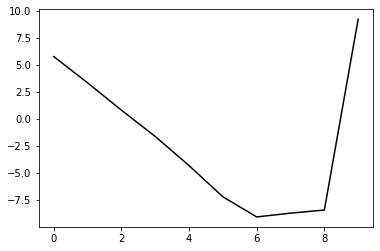

369600 31.99090371143329
1.5879049920989747 1.8958747765762034 0.8767300290725285 -1.2088652850540156
[ 5.79509199  3.33876057  0.8031529  -1.6396147  -4.34784522 -7.2470321
 -9.15304959 -8.83401055 -8.49764331  9.11550402]


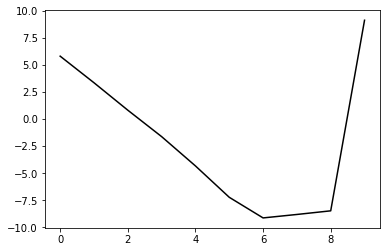

370700 34.65977327811517
1.6073721221560398 1.9082171400341448 0.8839557978377339 -1.2072522964971073
[ 5.84434455  3.34361587  0.80634248 -1.64353767 -4.35776517 -7.26156287
 -9.18026435 -8.84753676 -8.47888135  9.16870973]


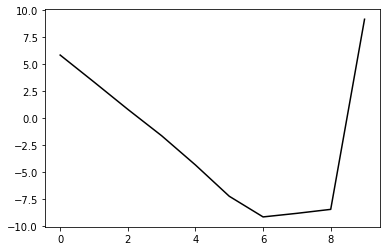

371800 36.330413200970156
1.636010889700311 1.911715585201775 0.8769520466015702 -1.2231515802157293
[ 5.9424006   3.42784076  0.89936268 -1.54872362 -4.26309323 -7.16760088
 -9.09322111 -8.75041157 -8.34833308  9.14466672]


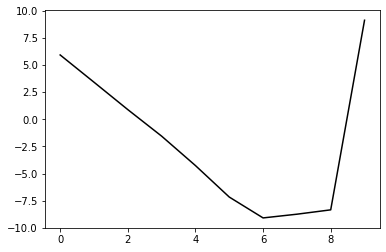

372900 37.52120075066845
1.6468239269527951 1.9394518635490279 0.9026943198382481 -1.2055937555048675
[ 6.1078443   3.41717367  0.89476297 -1.55247971 -4.26471937 -7.15851753
 -9.0295427  -8.63244719 -8.23387328  9.23212264]


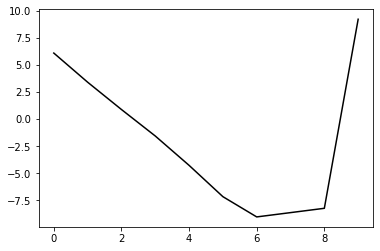

374000 30.88402058742999
1.66721474024778 1.9684650714750207 0.9167211338259135 -1.200766728235749
[ 6.10342286  3.44235957  0.93269548 -1.5125598  -4.22576317 -7.1204488
 -8.99145273 -8.63603531 -8.2103075   9.1254085 ]


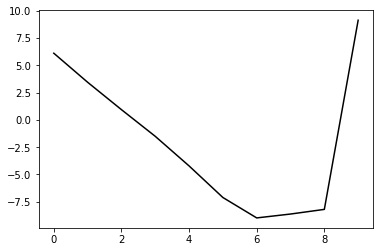

375100 28.497500396978456
1.5508326517512554 1.9354797166586664 0.9179881238005484 -1.1855556563211809
[ 5.84167181  3.28472592  0.7411945  -1.73351281 -4.47262281 -7.40084331
 -9.36385166 -9.19534748 -8.73688839  9.15515001]


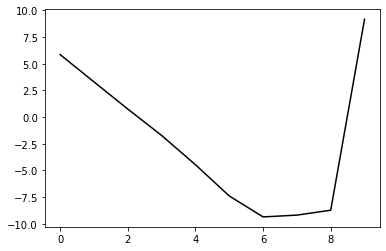

376200 41.08938948442673
1.6270819934184357 1.9339568546990005 0.8961108490883946 -1.2226168682944536
[ 6.11173826  3.49724733  0.96747708 -1.50182975 -4.23881117 -7.16602863
 -9.14011038 -8.92393348 -8.40686165  9.15435509]


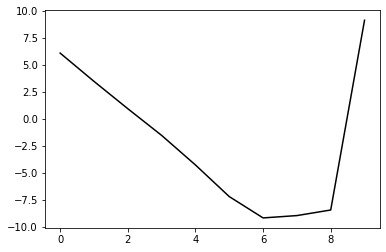

377300 28.86701786999579
1.5933675261975604 1.9280883625312095 0.9019141014260355 -1.211814744966441
[ 5.88817593  3.49573021  0.95069526 -1.53485439 -4.28495827 -7.22608745
 -9.24760909 -9.11830628 -8.58832849  9.23364407]


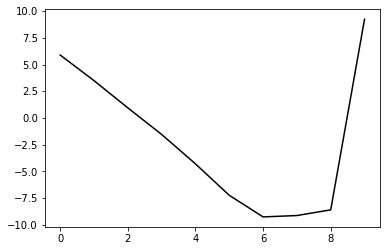

378400 32.194039664517135
1.5842636292817236 1.9165926012833001 0.9047175523385704 -1.208746699218913
[ 5.86349666  3.46119841  0.90408461 -1.59677038 -4.35937572 -7.31092774
 -9.35147493 -9.21320824 -8.65635842  9.14642179]


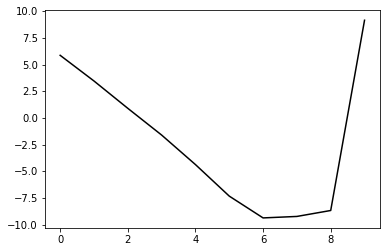

379500 36.07081808160442
1.5341943250090113 1.8426841082672845 0.857323152938337 -1.2469533881245844
[ 5.56053849  3.56485838  0.97868033 -1.54929832 -4.33420772 -7.31120378
 -9.42739976 -9.48797786 -8.97948946  9.13700279]


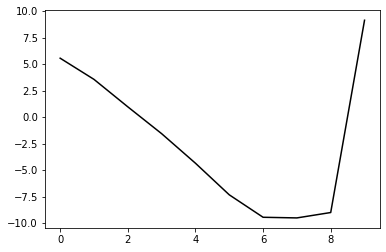

380600 32.314327655772225
1.5586691497498155 1.8658716978616992 0.8779371132033587 -1.2349963798145642
[ 6.05947     3.55093388  0.97258212 -1.55175127 -4.33205571 -7.29734974
 -9.3734614  -9.32917471 -8.73630345  9.10906738]


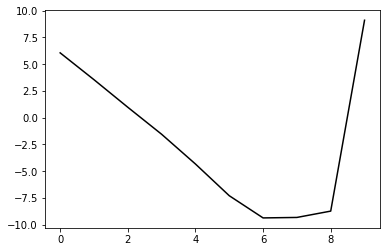

381700 35.72920002246279
1.6300989330909519 1.945443006843703 0.9256928209666508 -1.206900175125285
[ 6.25357348  3.38604004  0.83243483 -1.6787295  -4.44853825 -7.39474046
 -9.39440699 -9.01048984 -8.38693209  9.16880598]


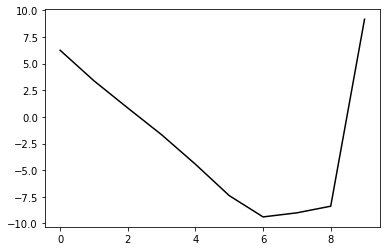

382800 34.49129474136791
1.674993124925839 1.9373875271863115 0.9052500771861196 -1.2393560457040536
[ 6.4655444   3.64687094  1.10119255 -1.40966121 -4.18053112 -7.12519403
 -9.10387494 -8.80499237 -8.1693218   9.14610178]


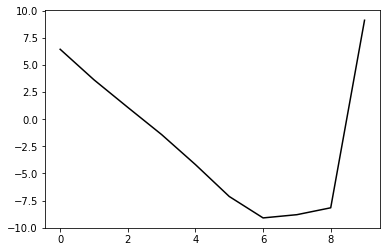

383900 38.4987098404683
1.6830023742299671 1.943008297637978 0.9083322835001838 -1.2387808397308897
[ 6.44728522  3.63818334  1.0913917  -1.42314772 -4.19733768 -7.14522081
 -9.13982725 -8.85037464 -8.16701683  9.13446089]


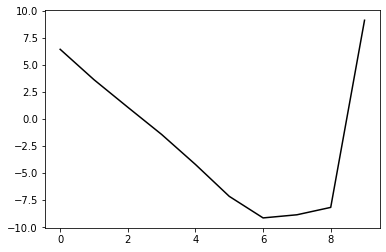

385000 29.49901410986286
1.5679973998504608 1.8921549457255058 0.9104112341977071 -1.2170788511408634
[ 5.9013733   3.42880274  0.83601512 -1.71326627 -4.51459537 -7.49397961
 -9.57031066 -9.48792335 -8.81309115  9.1489283 ]


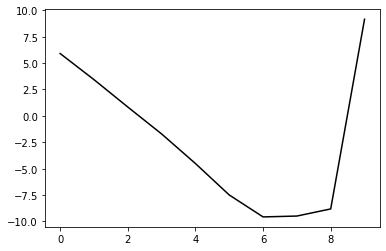

386100 36.36459259679973
1.6023065799508545 1.8595810441303333 0.8656533136234044 -1.2693845368963936
[ 6.01557101  3.68040895  1.08933325 -1.46314316 -4.26815557 -7.25144867
 -9.35191629 -9.37182977 -8.66426724  9.1010226 ]


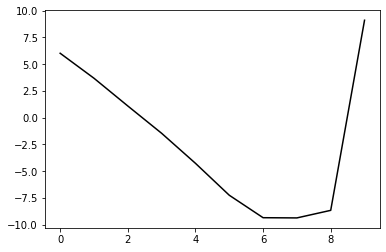

387200 41.76796537021846
1.6279804985966289 1.8694275120623822 0.8813010167928411 -1.2674934252913623
[ 6.04937229  3.57319549  0.98090195 -1.57393792 -4.38258145 -7.37060923
 -9.46312805 -9.37497483 -8.57529944  9.11296727]


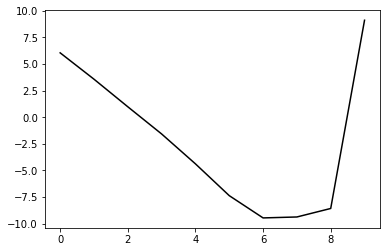

388300 29.1531091388701
1.6521892874694892 1.8849741723713542 0.9055661224797784 -1.2494440266888143
[ 6.18846753  3.48596996  0.89198662 -1.66160934 -4.46751275 -7.4497114
 -9.52218079 -9.27184806 -8.40111492  9.16102811]


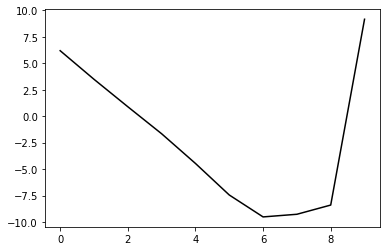

389400 31.02186721120932
1.5712030176768959 1.856644453939483 0.8962512916788289 -1.2547719762728655
[ 5.65363264  3.54379217  0.93521844 -1.63811495 -4.46362786 -7.47171849
 -9.62931483 -9.80096525 -8.97222745  9.13123861]


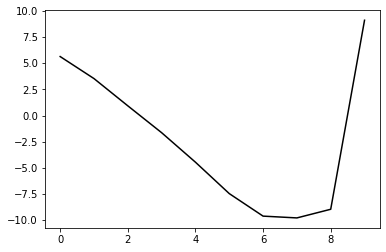

390500 35.595043234346356
1.5743891075407193 1.8374603455170724 0.8861026893226767 -1.2650453286225658
[ 5.86606353  3.53882245  0.92554354 -1.65221666 -4.48014974 -7.48813349
 -9.64706672 -9.83322217 -8.94449319  9.19797868]


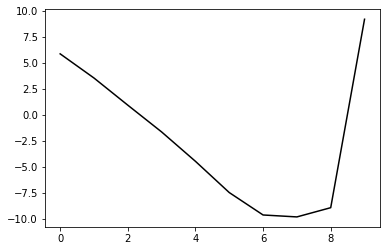

391600 34.369867247815215
1.6553033138207411 1.8500255022097245 0.8768339956094551 -1.288633966293325
[ 6.39207198  3.68912781  1.09940237 -1.45976969 -4.26804054 -7.24121772
 -9.29442988 -9.41457906 -8.53340184  9.13580977]


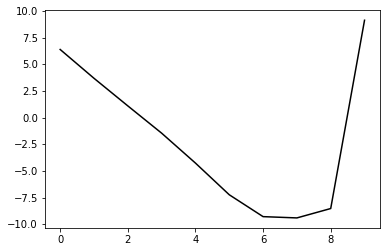

392700 37.99922002961624
1.6068398617350133 1.8323593275130632 0.8883224851013034 -1.271891365332418
[ 5.9190156   3.51623433  0.89510743 -1.69234575 -4.52476607 -7.52732717
 -9.66994837 -9.7911214  -8.83365276  9.15418892]


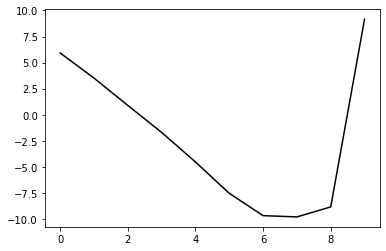

393800 33.71456626854693
1.6179696956441774 1.8717491585316484 0.9221680687924725 -1.244734909254002
[ 6.04848839  3.38231985  0.77118625 -1.81473746 -4.64473081 -7.6359271
 -9.72383607 -9.66546709 -8.68656709  9.06255233]


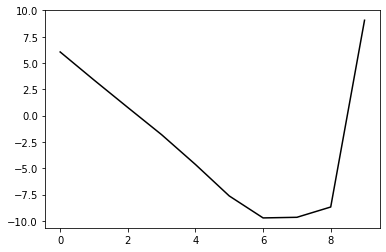

394900 40.7767885064581
1.7020885887024628 1.9181923635445626 0.9421623432962553 -1.2427379708611603
[ 6.3151788   3.37201367  0.78809755 -1.77917627 -4.59459222 -7.56489532
 -9.57869679 -9.26932021 -8.25971906  9.2005615 ]


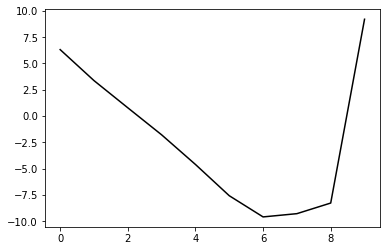

396000 30.45061982241676
1.6680000023566839 1.8785761897155835 0.9052798073183751 -1.2794373428200814
[ 6.09507133  3.61586063  1.01551464 -1.5689168  -4.4011559  -7.39604946
 -9.5051245  -9.53739153 -8.49491873  9.14612161]


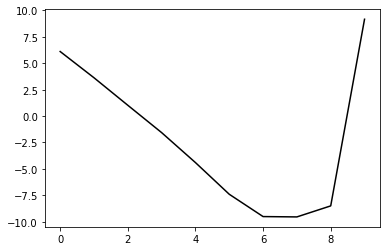

397100 30.797833805426986
1.640043864619693 1.8585835016347625 0.9047099551721096 -1.275389509764069
[ 6.01452418  3.55364014  0.93376968 -1.66862777 -4.51417652 -7.52026057
 -9.64943051 -9.74413683 -8.6638331   9.1590324 ]


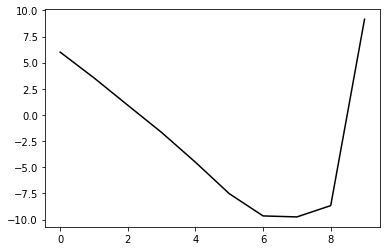

398200 41.9170172369787
1.6607841081688364 1.914511057725173 0.9546026630054069 -1.232613154840018
[ 6.15455506  3.26481295  0.66087562 -1.93078449 -4.76583659 -7.75101768
 -9.78662454 -9.62828235 -8.51658781  9.06763746]


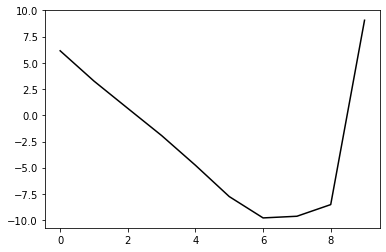

399300 28.989654992577197
1.613776975281893 1.8722531486185408 0.914202819952015 -1.2713170184575167
[ 5.97240609  3.53719739  0.92105525 -1.69057952 -4.54627933 -7.55925397
 -9.70511973 -9.92146701 -8.78083244  9.14076545]


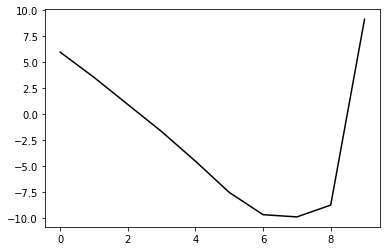

400400 32.36908304400078
1.570467353640392 1.8564076692224625 0.9158746574946088 -1.2645140250001867
[  5.77910936   3.42709004   0.79331565  -1.83509613  -4.70416446
  -7.73054018  -9.90859325 -10.13722536  -8.98490143   9.12011725]


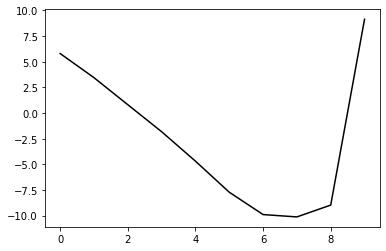

401500 37.50682584978593
1.6200592795999804 1.8332335537188496 0.8867159241915291 -1.2978686350541258
[  5.88924579   3.67895921   1.03810372  -1.59802778  -4.47050511
  -7.49518843  -9.68437444 -10.01326051  -8.78889664   9.16345127]


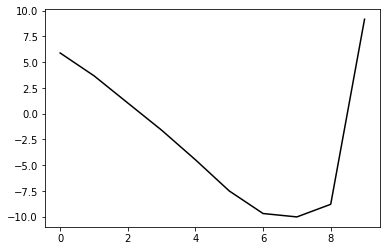

402600 31.914681818119263
1.621466697616402 1.8580420059975125 0.9127823227653272 -1.2764898960332989
[ 5.95022459  3.52750733  0.89685997 -1.73848593 -4.61037719 -7.62656945
 -9.77507814 -9.9539857  -8.70300598  9.13362109]


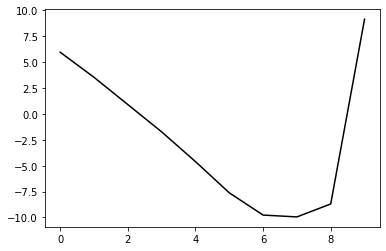

403700 34.82191508891277
1.6236277112882218 1.8711717678206452 0.9360086673496051 -1.2559176712647377
[ 6.06311344  3.30409891  0.66387995 -1.98258716 -4.86184459 -7.87626698
 -9.97046491 -9.95888128 -8.6707911   9.10041705]


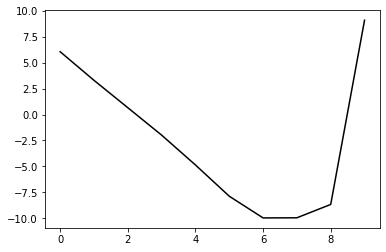

404800 34.44969597569935
1.7155364330010858 1.9003004886187418 0.9401201189836599 -1.2740967538465044
[ 6.36924645  3.44037239  0.82149138 -1.81194255 -4.68102764 -7.67671438
 -9.69554572 -9.53960532 -8.24531559  9.18705448]


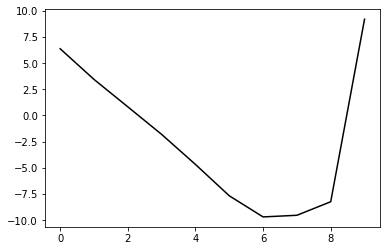

405900 38.89259697541247
1.633770422559655 1.865554845076279 0.9337391761434393 -1.2696045416293136
[  6.07850388   3.37913132   0.72298954  -1.9432044   -4.84022201
  -7.8715775  -10.00111228  -9.95425723  -8.64886276   9.14684164]


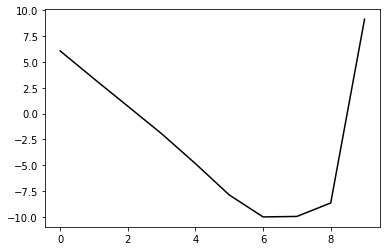

407000 28.973399089682633
1.640794123130321 1.8365405285874088 0.9023897800163523 -1.3034459944752543
[ 5.85874193  3.63546032  0.97624922 -1.70072124 -4.60698666 -7.64568438
 -9.8163382  -9.99382835 -8.67326976  9.25756174]


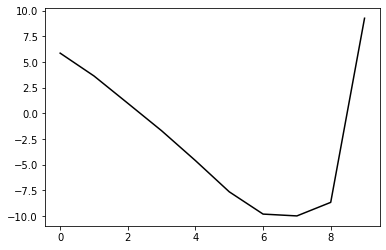

408100 28.752140222692272
1.6043712453867953 1.8727791701697 0.9528882604591036 -1.2517458141204676
[  5.89897631   3.31976207   0.65549705  -2.02806102  -4.93977381
  -7.98202472 -10.15011131 -10.15538326  -8.80349398   9.13713889]


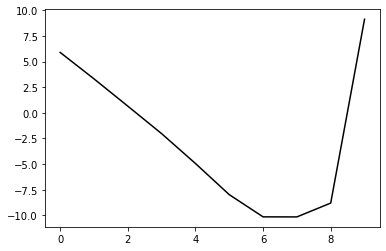

409200 41.66914628828119
1.6297217153988697 1.863069605190894 0.9379934765171536 -1.2760850643352166
[  5.98728408   3.48243428   0.81843777  -1.87410514  -4.7946258
  -7.84162088 -10.017552   -10.10336836  -8.69720615   9.03337335]


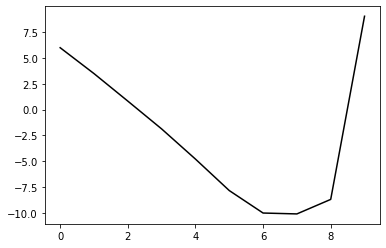

410300 29.387693691972387
1.559743943963874 1.807004131472478 0.9142027588128047 -1.2906254077400332
[  5.86542658   3.49316921   0.80917172  -1.89988647  -4.83525989
  -7.90296314 -10.14161974 -10.49437751  -9.05762598   9.1270403 ]


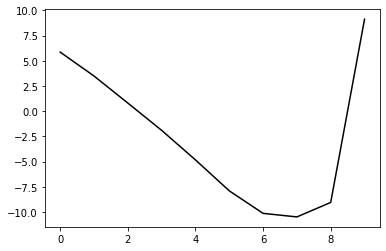

411400 30.90856954853908
1.6178510891169715 1.8245177626877997 0.9117529822132289 -1.3047169410369743
[  6.10414639   3.55650808   0.87911245  -1.82770001  -4.76128305
  -7.82232941 -10.02784361 -10.28875009  -8.82568449   9.09334709]


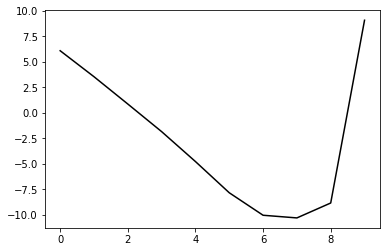

412500 35.94689397588842
1.6525651500830676 1.8287864872193196 0.9111917366719522 -1.312953379730376
[  6.21410787   3.58333928   0.90801956  -1.79801305  -4.73084177
  -7.78727252  -9.96991072 -10.19151233  -8.68398223   9.14975802]


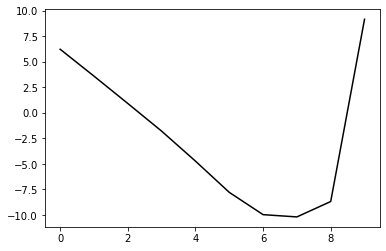

413600 31.638600859746067
1.6129711186419518 1.8298030270968064 0.9294637191119528 -1.2928917679752245
[  6.02558658   3.42004713   0.7391493   -1.97555435  -4.91557572
  -7.97674186 -10.16759864 -10.3772734   -8.85322361   9.12526029]


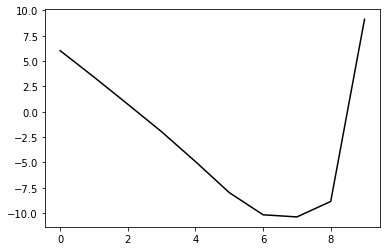

414700 34.335236260046514
1.6714333719964864 1.8472818503993802 0.9398791025395865 -1.2929303690562237
[  6.25418641   3.44624538   0.77044249  -1.94197436  -4.87554981
  -7.91571495 -10.02271011 -10.09074588  -8.56414902   9.10894111]


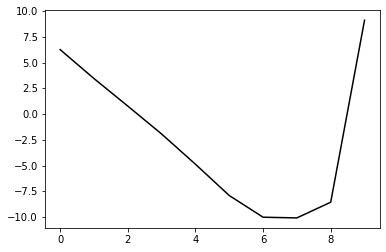

415800 34.12516930783841
1.7025100682562277 1.851170174190092 0.939929620085102 -1.29893457824749
[ 6.34712699  3.49279785  0.82141896 -1.88920552 -4.82082606 -7.85326883
 -9.92495031 -9.9798622  -8.43358353  9.1564437 ]


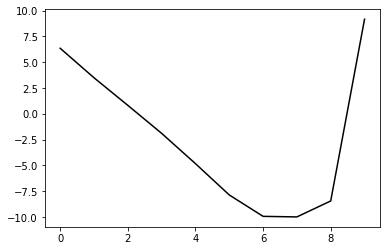

416900 37.3976281632167
1.663305659105382 1.8280070870604603 0.9357154374906111 -1.2966043253458166
[  6.14948892   3.53273911   0.83543344  -1.90024563  -4.85041625
  -7.89854957 -10.01455229 -10.17496285  -8.60434744   9.04939383]


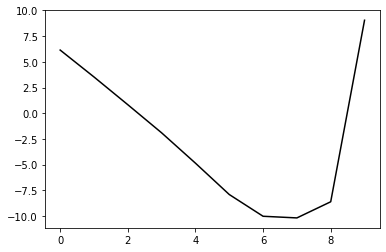

418000 31.623280809741086
1.7125270691496068 1.8500531152598734 0.9316111203373436 -1.314831821921623
[ 6.37029765  3.60870869  0.93220366 -1.78982027 -4.72707294 -7.75085163
 -9.78224501 -9.97199349 -8.39716308  9.15289146]


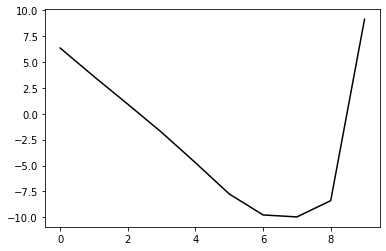

419100 31.426507490272627
1.6640718780306376 1.8316087695175365 0.9279728497636438 -1.314573476452408
[  6.2080863    3.51898764   0.81821286  -1.92916903  -4.89191823
  -7.94909137 -10.05039015 -10.28770709  -8.66166358   9.14921205]


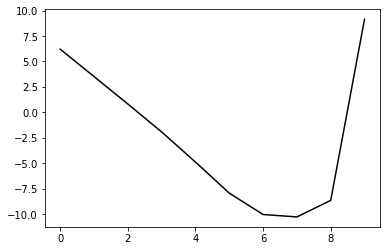

420200 39.418137190140655
1.6274448406736126 1.8592847073505294 0.9647752923257357 -1.2739764409286256
[  5.89873613   3.32186439   0.60989783  -2.1497198   -5.12308396
  -8.19198744 -10.31767152 -10.50475013  -8.87246458   9.10614104]


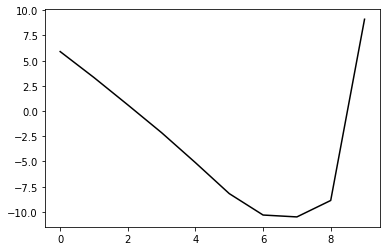

421300 29.476498114966144
1.6361033480938514 1.8428502049551023 0.954461231697134 -1.290723762211624
[  5.96079986   3.41764625   0.69777399  -2.07526117  -5.06028897
  -8.13667718 -10.28196676 -10.50779172  -8.82028267   9.14407832]


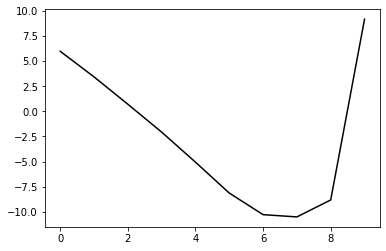

422400 32.201995592945764
1.609117481558725 1.7985068026433397 0.9346189055880264 -1.3052121655348772
[  5.98468993   3.44183764   0.70940245  -2.07359429  -5.06602613
  -8.14968324 -10.30739454 -10.62564647  -8.91967239   9.10657582]


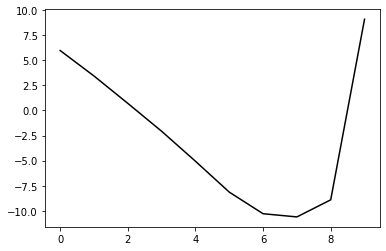

423500 37.212942481131826
1.6711461957618763 1.8014045946513164 0.929325426347468 -1.3213002286196496
[  6.16594378   3.49779988   0.76771342  -2.01247285  -5.00152769
  -8.07575622 -10.18991237 -10.38775358  -8.65564054   9.1415729 ]


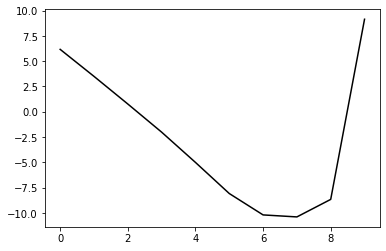

424600 31.96402942238394
1.6511851159903683 1.8135016125671912 0.9271809092582833 -1.3266224203211359
[  6.05268067   3.57966644   0.85525893  -1.93066593  -4.92808266
  -8.01303826 -10.17529886 -10.38719269  -8.67070085   9.13938843]


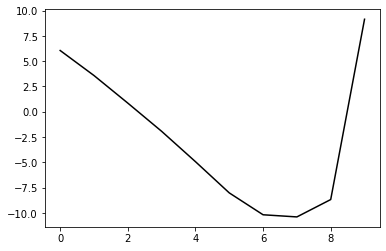

425700 37.25184590559286
1.6443881439454482 1.8028146469325224 0.9237071693941716 -1.3334673317571777
[  6.14568116   3.57394587   0.84133909  -1.95510604  -4.96215497
  -8.05524088 -10.20603732 -10.45377685  -8.72477508   9.16416223]


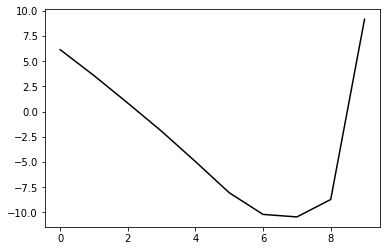

426800 35.17377655086287
1.621602689387621 1.8415402458404757 0.9682971902374434 -1.2918759568157918
[  5.97736721   3.37546266   0.63816182  -2.1699233   -5.18668727
  -8.28597661 -10.42230232 -10.53789028  -8.82578082   9.13673562]


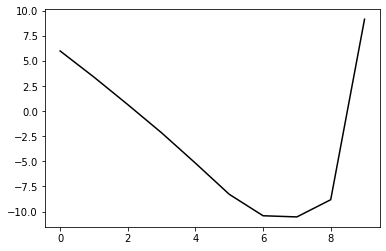

427900 39.88859849394617
1.6067108969688289 1.8197286296869695 0.9570072190411908 -1.303526784336161
[  6.04420563   3.48360921   0.73577109  -2.08590397  -5.11515662
  -8.22669995 -10.37690599 -10.62137172  -8.85375057   9.09813868]


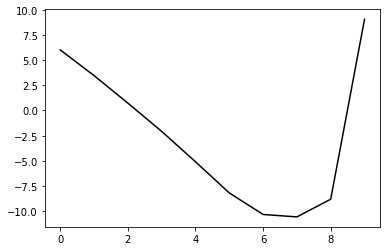

429000 30.712427392681185
1.588167481955595 1.8008871125967545 0.9430252258248514 -1.3181158777314488
[  5.87624175   3.49603931   0.74073964  -2.09364046  -5.13537565
  -8.26211952 -10.46092775 -10.86923448  -9.07525499   9.19281228]


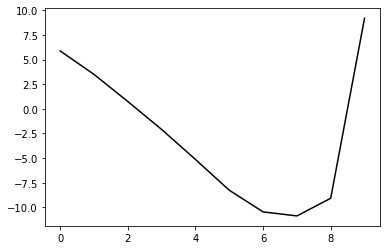

430100 30.569918679110845
1.6334202684359844 1.8161547772026532 0.9549607762403488 -1.3126333547914228
[  6.14833481   3.4600021    0.71006796  -2.12069149  -5.15495177
  -8.25893396 -10.3359703  -10.55341855  -8.76215149   9.10918477]


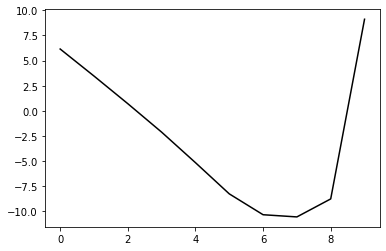

431200 41.84997534644046
1.6399817816340223 1.8096164597470896 0.9495369089074769 -1.324419327524056
[  6.09576006   3.49890676   0.74886656  -2.08466307  -5.12376093
  -8.23379356 -10.33095281 -10.58118578  -8.74570248   9.1549794 ]


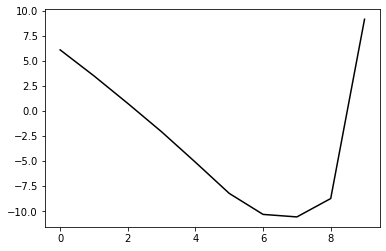

432300 29.00639005362285
1.6443150563626334 1.7863730619213056 0.9354239864458092 -1.339247304871212
[  6.08408795   3.52245779   0.76171991  -2.08321128  -5.13209488
  -8.2510786  -10.36988528 -10.65738919  -8.76974268   9.07419032]


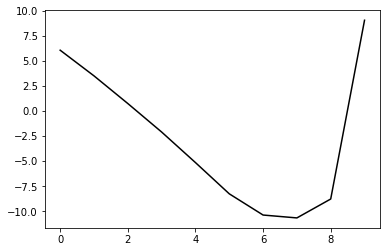

433400 31.0574652384025
1.6404603749312747 1.805107322903216 0.9474226077872069 -1.3302394871449539
[  5.97401463   3.56287391   0.80382044  -2.04675441  -5.10039079
  -8.22019766 -10.34335728 -10.66039572  -8.75938896   9.14068762]


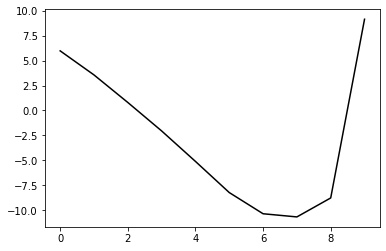

434500 38.53937312691901
1.6415770004489265 1.7697587070501946 0.9064292149862307 -1.3722252217630726
[  5.5687243    3.80003789   1.04157159  -1.8138747   -4.8734682
  -8.00085752 -10.18859529 -10.79888343  -8.86179154   9.0969139 ]


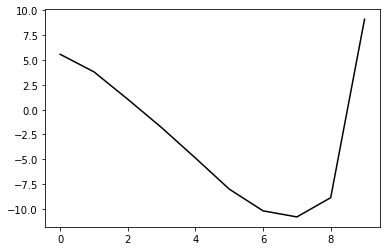

435600 32.70527739702657
1.5630010904454759 1.7673364388937987 0.934356432319575 -1.341405309859658
[  5.73896249   3.57204715   0.79496371  -2.0800828   -5.15917335
  -8.31385648 -10.54285162 -11.1532348   -9.28852443   9.09697321]


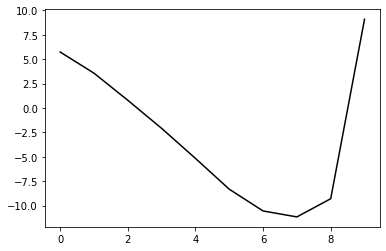

436700 37.80976558145929
1.6287636581482823 1.790526014848548 0.9351898311178425 -1.3543378390482732
[  6.08428859   3.67110379   0.90507592  -1.96507738  -5.03854705
  -8.17688309 -10.31166396 -10.84647753  -8.94566469   9.18819147]


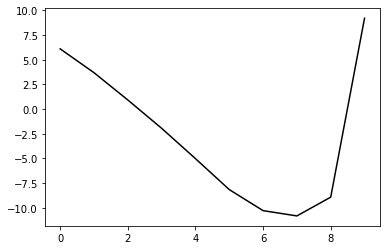

437800 35.02704818102285
1.641563395783067 1.8420166439235124 0.9855919974081259 -1.3128327080782243
[  6.13343762   3.48944646   0.72869446  -2.1442577   -5.22007353
  -8.35186838 -10.38328979 -10.73444811  -8.83703083   9.09001208]


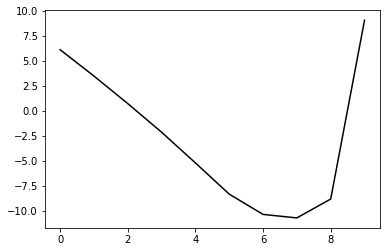

438900 41.28259515709731
1.634373058266187 1.8390806541634281 0.984701034556508 -1.3180343212558348
[  6.04319692   3.5413924    0.77367964  -2.11006096  -5.19700556
  -8.34139437 -10.41471994 -10.90431332  -8.97452166   9.15185342]


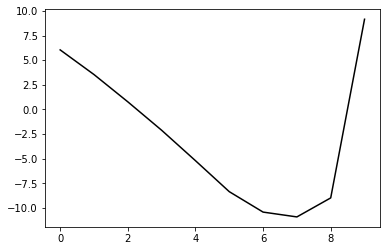

440000 31.244121240720695
1.651878454424035 1.8221328512367216 0.9594536710513745 -1.3479324595075195
[  6.21199307   3.65487884   0.89432675  -1.98856397  -5.07509223
  -8.213708   -10.24482301 -10.79473094  -8.82822006   9.13043251]


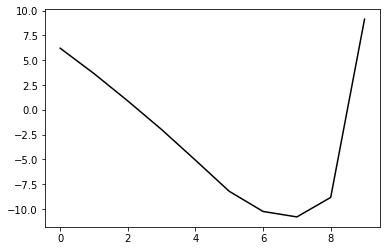

441100 31.278684546167366
1.6580575374255566 1.8172242528551232 0.9485885694218608 -1.3623196764167294
[  6.25815243   3.74684891   0.98617487  -1.90200189  -4.99488578
  -8.13986634 -10.16082801 -10.82054423  -8.80972868   9.17328799]


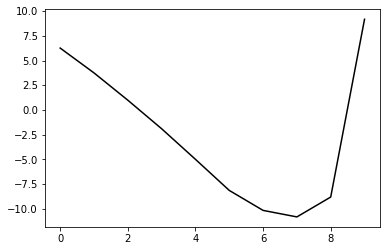

442200 40.35766825167079
1.5909055243044583 1.841148967698996 0.9931474660894383 -1.3120608563207816
[  6.03786938   3.38010727   0.60480306  -2.29854358  -5.40417518
  -8.56027879 -10.54464336 -11.09347417  -9.06950584   9.05249956]


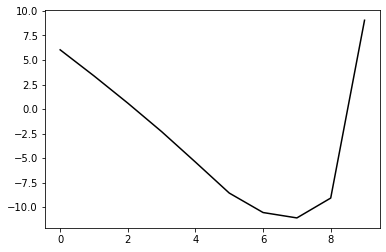

443300 29.41248729711269
1.5432453446194914 1.7705521180497514 0.9442720252051433 -1.3552469501338826
[  5.95035049   3.56323814   0.76720125  -2.15444643  -5.27606683
  -8.45414158 -10.55914094 -11.37041403  -9.34933289   9.11929607]


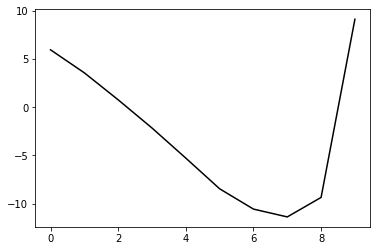

444400 30.4713764663236
1.6341500953961026 1.7962815398494154 0.9540543182677602 -1.3607516650599825
[  6.20967165   3.6237711    0.84136401  -2.07425104  -5.1900258
  -8.34792561 -10.31414345 -11.02575801  -8.94118018   9.12706511]


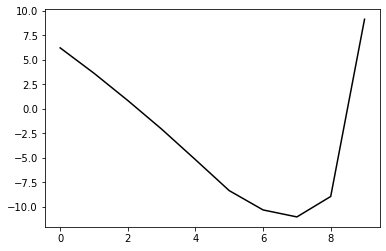

445500 37.1036200718285
1.6406515600976723 1.796168789219667 0.960122725431317 -1.3553197104192607
[  6.15471245   3.54695811   0.75443735  -2.16902467  -5.28937097
  -8.44718822 -10.38353543 -11.05317914  -8.98071995   9.18368129]


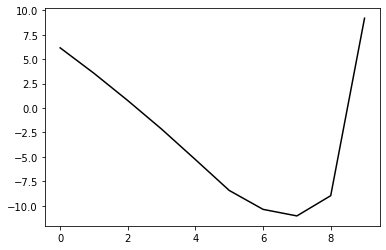

446600 32.16986645414005
1.6477580593818526 1.7811277686556124 0.9445477835203897 -1.3721659596275528
[  6.21255043   3.65999127   0.86537272  -2.06408191  -5.18888134
  -8.34589034 -10.28250575 -11.02318401  -8.90898763   9.10567602]


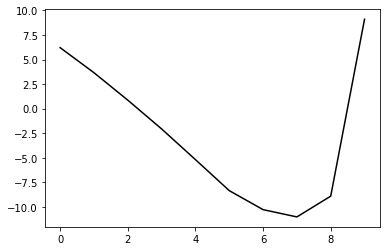

447700 33.74878123140366
1.6828872864607394 1.795863936420909 0.9600539837799772 -1.3651442751437026
[  6.3013192    3.64523387   0.84519495  -2.09216945  -5.22281647
  -8.37787639 -10.24325316 -10.87212153  -8.7353324    9.14795184]


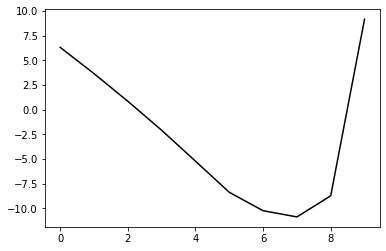

448800 36.28101064541499
1.661233761958704 1.782730466908768 0.9541449715636425 -1.3714739347275067
[  6.05985301   3.61239153   0.80085777  -2.15110079  -5.29653907
  -8.47076468 -10.40556768 -11.08176195  -8.93637796   9.07943188]


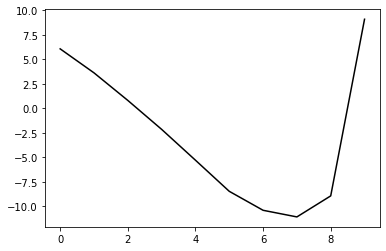

449900 37.87220645244703
1.670749425988691 1.8028642621843636 0.9686572685198581 -1.3659707379239279
[  6.0161998    3.62877484   0.82511432  -2.12702553  -5.27396817
  -8.44574883 -10.33532625 -11.06383283  -8.9344727    9.16190641]


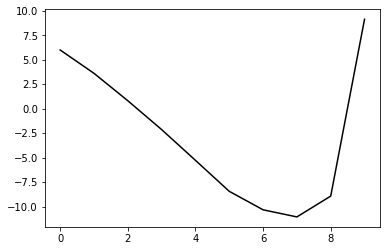

451000 30.580851510685847
1.6642101268435632 1.787511244991089 0.9574069918754539 -1.380898917724596
[  6.07933423   3.72360371   0.90902806  -2.05817129  -5.21902011
  -8.40442325 -10.32212131 -11.15547157  -8.99492786   9.1124636 ]


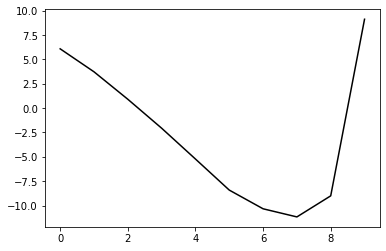

452100 28.681076182515156
1.6535236894403844 1.8163151418467167 0.9959720725293457 -1.3434551452679975
[  6.11062063   3.49823247   0.67926003  -2.29204757  -5.45424946
  -8.63360067 -10.45332931 -11.21042066  -9.03701569   9.14290449]


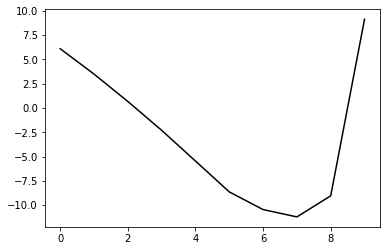

453200 40.335766834535605
1.5887650940795666 1.7566509126735994 0.9584348289652258 -1.3742155027961773
[  5.79444163   3.65383528   0.81212017  -2.18619562  -5.37454172
  -8.59128108 -10.58208916 -11.64205627  -9.44229406   9.03155315]


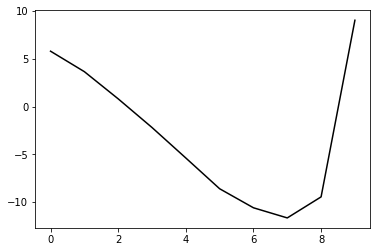

454300 29.203885209023227
1.6540130684000396 1.7863911968167299 0.9715671193882457 -1.3735267903682395
[  6.09630634   3.6284309    0.79917892  -2.19171836  -5.37257094
  -8.56746709 -10.36221696 -11.34373195  -9.08832493   9.10799133]


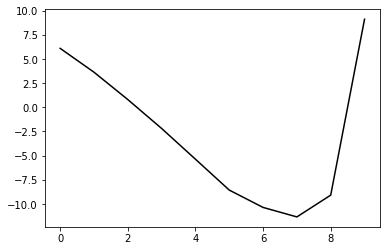

455400 30.615552590228212
1.6205320947293937 1.7615341165753144 0.9602525030429326 -1.3838891718319857
[  5.86136367   3.65864687   0.81869035  -2.1837918   -5.37571837
  -8.58380617 -10.42651993 -11.57030475  -9.31573285   9.12433875]


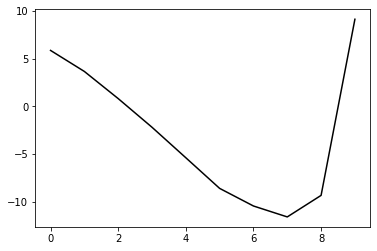

456500 35.75777301544482
1.599641179799481 1.743820373925737 0.9455469582443172 -1.3979175481928117
[  5.67140332   3.75500956   0.90942515  -2.10507222  -5.3086788
  -8.53270781 -10.4117838  -11.76781524  -9.47664544   9.19678846]


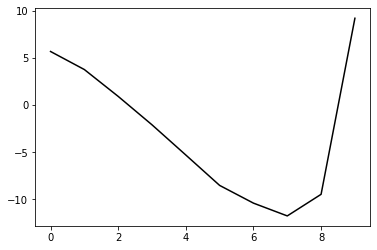

457600 32.01230364620922
1.6551776570334247 1.7699225182685963 0.963271052905265 -1.3921544227240263
[  6.00541403   3.71393616   0.87411622  -2.1400007   -5.34122655
  -8.54667159 -10.24882846 -11.55349356  -9.21275252   9.11608594]


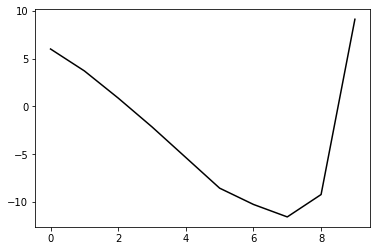

458700 34.49071351583118
1.6392545058486097 1.7852398045698281 0.9839792408434762 -1.3749635196307313
[  6.10745485   3.5949876    0.75659473  -2.26275004  -5.46810576
  -8.66950645 -10.30926594 -11.57555447  -9.22235792   9.12951379]


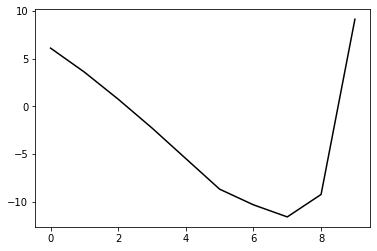

459800 39.62515324241537
1.623942512445218 1.7362555255491015 0.9527864135385099 -1.401756190724916
[  5.9150256    3.73964475   0.87868705  -2.16172731  -5.38363944
  -8.60375696 -10.34383808 -11.80786317  -9.41697017   9.13777944]


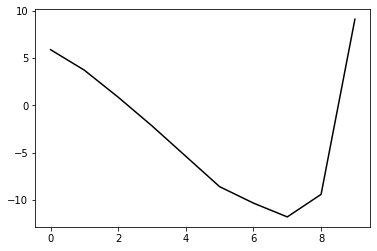

460900 37.65774177559891
1.623991263795098 1.7681335792215898 0.987713807066825 -1.372319974911392
[  6.05926437   3.63882308   0.77596793  -2.27173798  -5.50104732
  -8.72345402 -10.39062015 -11.76709666  -9.34203445   9.11613022]


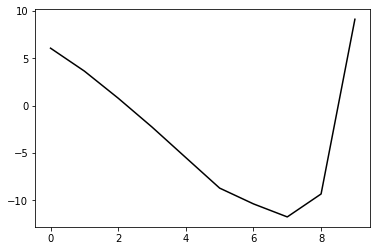

462000 31.085232459463832
1.6407408426701704 1.7882150523160798 1.0039421570096847 -1.361415805542568
[  6.0560023    3.48177874   0.62227448  -2.42569542  -5.65428812
  -8.86869173 -10.38570227 -11.74798608  -9.2886982    9.21256023]


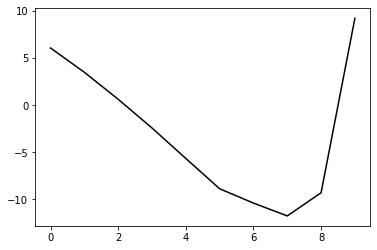

463100 28.580327307489235
1.6485325240575057 1.8001990139827035 1.0107665135143644 -1.3603117549277346
[  5.9995636    3.53007796   0.67460673  -2.37772888  -5.6105059
  -8.82418107 -10.26823438 -11.84752368  -9.3296008    9.12963574]


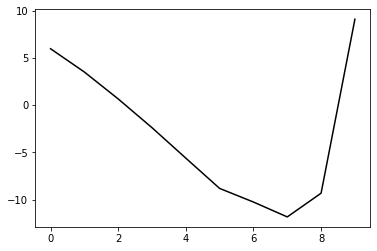

464200 41.202189774635045
1.6530852979083412 1.7799674004970358 0.9798693537930981 -1.39509218703722
[  5.97039905   3.78976793   0.93148766  -2.13396006  -5.38021064
  -8.60942417 -10.13241082 -11.89561919  -9.32190831   9.11273951]


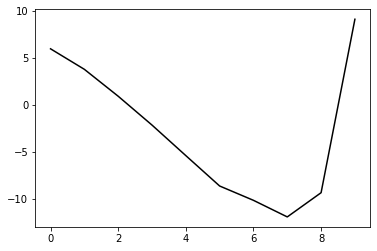

465300 31.047117972171396
1.6739757394023178 1.8190762672295666 1.0104492419394577 -1.37214206864801
[  6.05284713   3.71907999   0.86901815  -2.19696716  -5.44319038
  -8.65851868 -10.08051019 -11.75221985  -9.19809141   9.08215679]


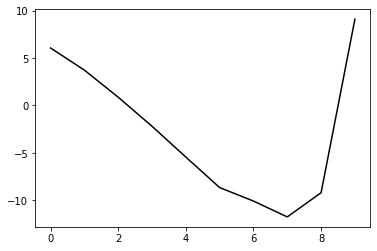

466400 30.838195171501614
1.6109991111512376 1.754647224494372 0.9720098636287292 -1.4011662759567816
[  5.91666188   3.83066509   0.96212556  -2.12060013  -5.38320538
  -8.62379378 -10.1938938  -11.96974197  -9.43129451   9.10611349]


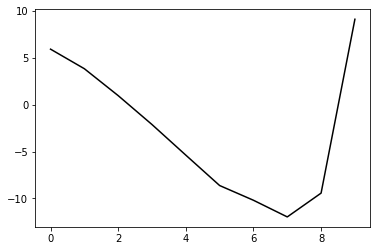

467500 36.90200102946956
1.6494292852512604 1.7736072336587678 0.9758185195626976 -1.4076754300707852
[  6.07412897   3.84953327   0.99084871  -2.08771478  -5.34835571
  -8.57919018 -10.04565865 -11.86645703  -9.26023038   9.16666351]


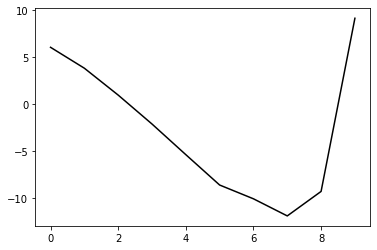

468600 31.593877617583537
1.6165921357292146 1.751665884394515 0.9811200411277398 -1.3966723933103713
[  6.02436386   3.67741024   0.80558425  -2.28323718  -5.55011331
  -8.78011043 -10.17134634 -12.02221265  -9.38056468   9.11360426]


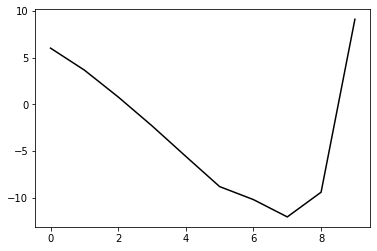

469700 33.790364845283065
1.6039062278115364 1.7635880148010668 0.9974591107661404 -1.383237980613919
[  6.02167089   3.61024822   0.72856674  -2.3726117   -5.64880015
  -8.88173116 -10.25860117 -12.11578502  -9.43779222   9.1110363 ]


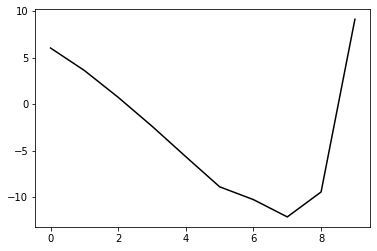

470800 33.47125453996157
1.6395973040113503 1.7827917836733487 1.0137977914580552 -1.3755942517239887
[  6.12582522   3.59677282   0.71701349  -2.389161    -5.66750731
  -8.88875856 -10.0942618  -11.98962552  -9.28665097   9.10861414]


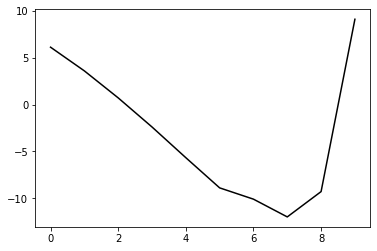

471900 38.742106182467616
1.6683221069591994 1.7617881712725085 0.9867827641857561 -1.407861891156037
[  6.21270453   3.80116044   0.9205396   -2.18949891  -5.46834896
  -8.67744913  -9.86385783 -11.92949899  -9.20463139   9.12077646]


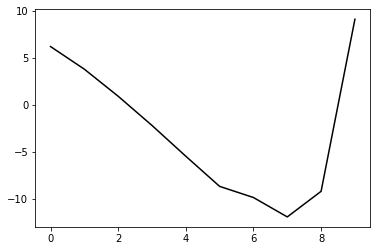

473000 31.27480597241905
1.662996724135668 1.795215884944185 1.0217032456960082 -1.375026296232481
[  6.11426402   3.62301086   0.7498505   -2.36048272  -5.6394122
  -8.83724884  -9.90793145 -12.00267797  -9.21788711   9.13756463]


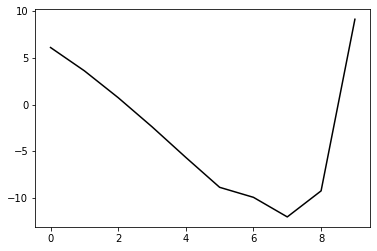

474100 28.632525937365273
1.6319033439691912 1.7839704679373556 1.0188732935594578 -1.3755210289759026
[  5.90339541   3.65841176   0.76753126  -2.36144219  -5.6569501
  -8.87439914  -9.95220297 -12.23222768  -9.40126918   9.11225124]


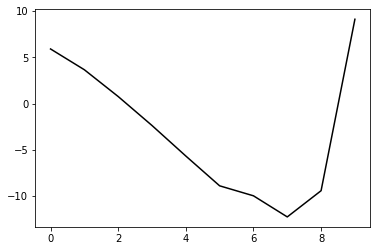

475200 40.110698249228584
1.5951224222763687 1.7333171665268858 0.9798952513335543 -1.4124772013225626
[  5.76189117   3.78291566   0.87553891  -2.27645671  -5.59422355
  -8.83716849 -10.07671595 -12.49159222  -9.65781268   9.01241044]


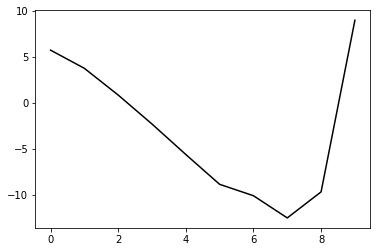

476300 29.56094488526548
1.5567199728910195 1.719002719227517 0.9798942654183231 -1.4092115137934405
[  5.54826677   3.82743386   0.90580016  -2.2614227   -5.59393365
  -8.85929867 -10.2084814  -12.70955973  -9.88410114   9.08514989]


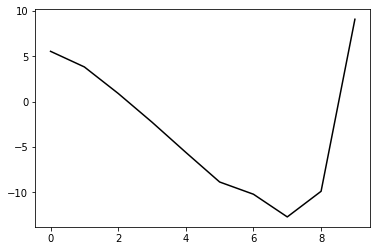

477400 31.380443106674708
1.5644641871518525 1.7239811599892818 0.9863634884588176 -1.4100200221595889
[  5.7093084    3.83883864   0.9202501   -2.25302425  -5.59086738
  -8.85365022 -10.12968644 -12.80302622  -9.86345562   9.09815373]


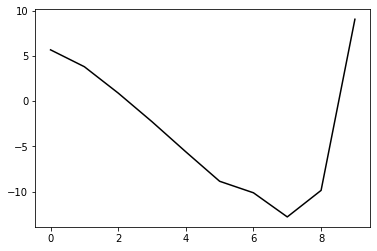

478500 36.127042913494805
1.561905214769619 1.6910917481873966 0.9622186040921201 -1.4358632133770142
[  5.71707877   3.86414312   0.93581889  -2.24981237  -5.59850892
  -8.8694348  -10.10672764 -12.96409724  -9.91757227   9.05959704]


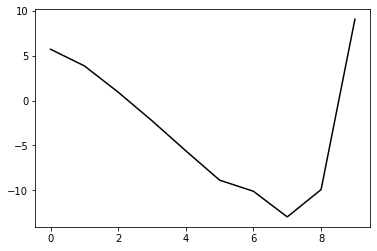

479600 34.03575932157062
1.6104309401391421 1.713214019783635 0.9686853486114094 -1.4417706658180935
[  6.08500873   3.93586006   1.0209393   -2.1589578   -5.50228661
  -8.75321836  -9.86949659 -12.79620861  -9.63226629   9.09155499]


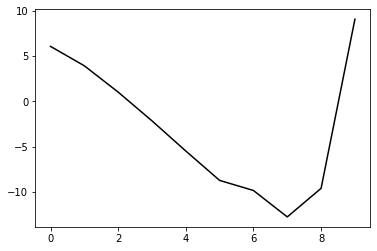

480700 34.37673916033354
1.6034983277290416 1.7316376171080123 0.9994566589602575 -1.4118280282391662
[  6.19325217   3.77834246   0.85907496  -2.32247729  -5.66592585
  -8.90762008  -9.92196997 -12.7896365   -9.5967858    9.15381546]


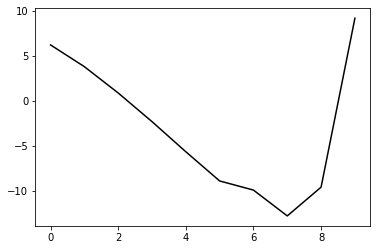

481800 38.971463063405764
1.6081713923335592 1.7126908213263687 0.9794098732510754 -1.4336111291225324
[  6.05517685   3.88541839   0.9628712   -2.22679393  -5.5776921
  -8.82475877  -9.84403505 -12.96217732  -9.68055355   9.04930482]


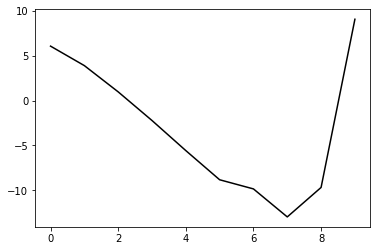

482900 37.95134026343352
1.6388182258402753 1.7447056459540244 1.0046155858613177 -1.417358382144114
[  6.24011652   3.86889933   0.9561253   -2.22912744  -5.57831629
  -8.81331713  -9.72530046 -12.72832719  -9.45846561   9.12456332]


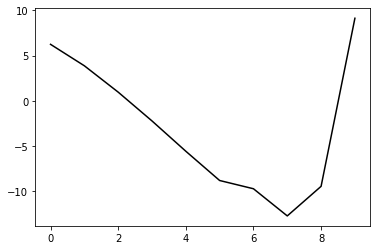

484000 31.426472761650246
1.7044298313718789 1.782121399848451 1.02324363223252 -1.412306675293917
[  6.34969618   3.79735335   0.90157103  -2.2735677   -5.61418234
  -8.82311684  -9.56743374 -12.42944805  -9.16852803   9.12283564]


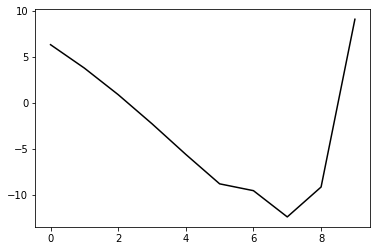

485100 28.92436451998718
1.5878178713139393 1.7534289404967218 1.034049489244173 -1.385226364550439
[  5.93340698   3.58881564   0.6538602   -2.55165817  -5.91661294
  -9.16325946 -10.13065837 -12.95101871  -9.71611604   9.11965486]


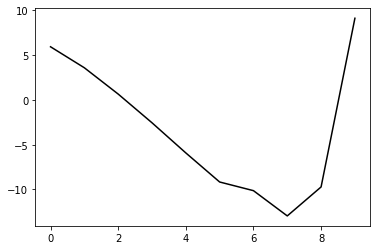

486200 39.30957718960571
1.584195330708229 1.7428284851110127 1.0267436040122915 -1.3947205247311136
[  5.81581627   3.67338255   0.73209646  -2.4838181   -5.86049733
  -9.12324607 -10.04026836 -13.05595177  -9.78464866   9.09978402]


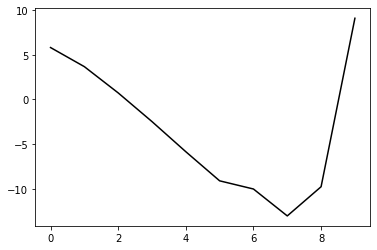

487300 28.946792657686746
1.641582329545286 1.737147189686821 1.0035615655631385 -1.4316395591690687
[  5.99765829   3.88377358   0.9576551   -2.25350204  -5.62715413
  -8.87328341  -9.721656   -12.91556204  -9.57027387   9.17485927]


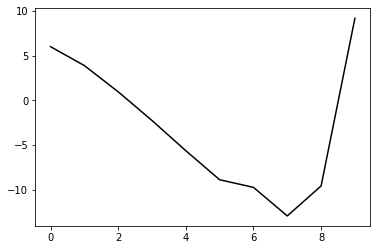

488400 31.053211092061883
1.6302640471575627 1.7235153212191843 0.9933358338823357 -1.4412165943966484
[  5.75930035   4.00172223   1.06878916  -2.15240727  -5.53495507
  -8.78721934  -9.65361814 -13.01696271  -9.68108628   9.09834208]


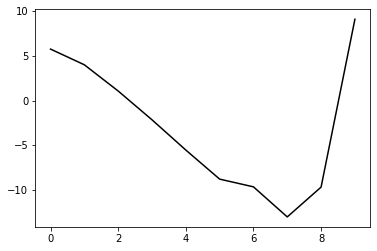

489500 36.085302827719424
1.542692606065889 1.6775884237291911 0.976292559113467 -1.4495842355885729
[  5.54991292   3.88746086   0.92819089  -2.31808517  -5.72512014
  -9.01813518 -10.16287109 -13.3086083  -10.29167924   9.08305294]


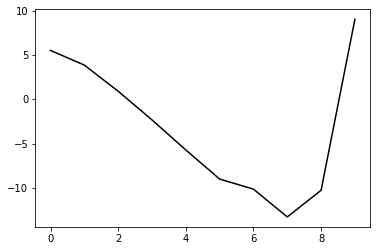

490600 32.173970372185835
1.5901429350835472 1.7136458861571178 1.0022417168838842 -1.4354173951717313
[  6.00590319   3.84453338   0.90090793  -2.33783682  -5.73620433
  -8.9997872   -9.88268483 -13.52326521  -9.89618351   9.13044381]


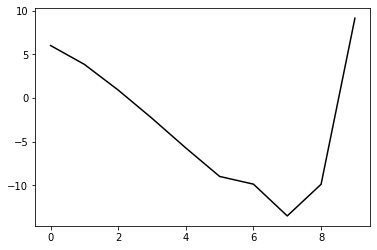

491700 33.769780990175754
1.6148334488162686 1.7330880553734043 1.0241782316679693 -1.418980409100037
[  6.12437462   3.76675172   0.82298566  -2.41707702  -5.8127754
  -9.05672248  -9.83385652 -13.41901174  -9.77760079   9.0992613 ]


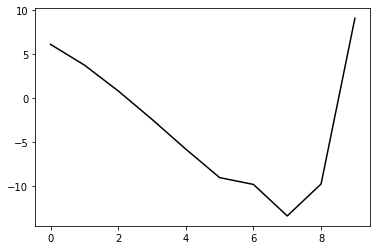

492800 34.32376821028074
1.6626302840959082 1.7363741386134997 1.01282311484609 -1.4401524874306837
[  6.24332411   3.87991509   0.94791805  -2.28899571  -5.68292728
  -8.91323599  -9.66310125 -13.20435136  -9.57019125   9.13477794]


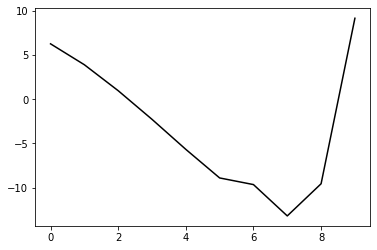

493900 37.879811182998544
1.6351252622082424 1.7198766359760669 1.0158544795961568 -1.4345889522018445
[  6.03274194   3.91369759   0.96091845  -2.29518161  -5.7036426
  -8.94586344  -9.64962905 -13.48384034  -9.70948804   9.0930927 ]


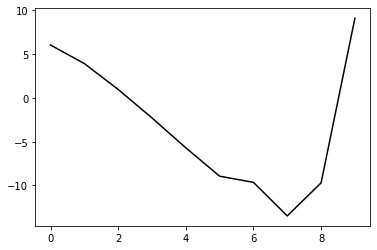

495000 31.100445804745085
1.6493294106859944 1.7278556954741349 1.0203056103047428 -1.4349385877514582
[  6.04266977   3.82636083   0.87815248  -2.37744485  -5.78625586
  -9.02198914  -9.64996433 -13.55581327  -9.70557991   9.09211485]


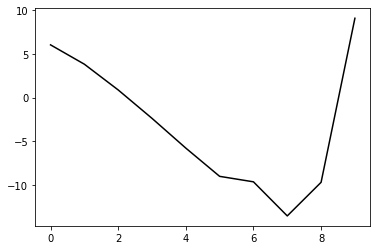

496100 30.7517027080295
1.6563232537907693 1.7026812948312366 1.0016426904965872 -1.4544204002697914
[  5.98476518   3.91019973   0.94980832  -2.3224454   -5.74353559
  -8.98361498  -9.59229163 -13.66016298  -9.73041139   9.16871565]


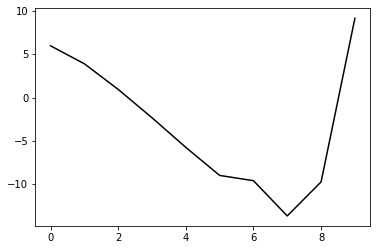

497200 41.152643528780565
1.661739736294093 1.7135926784462927 1.0108816776802765 -1.4490668018828432
[  6.06532805   3.81998384   0.86366677  -2.40559875  -5.82376702
  -9.04836259  -9.56218154 -13.71574227  -9.71483668   9.07763257]


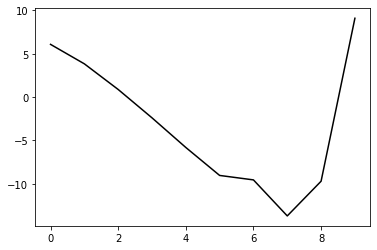

498300 29.009436947116907
1.6495646691047081 1.7263832520485194 1.0146396360588714 -1.4494617586633387
[  5.92463112   3.9829498    1.03133393  -2.24481709  -5.6722629
  -8.90594268  -9.51428462 -13.79993898  -9.78277619   9.09964258]


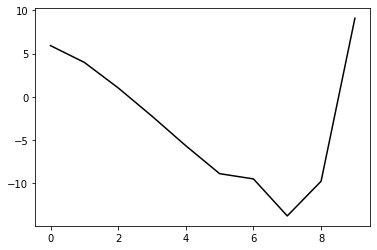

499400 30.524358686859337
1.6371014985865016 1.7077871411021122 1.0120629105750694 -1.4523509176678457
[  6.01429496   3.880253     0.91722055  -2.36899487  -5.80546677
  -9.04319336  -9.59811967 -13.85418505  -9.79963971   9.06182726]


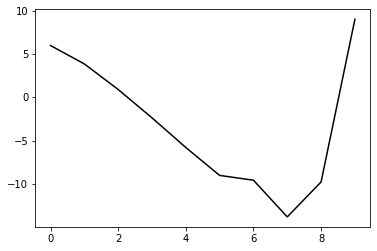

In [19]:
optimizer=tf.optimizers.Adam(learning_rate=0.001)
for j in range (5000):    
    with tf.GradientTape() as g:
        loss=Error_func(h, m2, lam, alpha, beta, Positive[j%10], Negative[j%10])
        gradients=g.gradient(loss, [h, m2, lam, alpha, beta])
    for i in range (80):
        optimizer.apply_gradients(zip(gradients, [h]))
    for i in range (20):
        optimizer.apply_gradients(zip(gradients, [h, m2, lam, alpha, beta]))
    if j%11==0: 
        print(j*100, Error_func(h, m2, lam, alpha, beta, Positive[j%10], Negative[j%10]).numpy())
        print(m2.numpy(), lam.numpy(), alpha.numpy(), beta.numpy()), print(h.numpy())
        plt.plot(h.numpy(), 'k-'), plt.show()

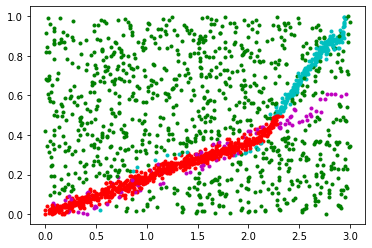

In [20]:
for i in range (set):
    [Positive0[i], Positive1[i]]=NN_func_01(h, m2, lam, alpha, beta, Positive[i])
    [Negative0[i], Negative1[i]]=NN_func_01(h, m2, lam, alpha, beta, Negative[i])
for i in range (set):
    x_data1[i]=[v[0] for v in Positive0[i]]
    y_data1[i]=[v[1] for v in Positive0[i]]
    x_data2[i]=[v[0] for v in Positive1[i]]
    y_data2[i]=[v[1] for v in Positive1[i]]
    x_data3[i]=[v[0] for v in Negative0[i]]
    y_data3[i]=[v[1] for v in Negative0[i]]
    x_data4[i]=[v[0] for v in Negative1[i]]
    y_data4[i]=[v[1] for v in Negative1[i]]
    plt.plot(x_data4[i], y_data4[i], 'g.')
    plt.plot(x_data2[i], y_data2[i], 'c.')
    plt.plot(x_data1[i], y_data1[i], 'r.')
    plt.plot(x_data3[i], y_data3[i], 'm.')
plt.show()